In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

#import tensorflow as tf
#from keras.utils.np_utils import to_categorical
#from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [2]:
image_dir = "/scratch/xxsi3290/Kaggle/jpeg/jpeg/"

In [3]:
dicom_data = pd.read_csv('/scratch/xxsi3290/Kaggle/dicom_info.csv')
dicom_data.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   
3             16          16           BREAST       97     20160503   
4              8           8      Left Breast     3104     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   
3   115347.770            WSD  ...   
4   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   
3                   32298            ISO_IR 100  20170829.0    DDSM   
4                       0            ISO_IR 100         NaN    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  
3  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...   180109.0  
4  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...        NaN  

[5 rows x 38 columns]

In [4]:
dicom_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [5]:
# check image types in dataset
dicom_data.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [6]:
meta_data = pd.read_csv('/scratch/xxsi3290/Kaggle/meta.csv')
meta_data.head()

SeriesInstanceUID  \
0  1.3.6.1.4.1.9590.100.1.2.117041576511324414842...   
1  1.3.6.1.4.1.9590.100.1.2.438738396107617880132...   
2  1.3.6.1.4.1.9590.100.1.2.767416741131676463382...   
3  1.3.6.1.4.1.9590.100.1.2.296931352612305599800...   
4  1.3.6.1.4.1.9590.100.1.2.436657670120353100077...   

                                    StudyInstanceUID Modality  \
0  1.3.6.1.4.1.9590.100.1.2.229361142710768138411...       MG   
1  1.3.6.1.4.1.9590.100.1.2.195593486612988388325...       MG   
2  1.3.6.1.4.1.9590.100.1.2.257901172612530623323...       MG   
3  1.3.6.1.4.1.9590.100.1.2.109468616710242115222...       MG   
4  1.3.6.1.4.1.9590.100.1.2.380627129513562450304...       MG   

  SeriesDescription BodyPartExamined  SeriesNumber Collection  Visibility  \
0   ROI mask images           BREAST             1  CBIS-DDSM           1   
1   ROI mask images           BREAST             1  CBIS-DDSM           1   
2   ROI mask images           BREAST             1  CBIS-DDSM           1   
3   ROI mask images           BREAST             1  CBIS-DDSM           1   
4   ROI mask images           BREAST             1  CBIS-DDSM           1   

   ImageCount  
0           2  
1           2  
2           2  
3           2  
4           2

In [7]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


In [8]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [9]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [10]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [11]:
#cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg/', image_dir, regex=True))
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#cropped_images.head()

full_mammogram_images = full_mammogram_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#full_mammogram_images.head()

ROI_mask_images = ROI_mask_images.replace('CBIS-DDSM/jpeg/', image_dir, regex=True)
#ROI_mask_images.head()

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammogram_images.iloc[0])
print('ROI Mask Images paths:\n')
print(ROI_mask_images.iloc[0])

Cropped Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_images_dict[key] = dicom
for dicom in ROI_mask_images:
    key = dicom.split("/")[6]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

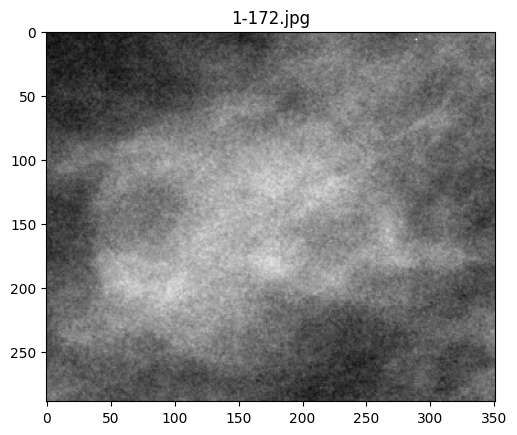

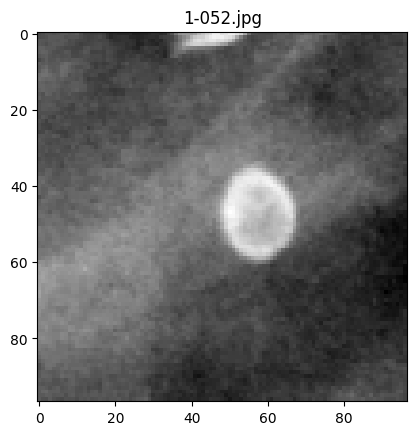

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/1-034.jpg


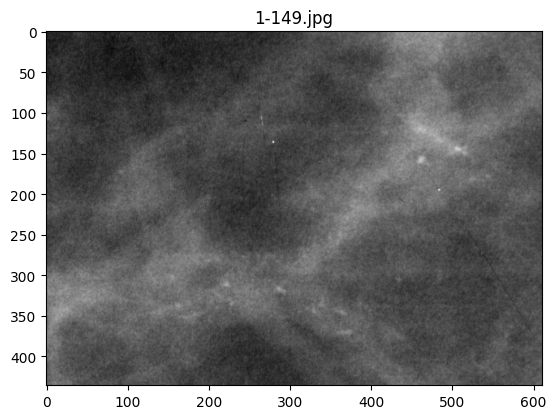

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg
File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/1-085.jpg


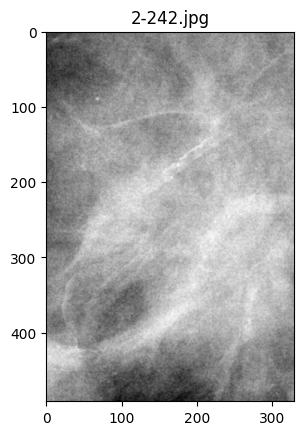

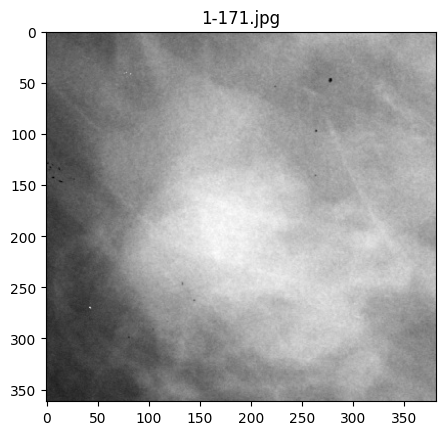

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281604745510897859806968805740602385667/1-111.jpg


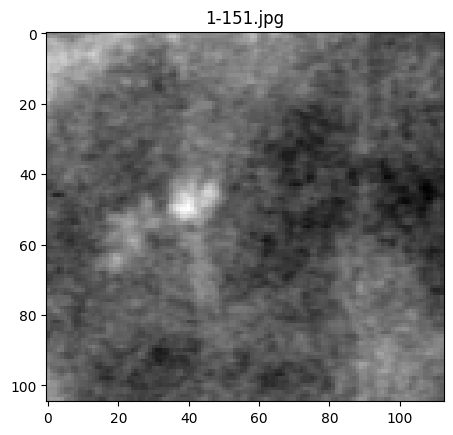

In [13]:
import matplotlib.pyplot as plt 
import glob
import PIL
import random

for file in cropped_images[0:10]:
    try:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue  # Skip to the next file
        cropped_images_show = PIL.Image.open(file)
        gray_img = cropped_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

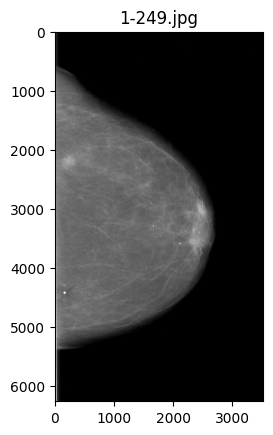

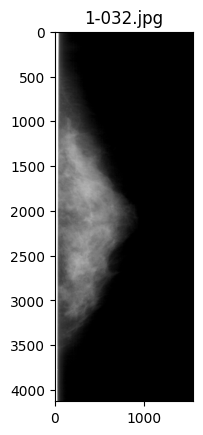

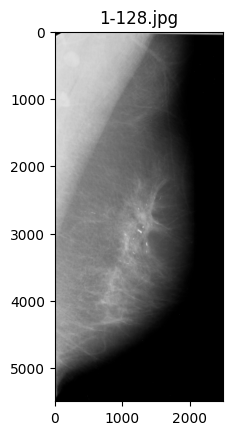

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74956658311383957201426978750903861062/1-248.jpg


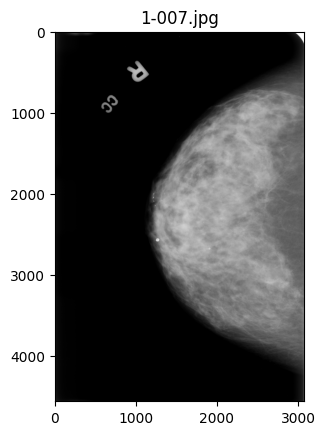

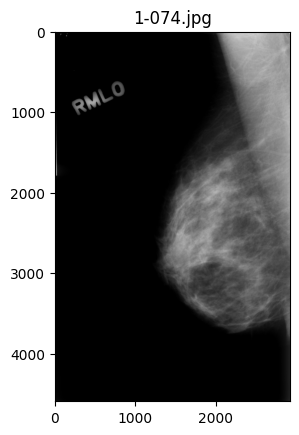

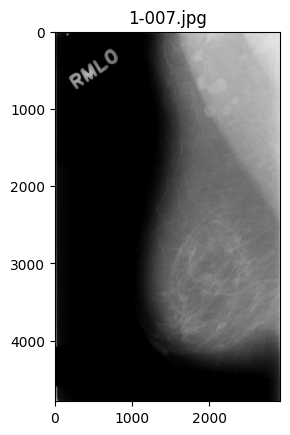

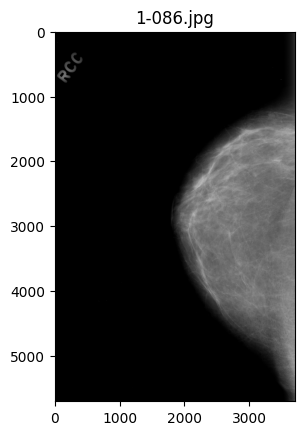

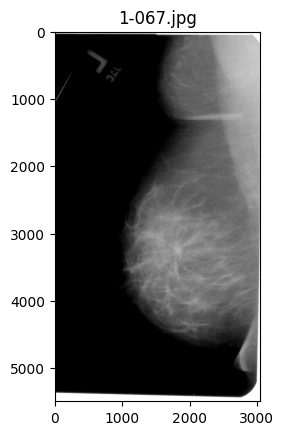

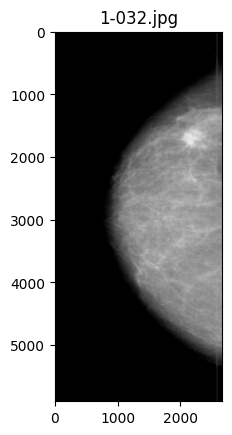

In [14]:
import os
import PIL
import matplotlib.pyplot as plt

for file  in full_mammogram_images[0:10]:
    try:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue
        full_mammogram_images_show = PIL.Image.open(file)
        gray_img= full_mammogram_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


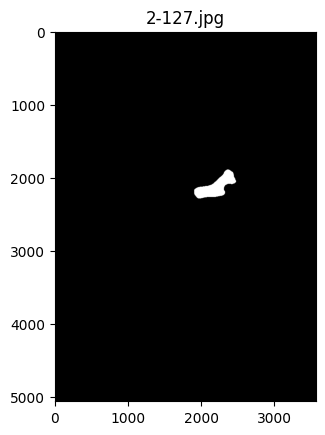

File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg
File not found: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg


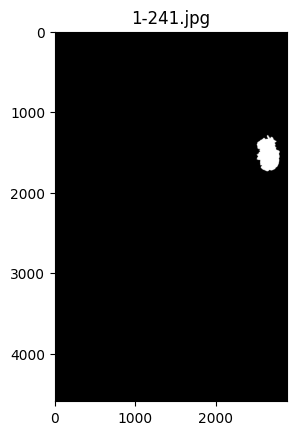

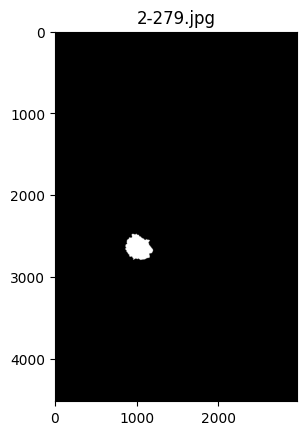

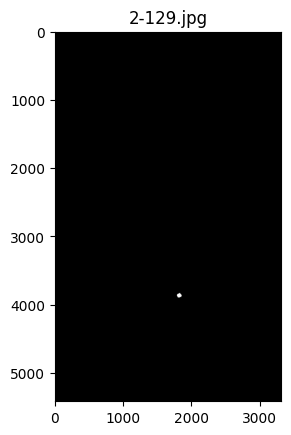

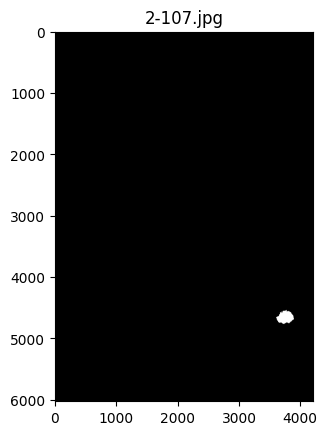

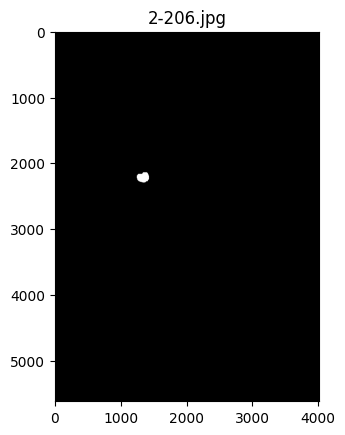

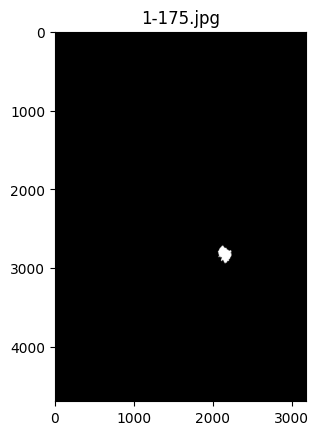

In [15]:
import os
import PIL
import matplotlib.pyplot as plt

for file in ROI_mask_images[0:10]:
    try:
        if not os.path.exists(file):  
            print(f"File not found: {file}")
            continue
        ROI_mask_images_show = PIL.Image.open(file)
        gray_img = ROI_mask_images_show.convert("L")
        plt.imshow(gray_img, cmap='gray')
        plt.title(os.path.basename(file))
        plt.show()
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue


In [16]:
calc_train_df = pd.read_csv('/scratch/xxsi3290/Kaggle/calc_case_description_train_set.csv')
calc_test_df = pd.read_csv('/scratch/xxsi3290/Kaggle/calc_case_description_test_set.csv')

calc_train_df.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [17]:
def fix_image_path_calc(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]
        
        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

fix_image_path_calc(calc_train_df)
fix_image_path_calc(calc_test_df)

In [18]:
# check unique values in pathology column
calc_train_df.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [19]:
calc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

In [20]:
# rename columns
calc_train_df = calc_train_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'calc type': 'calc_type',
                                           'calc distribution': 'calc_distribution',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

calc_train_df.head(5)

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc_type calc_distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image_file_path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                             cropped_image_file_path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                                  ROI_mask_file_path  
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...

In [21]:
calc_train_df.isnull().sum()

patient_id                   0
breast density               0
left_or_right_breast         0
image_view                   0
abnormality_id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image_file_path              0
cropped_image_file_path      0
ROI_mask_file_path           0
dtype: int64

In [22]:
# fill in missing values using the backwards fill method
calc_train_df['calc_type'] = calc_train_df['calc_type'].bfill()
calc_train_df['calc_distribution'] = calc_train_df['calc_distribution'].bfill()

#check null values
calc_train_df.isnull().sum()

patient_id                 0
breast density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [23]:
# quantitative summary of features
calc_train_df.describe()

breast density  abnormality_id   assessment     subtlety
count     1546.000000     1546.000000  1546.000000  1546.000000
mean         2.663648        1.415265     3.258732     3.411384
std          0.937219        0.903571     1.229231     1.179754
min          1.000000        1.000000     0.000000     1.000000
25%          2.000000        1.000000     2.000000     3.000000
50%          3.000000        1.000000     4.000000     3.000000
75%          3.000000        1.000000     4.000000     4.000000
max          4.000000        7.000000     5.000000     5.000000

In [24]:
calc_test_df.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety  \
0                   BENIGN         2   
1                   BENIGN         2   
2  BENIGN_WITHOUT_CALLBACK         5   
3  BENIGN_WITHOUT_CALLBACK         5   
4  BENIGN_WITHOUT_CALLBACK         5   

                                     image file path  \
0  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped image file path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                                  ROI mask file path  
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....  
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....  
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...

In [25]:
# check datasets shape
print(f'Shape of mass_train: {calc_train_df.shape}')
print(f'Shape of mass_test: {calc_test_df.shape}')

Shape of mass_train: (1546, 14)
Shape of mass_test: (326, 14)


In [26]:
calc_test_df = calc_test_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'calc type': 'calc_type',
                                           'calc distribution': 'calc_distribution',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})


In [27]:
calc_test_df.isnull().sum()

patient_id                  0
breast density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
calc_type                   4
calc_distribution          63
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [28]:
# fill in missing values using the backwards fill method
calc_test_df['calc_type'] = calc_test_df['calc_type'].bfill()
calc_test_df['calc_distribution'] = calc_test_df['calc_distribution'].bfill()


#check null values
calc_test_df.isnull().sum()

patient_id                 0
breast density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [29]:
mass_train_df = pd.read_csv('/scratch/xxsi3290/Kaggle/mass_case_description_train_set.csv')
mass_test_df = pd.read_csv('/scratch/xxsi3290/Kaggle/mass_case_description_test_set.csv')

mass_train_df.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [30]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]
        
        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

fix_image_path_mass(mass_train_df)
fix_image_path_mass(mass_test_df)

In [31]:
mass_train_df.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [32]:
mass_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [33]:
# rename columns
mass_train_df = mass_train_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train_df.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                             cropped_image_file_path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                                  ROI_mask_file_path  
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...

In [34]:
# check for null values
mass_train_df.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [35]:
# fill in missing values using the backwards fill method
mass_train_df['mass_shape'] = mass_train_df['mass_shape'].bfill()
mass_train_df['mass_margins'] = mass_train_df['mass_margins'].bfill()

#check null values
mass_train_df.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [36]:
# quantitative summary of features
mass_train_df.describe()

breast_density  abnormality_id   assessment     subtlety
count     1318.000000     1318.000000  1318.000000  1318.000000
mean         2.203338        1.116085     3.504552     3.965857
std          0.873774        0.467013     1.414609     1.102032
min          1.000000        1.000000     0.000000     0.000000
25%          2.000000        1.000000     3.000000     3.000000
50%          2.000000        1.000000     4.000000     4.000000
75%          3.000000        1.000000     4.000000     5.000000
max          4.000000        6.000000     5.000000     5.000000

In [37]:
# view mass_test
mass_test_df.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image file path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                             cropped image file path  \
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...   

                                  ROI mask file path  
0  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
1  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
2  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
3  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...  
4  /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1...

In [38]:
# check datasets shape
print(f'Shape of mass_train: {mass_train_df.shape}')
print(f'Shape of mass_test: {mass_test_df.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [39]:
mass_test_df.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [40]:
mass_test_df = mass_test_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [41]:
# fill in missing values using the backwards fill method
mass_test_df['mass_margins'] = mass_test_df['mass_margins'].bfill()

#check null values
mass_test_df.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [42]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# create function to display images
def display_images(column, number):
    valid_rows = []

    # First, collect only valid image paths
    for _, row in mass_train_df.iterrows():
        image_path = row[column]
        if os.path.exists(image_path):
            valid_rows.append(row)
        if len(valid_rows) == number:
            break

    # Create subplots
    cols = len(valid_rows)
    fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))

    # If only one image is found, axes is not iterable
    if cols == 1:
        axes = [axes]

    # Loop through and display images
    for i, row in enumerate(valid_rows):
        image_path = row[column]
        try:
            image = mpimg.imread(image_path)
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"{row['pathology']}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            continue

    plt.tight_layout()
    plt.show()


Full Mammograms:



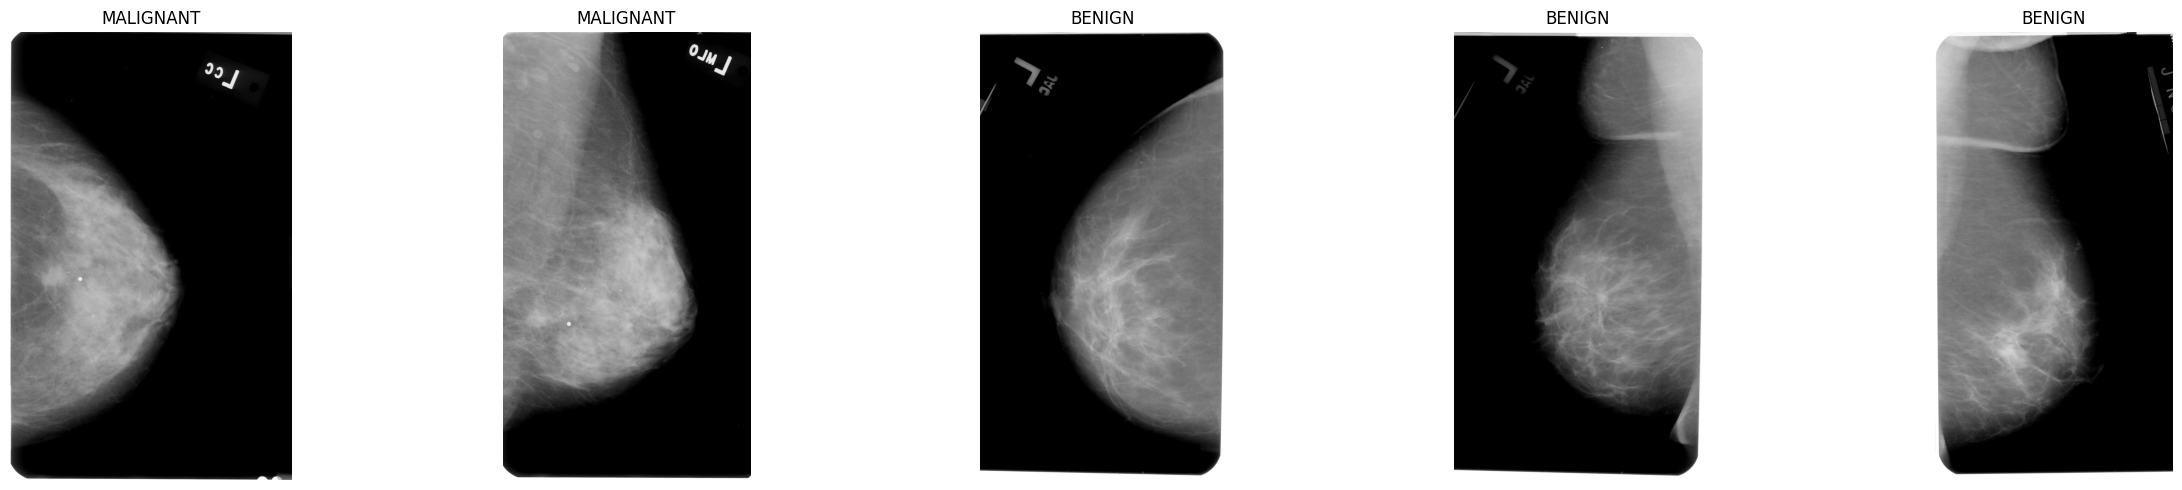

Cropped Mammograms:



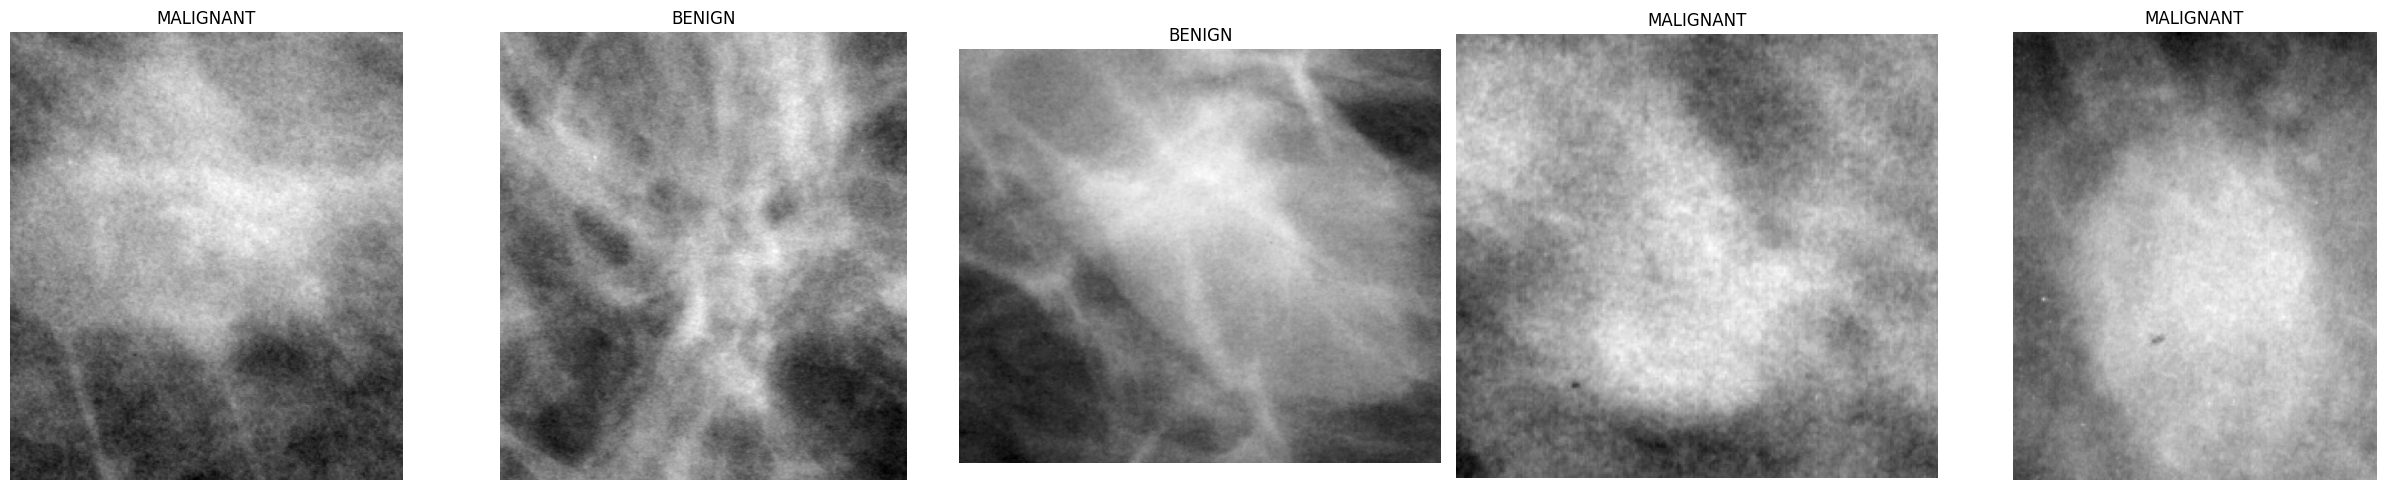

ROI Mask Mammograms:



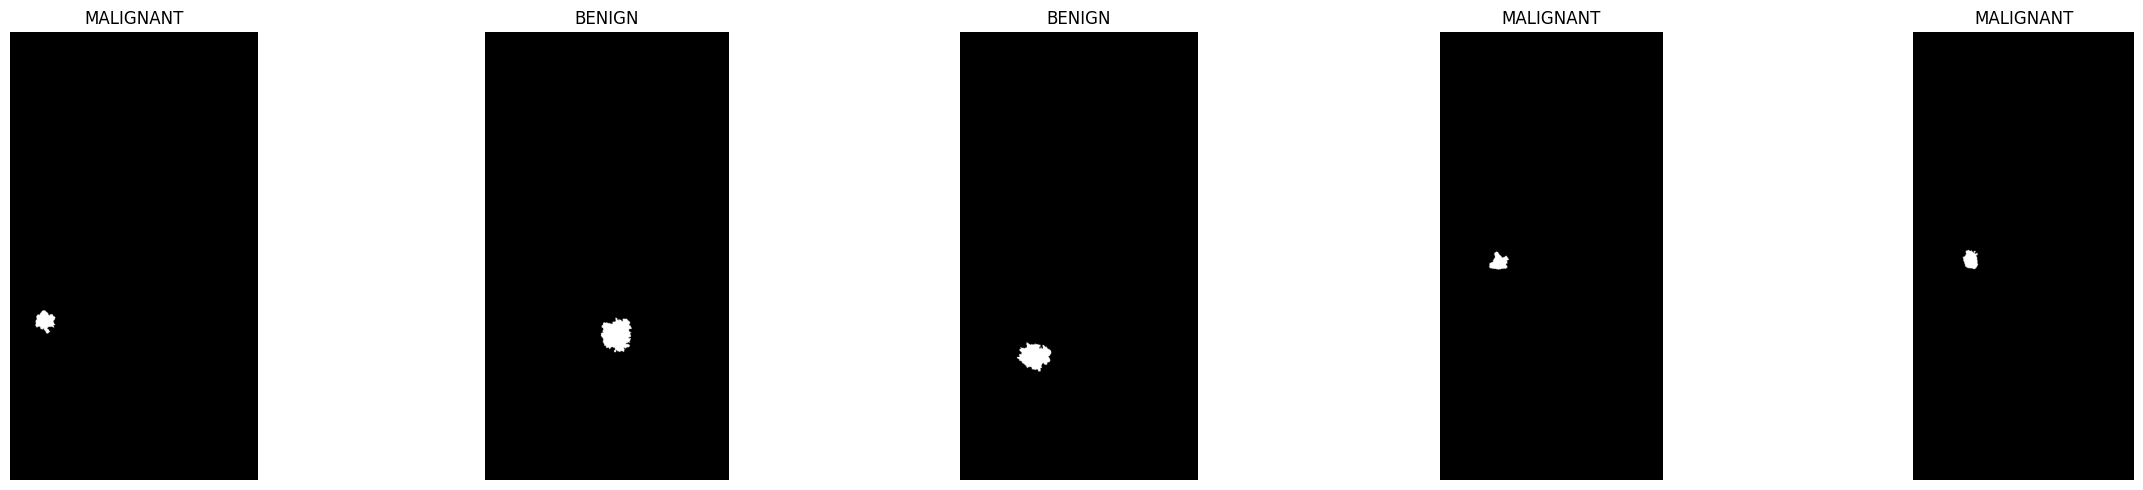

In [43]:
print('Full Mammograms:\n')
display_images('image_file_path', 5)

print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

print('ROI Mask Mammograms:\n')
display_images('ROI_mask_file_path', 5)


In [44]:
from tensorflow.keras.utils import to_categorical
# Import necessary TensorFlow libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.applications.densenet import DenseNet169
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import warnings

# Suppress all warnings globally
warnings.filterwarnings("ignore")


2025-05-15 14:13:40.348577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 14:13:40.350564: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 14:13:40.392414: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 14:13:40.393001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-15 14:13:46.139799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [45]:
#second preprocessing
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    #image = cv2.imread(absolute_image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.imread(absolute_image_path, cv2.IMREAD_GRAYSCALE)

    # Skip unreadable or empty images
    if image is None:
        print(f"Skipping unreadable image: {absolute_image_path}")
        return None
    
    # Resize image
    image = cv2.resize(image, (target_size[1], target_size[0]))
    
    # Histogram Equalization
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #l_channel, a_channel, b_channel = cv2.split(image)
    #clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    #l_channel = clahe.apply(l_channel)
    #image = cv2.merge((l_channel, a_channel, b_channel))
    #image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    
     #Negative transformation
    #image = 255 - image
    
     #Rescale to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    return image

In [46]:
# Merge datasets
full_mass = pd.concat([mass_train_df, mass_test_df], axis=0)
full_calc = pd. concat([calc_train_df, calc_test_df], axis=0)

In [80]:
# Define the target size
target_size = (256, 256, 3)

In [81]:
# Sample a subset of images
sample_size = 1696  # Adjust the sample size as needed
full_mass_sample = full_mass.sample(n=sample_size, random_state=42)
full_calc_sample = full_calc.sample(n=sample_size, random_state=42)

In [82]:
full_sample = pd.concat([full_mass_sample, full_calc_sample], axis=0)

In [83]:
print(full_sample.columns)
print(full_sample.head())

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path', 'breast density',
       'calc_type', 'calc_distribution'],
      dtype='object')
    patient_id  breast_density left_or_right_breast image_view  \
618    P_00889             3.0                 LEFT        MLO   
115    P_00148             2.0                RIGHT        MLO   
135    P_00199             1.0                 LEFT        MLO   
350    P_00496             3.0                 LEFT         CC   
76     P_00358             4.0                RIGHT         CC   

     abnormality_id abnormality_type                mass_shape  \
618               1             mass                 LOBULATED   
115               1             mass                 IRREGULAR   
135               1             mass              

In [84]:
# Apply preprocessor to train data
full_sample['processed_images'] = full_sample['image_file_path'].apply(
    lambda x: image_processor(x, target_size)
)
full_sample['mask_images'] = full_sample['ROI_mask_file_path'].apply(
    lambda y: image_processor(y, target_size)
)


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199195778912558713817031507321459770006/1-135.jpg


[ WARN:0@3799.481] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175476572912204146233170994160170991797/1-227.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3799.637] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199195778912558713817031507321459770006/1-135.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336120486712406273923832111983569913869/1-113.jpg


[ WARN:0@3799.749] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336120486712406273923832111983569913869/1-113.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180869746613853192241744905213634425726/1-281.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.235220303613128401917357295780294851812/1-186.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258122848711932114229110145764023097059/1-085.jpg


[ WARN:0@3800.075] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180869746613853192241744905213634425726/1-281.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3800.200] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.235220303613128401917357295780294851812/1-186.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3800.268] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258122848711932114229110145764023097059/1-085.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174014585211651496903314748162396558249/1-258.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19175306412221051336720162903880247165/1-065.jpg


[ WARN:0@3800.310] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174014585211651496903314748162396558249/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3800.310] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19175306412221051336720162903880247165/1-065.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117454129112394095421646199292904617412/1-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16311307713420957612660499721513179515/1-262.jpg


[ WARN:0@3800.590] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117454129112394095421646199292904617412/1-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3800.757] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16311307713420957612660499721513179515/1-262.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128110220510263998502063254390605854196/1-054.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417738311511512636014376396132371802556/1-038.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171166015912754582622813408142073790722/1-096.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334704328611391643805508991083300190349/1-108.jpg


[ WARN:0@3801.178] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128110220510263998502063254390605854196/1-054.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.178] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417738311511512636014376396132371802556/1-038.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.313] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.313] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171166015912754582622813408142073790722/1-096.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.314] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269090020912271881612869996851061481178/1-265.jpg


[ WARN:0@3801.387] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269090020912271881612869996851061481178/1-265.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397197585712576980835218625502162434719/1-026.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154058962613328519929136864181603772657/1-205.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17179439612364242913491828612897592599/1-075.jpg


[ WARN:0@3801.670] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397197585712576980835218625502162434719/1-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.831] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154058962613328519929136864181603772657/1-205.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3801.868] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17179439612364242913491828612897592599/1-075.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403824995113685855926042098451429311853/1-259.jpg


[ WARN:0@3802.322] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403824995113685855926042098451429311853/1-259.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293359047911187270714650133994167840030/1-181.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263918199211476516622099513693475115311/1-190.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162585879813814097935228732511788537826/1-119.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321571514713247316135159699532641256508/1-215.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83748848211897641311753926793600384304/1-117.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388721083313285222217770141913502774487/1-233.jpg


[ WARN:0@3802.584] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293359047911187270714650133994167840030/1-181.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3802.585] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263918199211476516622099513693475115311/1-190.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3802.616] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162585879813814097935228732511788537826/1-119.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3802.617] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321571514713247316135159699532641256508/1-215.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3802.701] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242629471012127869529548965622673332057/1-258.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52911228912044066036741669740519618759/1-054.jpg


[ WARN:0@3802.821] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242629471012127869529548965622673332057/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3802.822] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52911228912044066036741669740519618759/1-054.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.9383151312430789908711205212663448581/1-243.jpg


[ WARN:0@3803.034] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.9383151312430789908711205212663448581/1-243.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158760583312396940802790127503023485498/1-099.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.290229220113810647235081932003928413427/1-046.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280437157711493692000884645494047094463/1-130.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283896293710468565409445671813981066945/1-033.jpg


[ WARN:0@3803.236] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158760583312396940802790127503023485498/1-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3803.237] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.290229220113810647235081932003928413427/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3803.237] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280437157711493692000884645494047094463/1-130.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3803.428] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283896293710468565409445671813981066945/1-033.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8345832613913482803966749762437997260/1-017.jpg


[ WARN:0@3803.604] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8345832613913482803966749762437997260/1-017.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232043140012455442340816109393409527243/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69102481911614345738992761764104656383/1-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57356823611525636036904521060745035167/1-236.jpg


[ WARN:0@3804.287] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232043140012455442340816109393409527243/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3804.317] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69102481911614345738992761764104656383/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3804.428] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57356823611525636036904521060745035167/1-236.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270615391512904438603136029871346997827/1-180.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304645495911706483111438481251619390979/1-117.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162995550512107573002420048841033718661/1-115.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70876162012018497914376684992676851191/1-181.jpg


[ WARN:0@3804.708] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270615391512904438603136029871346997827/1-180.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3804.708] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304645495911706483111438481251619390979/1-117.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3804.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.162995550512107573002420048841033718661/1-115.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3804.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70876162012018497914376684992676851191/1-181.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74118182511203115438320774433815814204/1-054.jpg


[ WARN:0@3804.937] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74118182511203115438320774433815814204/1-054.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149772059212195203914176201483014915047/1-158.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.234810835612633355538815031322259010855/1-061.jpg


[ WARN:0@3805.393] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149772059212195203914176201483014915047/1-158.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3805.594] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.234810835612633355538815031322259010855/1-061.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3805.594] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188171322412490158916861741203390183722/1-215.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188171322412490158916861741203390183722/1-215.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8846141612920489319812758360158257270/1-050.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109231371313746091407897394002747255810/1-090.jpg


[ WARN:0@3805.668] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8846141612920489319812758360158257270/1-050.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3805.763] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109231371313746091407897394002747255810/1-090.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3805.819] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145489058813789765335170389942387615556/1-040.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145489058813789765335170389942387615556/1-040.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78684859813284664039916578740172712994/1-069.jpg


[ WARN:0@3806.004] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78684859813284664039916578740172712994/1-069.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345140832810160378520078721331878282316/1-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417608135813097018923712441772099200133/1-167.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357895865312935232740791412752491722139/1-273.jpg


[ WARN:0@3806.242] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345140832810160378520078721331878282316/1-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3806.310] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417608135813097018923712441772099200133/1-167.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3806.350] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357895865312935232740791412752491722139/1-273.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69745952012889155812092274262822416242/1-097.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303187804912710561742283155760426369730/1-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245550762511135550738178630953626561752/1-283.jpg


[ WARN:0@3806.650] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69745952012889155812092274262822416242/1-097.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3806.720] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303187804912710561742283155760426369730/1-239.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3806.721] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245550762511135550738178630953626561752/1-283.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113107599413757334715056198522480123157/1-223.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172386840512013560230074211023706864061/1-077.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158164935212165043120376357330832910201/1-177.jpg


[ WARN:0@3806.865] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113107599413757334715056198522480123157/1-223.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.022] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172386840512013560230074211023706864061/1-077.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.023] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158164935212165043120376357330832910201/1-177.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371739864613089761719883355291307551226/1-046.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246326421513862106416389991742169179906/1-107.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.30946803412446097718909326270548961243/1-153.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67409892012207587532711656111341914913/1-113.jpg


[ WARN:0@3807.124] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371739864613089761719883355291307551226/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.192] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246326421513862106416389991742169179906/1-107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.192] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.30946803412446097718909326270548961243/1-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.267] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67409892012207587532711656111341914913/1-113.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12669257310082858042663169390086466638/1-014.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216808559312941034119240923160831351862/1-272.jpg


[ WARN:0@3807.521] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12669257310082858042663169390086466638/1-014.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3807.611] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216808559312941034119240923160831351862/1-272.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201240665512195560313953074353682854284/1-122.jpg


[ WARN:0@3807.803] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201240665512195560313953074353682854284/1-122.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419780045811507010327582708564022857860/1-299.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288980828511203708511066530843699446563/1-225.jpg


[ WARN:0@3808.332] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419780045811507010327582708564022857860/1-299.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3808.333] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288980828511203708511066530843699446563/1-225.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44065475811569696824006401280610368950/1-228.jpg


[ WARN:0@3809.356] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44065475811569696824006401280610368950/1-228.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151746203711583824325790496232356555781/1-133.jpg


[ WARN:0@3809.622] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151746203711583824325790496232356555781/1-133.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325293736011893421816901315930122472763/1-183.jpg


[ WARN:0@3809.966] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325293736011893421816901315930122472763/1-183.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54848434312309044100463325442088001375/1-148.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33507760912554145902744111920344485171/1-235.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191684932212508771025952925500117559600/1-118.jpg


[ WARN:0@3810.390] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54848434312309044100463325442088001375/1-148.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3810.437] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33507760912554145902744111920344485171/1-235.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3810.588] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191684932212508771025952925500117559600/1-118.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200394253511150032912987268422492919749/1-191.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149183380211624614428278537532778083640/1-178.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370020768811676220424047464123530592133/1-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416023076012080833905740875610727249164/1-196.jpg


[ WARN:0@3810.649] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200394253511150032912987268422492919749/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3810.739] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149183380211624614428278537532778083640/1-178.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3810.739] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370020768811676220424047464123530592133/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3810.773] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416023076012080833905740875610727249164/1-196.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.395806490413060973910077403213561423281/1-097.jpg


[ WARN:0@3811.062] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3811.248] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.395806490413060973910077403213561423281/1-097.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.208612233610863139028646317134220626037/1-021.jpg


[ WARN:0@3811.480] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3811.635] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.208612233610863139028646317134220626037/1-021.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg


[ WARN:0@3811.717] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.125012772811929054738373917960770689523/1-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141690078312425196829711709851898133059/1-195.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311879772413692509211401737020929176955/1-177.jpg


[ WARN:0@3812.213] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.125012772811929054738373917960770689523/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3812.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141690078312425196829711709851898133059/1-195.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3812.344] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311879772413692509211401737020929176955/1-177.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227359829311782247437660996313591134165/1-265.jpg


[ WARN:0@3812.454] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3812.494] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227359829311782247437660996313591134165/1-265.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241213639112627717226706279733585932152/1-003.jpg


[ WARN:0@3812.992] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241213639112627717226706279733585932152/1-003.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272184723711385047630954095450427972031/1-184.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83882081811707961806397341681542038535/1-198.jpg


[ WARN:0@3813.349] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3813.349] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272184723711385047630954095450427972031/1-184.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3813.457] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83882081811707961806397341681542038535/1-198.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223355501110410477409262071651794035858/1-060.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.120465669611268291509420478952677521038/1-173.jpg


[ WARN:0@3813.720] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223355501110410477409262071651794035858/1-060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3813.860] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.120465669611268291509420478952677521038/1-173.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85686461910787171020983218554121150052/1-291.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100632214012866120117337678502539182046/1-075.jpg


[ WARN:0@3814.368] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85686461910787171020983218554121150052/1-291.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3814.369] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175043772610570804328930190413021504082/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3814.529] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3814.529] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100632214012866120117337678502539182046/1-075.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg


[ WARN:0@3814.641] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95066275112816836637397827910274893726/1-298.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55307148413799814332579214442886195340/1-298.jpg


[ WARN:0@3814.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55307148413799814332579214442886195340/1-298.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219607249012903142628057639991148226306/1-072.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36825032713107530300938213160028717974/1-270.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg


[ WARN:0@3815.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219607249012903142628057639991148226306/1-072.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3815.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36825032713107530300938213160028717974/1-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3815.298] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138854373111438727811729486684128233341/1-172.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.1147559510416701110684356293737205301/1-079.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59887648512379053809277845872128232362/1-106.jpg


[ WARN:0@3815.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138854373111438727811729486684128233341/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3815.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.1147559510416701110684356293737205301/1-079.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3815.666] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59887648512379053809277845872128232362/1-106.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg


[ WARN:0@3815.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194084118912652164632677195583265936023/1-190.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176964796612485740037787572680731561117/1-077.jpg


[ WARN:0@3816.129] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194084118912652164632677195583265936023/1-190.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3816.202] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176964796612485740037787572680731561117/1-077.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349504173712862535704286567751526799904/1-020.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100522676511025180541602449080267145647/1-111.jpg


[ WARN:0@3816.353] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349504173712862535704286567751526799904/1-020.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3816.383] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100522676511025180541602449080267145647/1-111.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172787227312499793236059621232382095130/1-267.jpg


[ WARN:0@3816.997] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172787227312499793236059621232382095130/1-267.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.313320260312335825215652094932408846389/1-089.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62593965512657640623373713153873390284/1-129.jpg


[ WARN:0@3817.397] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.313320260312335825215652094932408846389/1-089.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3817.422] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3817.578] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62593965512657640623373713153873390284/1-129.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28994390011193705314585586210966915731/1-163.jpg


[ WARN:0@3817.611] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28994390011193705314585586210966915731/1-163.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317213562911173877740615561593769151663/1-037.jpg


[ WARN:0@3817.824] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317213562911173877740615561593769151663/1-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361510015512526913136413449054168104152/1-230.jpg


[ WARN:0@3818.135] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361510015512526913136413449054168104152/1-230.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56526196612878022942647118353975254976/1-017.jpg


[ WARN:0@3818.454] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56526196612878022942647118353975254976/1-017.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382912580213452264934816946051837938528/1-036.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46228080811339703822182406561482041808/1-085.jpg


[ WARN:0@3818.688] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382912580213452264934816946051837938528/1-036.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3818.770] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46228080811339703822182406561482041808/1-085.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27953444711693870518443009471767038842/1-179.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.364070243511921550101340386794199125508/1-107.jpg


[ WARN:0@3819.229] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27953444711693870518443009471767038842/1-179.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3819.405] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.364070243511921550101340386794199125508/1-107.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273104176312975794115853377520445198068/1-149.jpg


[ WARN:0@3819.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3819.875] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273104176312975794115853377520445198068/1-149.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403835121912715843000196868400248684588/1-104.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139051271411881139019982240242711370769/1-061.jpg


[ WARN:0@3820.130] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403835121912715843000196868400248684588/1-104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3820.130] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3820.254] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95930514311143196521379851620797527375/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3820.306] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139051271411881139019982240242711370769/1-061.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.4258120910410897428422437754132883711/1-109.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281986553811315949820316643132362105669/1-198.jpg


[ WARN:0@3820.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.4258120910410897428422437754132883711/1-109.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3820.401] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281986553811315949820316643132362105669/1-198.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385754322612458255422314848630057330699/1-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374524690313732405614119264610057663073/1-035.jpg


[ WARN:0@3820.895] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385754322612458255422314848630057330699/1-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3820.896] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374524690313732405614119264610057663073/1-035.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412557731711484790541710247932923951861/1-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282187186212471477920122594912799518222/1-128.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg


[ WARN:0@3821.345] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412557731711484790541710247932923951861/1-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3821.386] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282187186212471477920122594912799518222/1-128.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3821.412] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231418499611483562804956443353410908413/1-012.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241488192410870375308842249503092939065/1-191.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354974451012606666730836312563315842748/1-072.jpg


[ WARN:0@3821.618] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241488192410870375308842249503092939065/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3821.717] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354974451012606666730836312563315842748/1-072.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119329332411807101909567041850958066649/1-242.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280715336413264839123954197972783877415/1-209.jpg


[ WARN:0@3821.945] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119329332411807101909567041850958066649/1-242.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3821.946] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280715336413264839123954197972783877415/1-209.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351386294512687684821629395204182081789/1-138.jpg


[ WARN:0@3822.499] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351386294512687684821629395204182081789/1-138.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424375028213529712235170387420953707530/1-257.jpg


[ WARN:0@3822.799] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424375028213529712235170387420953707530/1-257.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351095773812262405525829356842200610924/1-251.jpg


[ WARN:0@3823.012] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351095773812262405525829356842200610924/1-251.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10317846812362504718225532432231442871/1-233.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92873692112697289717564934862862198857/1-279.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg


[ WARN:0@3823.623] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10317846812362504718225532432231442871/1-233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3823.685] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92873692112697289717564934862862198857/1-279.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3823.745] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328977677511962475112321192060403830590/1-242.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69688454812257584638918432052709217066/1-003.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17873451612287715806233693563532897726/1-111.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88567571811865245834350703782525414557/1-188.jpg


[ WARN:0@3823.879] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69688454812257584638918432052709217066/1-003.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3823.880] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17873451612287715806233693563532897726/1-111.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3824.000] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88567571811865245834350703782525414557/1-188.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136087942912627055207233775400589898698/1-106.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.212873695611515204908544382810356004572/1-077.jpg


[ WARN:0@3824.186] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136087942912627055207233775400589898698/1-106.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3824.378] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.212873695611515204908544382810356004572/1-077.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26328160312807915105944979513644204307/1-042.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413759996612745390518110068652608488468/1-258.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46561815111905129726185322260150997233/1-070.jpg


[ WARN:0@3824.525] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26328160312807915105944979513644204307/1-042.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3824.566] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413759996612745390518110068652608488468/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3824.603] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46561815111905129726185322260150997233/1-070.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298507260212876852534436916713961683073/1-072.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33525463311604309520509720512605682139/1-244.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90049668411003307234280101243836805116/1-156.jpg


[ WARN:0@3824.983] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298507260212876852534436916713961683073/1-072.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.056] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33525463311604309520509720512605682139/1-244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.056] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90049668411003307234280101243836805116/1-156.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181882185012532469840938456443196306608/1-100.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg


[ WARN:0@3825.312] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181882185012532469840938456443196306608/1-100.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.386] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.399831242111800621220027542190666363688/1-046.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225312674712404832441253979110135741852/1-200.jpg


[ WARN:0@3825.528] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.604] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.399831242111800621220027542190666363688/1-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.714] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225312674712404832441253979110135741852/1-200.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283057547411492757733739237421644364669/1-262.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129176419311733274935464126784195349376/1-029.jpg


[ WARN:0@3825.857] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283057547411492757733739237421644364669/1-262.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3825.965] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129176419311733274935464126784195349376/1-029.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52961829611670829303289191680479351305/1-245.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261521794613721978940690958173191292096/1-290.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.51941006212124694604546402963586764653/1-012.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144135582511225260304642832923710501704/1-125.jpg


[ WARN:0@3826.230] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52961829611670829303289191680479351305/1-245.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3826.259] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261521794613721978940690958173191292096/1-290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3826.259] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.51941006212124694604546402963586764653/1-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3826.349] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144135582511225260304642832923710501704/1-125.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211640311212194984322998849642182089069/1-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88886372611812195428352690450990697351/1-008.jpg


[ WARN:0@3826.485] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211640311212194984322998849642182089069/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3826.658] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88886372611812195428352690450990697351/1-008.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361011800613187938628920052961866947309/1-242.jpg


[ WARN:0@3826.795] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361011800613187938628920052961866947309/1-242.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368677889211938858542071548600720272101/1-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366557165612782681202292343440774546974/1-225.jpg


[ WARN:0@3827.728] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368677889211938858542071548600720272101/1-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3827.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366557165612782681202292343440774546974/1-225.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.277904999011825388509729900852338577655/1-135.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47853905212613770720342330132409520084/1-111.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160090908610489507721266482061808282031/1-138.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57854390411125252714525874340062956276/1-102.jpg


[ WARN:0@3828.003] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.277904999011825388509729900852338577655/1-135.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3828.034] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47853905212613770720342330132409520084/1-111.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3828.133] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160090908610489507721266482061808282031/1-138.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3828.189] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57854390411125252714525874340062956276/1-102.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44354553611120086116092433180902992105/1-142.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258560655311028193625111499672480670508/1-006.jpg


[ WARN:0@3829.055] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44354553611120086116092433180902992105/1-142.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3829.163] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258560655311028193625111499672480670508/1-006.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19233593713150936611511674154223618351/1-027.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317216124410630220004117216344047489299/1-182.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.135126056112780974433437774491962300014/1-037.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425182509912779827704955040293854758529/1-022.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404577305912728645825627508702429716956/1-194.jpg


[ WARN:0@3829.560] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19233593713150936611511674154223618351/1-027.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3829.648] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317216124410630220004117216344047489299/1-182.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3829.648] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.135126056112780974433437774491962300014/1-037.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3829.695] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425182509912779827704955040293854758529/1-022.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3829.695] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.226496395312887740508078232422990396199/1-009.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317382923213614689928747109691347347957/1-199.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136495231711077347326245851332072991979/1-142.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200948278212842430531410154721256979027/1-169.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423418338111627617941958352860375625032/1-093.jpg


[ WARN:0@3830.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.226496395312887740508078232422990396199/1-009.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.317382923213614689928747109691347347957/1-199.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.167] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.136495231711077347326245851332072991979/1-142.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.168] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.200948278212842430531410154721256979027/1-169.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.261] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg


[ WARN:0@3830.508] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94855395812079770126816595643794643222/1-041.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238090837412902571926841401701921392882/1-247.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144954714312199212434707587871456397264/1-127.jpg


[ WARN:0@3830.733] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94855395812079770126816595643794643222/1-041.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.776] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238090837412902571926841401701921392882/1-247.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3830.839] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144954714312199212434707587871456397264/1-127.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124069151812440873834583830380563934034/1-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260358200912160591136730728193628472216/1-238.jpg


[ WARN:0@3831.002] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124069151812440873834583830380563934034/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3831.108] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260358200912160591136730728193628472216/1-238.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19265558812219808138485666643988286593/1-238.jpg


[ WARN:0@3831.252] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19265558812219808138485666643988286593/1-238.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74088365112551230507136001593462769806/1-147.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46282940310410044707024149930022040952/1-142.jpg


[ WARN:0@3831.565] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74088365112551230507136001593462769806/1-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3831.734] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46282940310410044707024149930022040952/1-142.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403249842912482807608031953090899102748/1-081.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194014761511237421025886729180261985635/1-290.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65397885011427959107666095712572175020/1-297.jpg


[ WARN:0@3831.832] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403249842912482807608031953090899102748/1-081.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3831.833] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194014761511237421025886729180261985635/1-290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3831.884] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65397885011427959107666095712572175020/1-297.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268167584712827481520301103922935194568/1-155.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304847144212231865016298922630149685326/1-078.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg


[ WARN:0@3832.118] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268167584712827481520301103922935194568/1-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3832.119] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304847144212231865016298922630149685326/1-078.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3832.169] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27655563411193153813026594573787372096/1-062.jpg


[ WARN:0@3832.347] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27655563411193153813026594573787372096/1-062.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42743836211077677906084043904182953420/1-276.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228112769110310508212894048352876218391/1-288.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299665718312676631426589111303357883600/1-037.jpg


[ WARN:0@3832.576] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42743836211077677906084043904182953420/1-276.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3832.639] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228112769110310508212894048352876218391/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3832.676] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299665718312676631426589111303357883600/1-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25032151411293752139034702442380199664/1-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265454151711796157924978185193155462733/1-241.jpg


[ WARN:0@3832.819] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25032151411293752139034702442380199664/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3832.867] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265454151711796157924978185193155462733/1-241.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.50489409611504312524210891883569393093/1-129.jpg


[ WARN:0@3833.141] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.50489409611504312524210891883569393093/1-129.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.256330807412877366440153727190246662818/1-055.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392008643813084177039922070163021225657/1-079.jpg


[ WARN:0@3833.683] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.256330807412877366440153727190246662818/1-055.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3833.871] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392008643813084177039922070163021225657/1-079.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398065969612214189500602623110797804795/1-154.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148157969912384261328015497391094806291/1-083.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152233603112126251623360168063905498710/1-282.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362096355311749880109413095802268936069/1-263.jpg


[ WARN:0@3833.968] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398065969612214189500602623110797804795/1-154.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3833.968] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148157969912384261328015497391094806291/1-083.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3833.969] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152233603112126251623360168063905498710/1-282.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3834.000] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362096355311749880109413095802268936069/1-263.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247139233113856247217565715372804656493/1-231.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27980645513718577626150235351487309400/1-147.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359948563313211921203994090300862857070/1-196.jpg


[ WARN:0@3834.177] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247139233113856247217565715372804656493/1-231.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3834.236] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27980645513718577626150235351487309400/1-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3834.283] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359948563313211921203994090300862857070/1-196.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308645904112578662514088364913247733416/1-152.jpg


[ WARN:0@3834.446] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308645904112578662514088364913247733416/1-152.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151178406511629586605682927950166107710/1-203.jpg


[ WARN:0@3834.929] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.151178406511629586605682927950166107710/1-203.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149608967312503353909450618211677669934/1-256.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76958903112621704936459227274115747517/1-117.jpg


[ WARN:0@3835.398] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.149608967312503353909450618211677669934/1-256.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3835.523] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76958903112621704936459227274115747517/1-117.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65603312513435703008593993544017526418/1-228.jpg


[ WARN:0@3835.797] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65603312513435703008593993544017526418/1-228.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116404757511169555513192121640222765024/1-084.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189618700912186602728870178774202689346/1-025.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.262900378610637773719221008832166959346/1-120.jpg


[ WARN:0@3836.014] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116404757511169555513192121640222765024/1-084.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3836.053] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189618700912186602728870178774202689346/1-025.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3836.053] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3836.117] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.262900378610637773719221008832166959346/1-120.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104175843212955332137248400671186776872/1-262.jpg


[ WARN:0@3836.570] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104175843212955332137248400671186776872/1-262.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345891015013816713918233478951770382675/1-140.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260826680211463150629506377090181207701/1-120.jpg


[ WARN:0@3836.980] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345891015013816713918233478951770382675/1-140.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3837.103] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260826680211463150629506377090181207701/1-120.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421506712613822555700638363361805204735/1-039.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91499954013996703516414818583573199018/1-264.jpg


[ WARN:0@3837.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421506712613822555700638363361805204735/1-039.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3837.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91499954013996703516414818583573199018/1-264.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27686561811725760701013428913326410240/1-147.jpg


[ WARN:0@3837.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27686561811725760701013428913326410240/1-147.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413066189111289743521076284514105478750/1-197.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147836511311460633701654478620200219052/1-057.jpg


[ WARN:0@3838.272] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413066189111289743521076284514105478750/1-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3838.314] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147836511311460633701654478620200219052/1-057.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284762492511939117113096431964067150055/1-217.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63200910512557522821086711330263634348/1-016.jpg


[ WARN:0@3838.742] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284762492511939117113096431964067150055/1-217.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3838.841] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63200910512557522821086711330263634348/1-016.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408841612911259188639006846810670253077/1-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255728555213663489012061953844243079023/1-107.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47970571410947468918537931823160772974/1-245.jpg


[ WARN:0@3839.033] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408841612911259188639006846810670253077/1-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3839.034] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255728555213663489012061953844243079023/1-107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3839.153] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47970571410947468918537931823160772974/1-245.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.20451842012947487407679988681863733854/1-234.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227873690711676823827576319042588800296/1-210.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54057852711245745614684087582249091583/1-113.jpg


[ WARN:0@3839.294] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.20451842012947487407679988681863733854/1-234.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3839.295] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227873690711676823827576319042588800296/1-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3839.359] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54057852711245745614684087582249091583/1-113.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55778548111209969424695307662410813691/1-016.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.159917220213401433113606588331484616686/1-154.jpg


[ WARN:0@3839.532] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55778548111209969424695307662410813691/1-016.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3839.660] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.159917220213401433113606588331484616686/1-154.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318799084911119262430780458250312419361/1-104.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52106446513173201929277628250108419748/1-086.jpg


[ WARN:0@3839.894] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318799084911119262430780458250312419361/1-104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3840.071] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52106446513173201929277628250108419748/1-086.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148897897112363547336820799050685302111/1-153.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401023586412655416321348819711950708264/1-068.jpg


[ WARN:0@3840.348] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148897897112363547336820799050685302111/1-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3840.405] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401023586412655416321348819711950708264/1-068.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194693289311221141704233109863353072257/1-194.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179458899812520629223660238622755428813/1-163.jpg


[ WARN:0@3840.684] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194693289311221141704233109863353072257/1-194.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3840.685] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168142052011948789309937030612218988654/1-068.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3840.760] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179458899812520629223660238622755428813/1-163.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85914409911351710839139096720265170726/1-121.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.405770000712613552327460084591951406869/1-255.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108774078613788646228188307731057957441/1-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.229153389010770069434497957601415230725/1-099.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194578416513260370005941884310932343300/1-267.jpg


[ WARN:0@3841.011] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85914409911351710839139096720265170726/1-121.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.056] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.405770000712613552327460084591951406869/1-255.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.098] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108774078613788646228188307731057957441/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.124] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.229153389010770069434497957601415230725/1-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.145] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174306451512326600232528311571344224372/1-057.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328888964910420470437557917552593278246/1-172.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251872183712067758830824012051583087146/1-164.jpg


[ WARN:0@3841.548] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174306451512326600232528311571344224372/1-057.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.632] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328888964910420470437557917552593278246/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3841.732] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251872183712067758830824012051583087146/1-164.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.107751848713697696607707227450395136936/1-051.jpg


[ WARN:0@3841.842] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.107751848713697696607707227450395136936/1-051.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.99652509111900105331025325421855924911/1-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359653834712357915523724051462222236076/1-181.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg


[ WARN:0@3842.613] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.99652509111900105331025325421855924911/1-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3842.614] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359653834712357915523724051462222236076/1-181.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3842.790] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122014842013197980401803659680241641105/1-058.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284507638613416758207872997261004998521/1-026.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82469470811582019730628947720344371460/1-286.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.326151466811725669429426336100792405365/1-014.jpg


[ WARN:0@3842.946] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.284507638613416758207872997261004998521/1-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3843.046] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82469470811582019730628947720344371460/1-286.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3843.124] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.326151466811725669429426336100792405365/1-014.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199040568111077523402855758172229500384/1-000.jpg


[ WARN:0@3843.161] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199040568111077523402855758172229500384/1-000.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70012532911736490135306300510795887564/1-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373282707011960449216083283203138529156/1-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57409664311439109642852588912629488901/1-144.jpg


[ WARN:0@3843.379] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.70012532911736490135306300510795887564/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3843.449] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373282707011960449216083283203138529156/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3843.504] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57409664311439109642852588912629488901/1-144.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353764633213863442442494539840710764601/1-092.jpg


[ WARN:0@3843.750] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353764633213863442442494539840710764601/1-092.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403050124711420404835698594840910402827/1-254.jpg


[ WARN:0@3843.966] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3843.967] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403050124711420404835698594840910402827/1-254.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385132842112234370219192252632712589242/1-172.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166340572313787163317606045813812419177/1-075.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385006824412335838937657967684130607502/1-139.jpg


[ WARN:0@3844.546] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385132842112234370219192252632712589242/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3844.655] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166340572313787163317606045813812419177/1-075.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3844.656] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385006824412335838937657967684130607502/1-139.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53164963713539945704420389270899642316/1-128.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg


[ WARN:0@3844.918] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53164963713539945704420389270899642316/1-128.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3845.097] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.220564602411627135838034738500414889195/1-044.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6277281410639072436330631001055971673/1-191.jpg


[ WARN:0@3845.196] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6277281410639072436330631001055971673/1-191.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218620318613956716810749252141856797976/1-299.jpg


[ WARN:0@3845.421] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218620318613956716810749252141856797976/1-299.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91058729212200153403438754930629868603/1-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425698079412077502741643782591283336956/1-267.jpg


[ WARN:0@3845.764] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91058729212200153403438754930629868603/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3845.764] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.425698079412077502741643782591283336956/1-267.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113520701010845494417306400603477997325/1-227.jpg


[ WARN:0@3846.238] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113520701010845494417306400603477997325/1-227.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223200299211434089119224646431205382397/1-219.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269371263412811256614469730851947013418/1-296.jpg


[ WARN:0@3846.493] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223200299211434089119224646431205382397/1-219.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3846.634] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.269371263412811256614469730851947013418/1-296.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394792236611156603001230316853617554862/1-115.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306024108010728918506901922744233626490/1-188.jpg


[ WARN:0@3846.742] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394792236611156603001230316853617554862/1-115.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3846.846] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306024108010728918506901922744233626490/1-188.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362620324812321450233913983280182210137/1-281.jpg


[ WARN:0@3846.968] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362620324812321450233913983280182210137/1-281.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392766189012464402104913399043411120417/1-251.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113442706011768824426077733690823693046/1-269.jpg


[ WARN:0@3847.323] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.392766189012464402104913399043411120417/1-251.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3847.383] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113442706011768824426077733690823693046/1-269.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12070919312880382900449340673073871236/1-210.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343599979312034701930436051711071015260/1-077.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362374565310914921540682385160998166344/1-112.jpg


[ WARN:0@3847.652] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12070919312880382900449340673073871236/1-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3847.742] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343599979312034701930436051711071015260/1-077.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3847.743] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.362374565310914921540682385160998166344/1-112.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113794857611310734222099938972653890313/1-230.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292360889211001391813520710751199015294/1-051.jpg


[ WARN:0@3848.025] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.113794857611310734222099938972653890313/1-230.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3848.059] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292360889211001391813520710751199015294/1-051.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251130205811673047141172596702804417464/1-094.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266133570313100849523783768411170795888/1-228.jpg


[ WARN:0@3848.311] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251130205811673047141172596702804417464/1-094.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3848.439] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266133570313100849523783768411170795888/1-228.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336294562711133796734275132653265929945/1-052.jpg


[ WARN:0@3848.617] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336294562711133796734275132653265929945/1-052.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189675058012591271842516184791920684602/1-051.jpg


[ WARN:0@3848.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189675058012591271842516184791920684602/1-051.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.323873351911762283127423474124042969679/1-252.jpg


[ WARN:0@3849.140] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.323873351911762283127423474124042969679/1-252.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123968816011512951434814084172747879091/1-289.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166407449713489341006907780000949344586/1-164.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6326146212137720929099055383856573953/1-154.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104119411412935707132033373840932496396/1-121.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255781430912151131328345834864129594300/1-067.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155550497511364708026317123900311555763/1-122.jpg


[ WARN:0@3849.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123968816011512951434814084172747879091/1-289.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3849.458] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166407449713489341006907780000949344586/1-164.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3849.487] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6326146212137720929099055383856573953/1-154.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3849.576] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104119411412935707132033373840932496396/1-121.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3849.576] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.146297207812381871014727591804106869851/1-137.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.355464339112205472025411629030840677852/1-195.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19398374813678635437774124921258413367/1-081.jpg


[ WARN:0@3849.868] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.355464339112205472025411629030840677852/1-195.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3849.868] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.19398374813678635437774124921258413367/1-081.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322667976213415973414521161391249353390/1-155.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.134769761712283351009294739412953750298/1-193.jpg


[ WARN:0@3850.121] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322667976213415973414521161391249353390/1-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3850.232] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.134769761712283351009294739412953750298/1-193.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394636780211288993834413664462575701980/1-080.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182021535212924472406957876541192691518/1-173.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264906955811106358522569461023509978726/1-232.jpg


[ WARN:0@3850.339] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394636780211288993834413664462575701980/1-080.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3850.474] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182021535212924472406957876541192691518/1-173.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3850.474] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264906955811106358522569461023509978726/1-232.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170988990012713841817997341910281230031/1-186.jpg


[ WARN:0@3850.700] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385542139512279828113137552801440217253/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3850.798] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170988990012713841817997341910281230031/1-186.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419552524112122749501984836111617727698/1-294.jpg


[ WARN:0@3851.206] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419552524112122749501984836111617727698/1-294.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108/1-198.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54589971912845806600662511713175024068/1-191.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398258976712483192035853720641860573126/1-154.jpg


[ WARN:0@3851.578] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108/1-198.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3851.727] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54589971912845806600662511713175024068/1-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3851.728] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398258976712483192035853720641860573126/1-154.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12869627612231993827821925170759563675/1-196.jpg


[ WARN:0@3851.998] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.12869627612231993827821925170759563675/1-196.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16010789511745132713883529233369038329/1-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg


[ WARN:0@3852.393] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18321540012684193708096260002352282494/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3852.422] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16010789511745132713883529233369038329/1-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3852.503] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419410657312812960613390693250292392446/1-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110502161611149520011463704441518604678/1-058.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35590170712015951402001860292316082102/1-256.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.415322967111147284839344646543638715081/1.3.6.1.4.1.9590.100.1.2.166059636612391779430407668611634437956/000000.dcm


[ WARN:0@3852.696] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110502161611149520011463704441518604678/1-058.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3852.865] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35590170712015951402001860292316082102/1-256.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3852.865] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.415322967111147284839344646543638715081/1.3.6.1.4.1.9590.100.1.2.166059636612391779430407668611634437956/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374456071011395261732671102923665581412/1-282.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418726330413468375416377862913199051800/1-086.jpg


[ WARN:0@3852.984] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374456071011395261732671102923665581412/1-282.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3853.149] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418726330413468375416377862913199051800/1-086.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.365452443811764926000393384013009629026/1.3.6.1.4.1.9590.100.1.2.385318920211943956428747846422015934212/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281276517812012770524093858962951173112/1-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.112718850112840659603647143690815628530/1-032.jpg


[ WARN:0@3853.313] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.365452443811764926000393384013009629026/1.3.6.1.4.1.9590.100.1.2.385318920211943956428747846422015934212/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3853.335] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281276517812012770524093858962951173112/1-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3853.335] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.112718850112840659603647143690815628530/1-032.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272230846811005623727075675251389323749/1-180.jpg


[ WARN:0@3853.524] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272230846811005623727075675251389323749/1-180.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.129989474212585121136211936294268136878/1.3.6.1.4.1.9590.100.1.2.295490758411175424801442592530133617119/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.113279660311240118827528275210420300461/1.3.6.1.4.1.9590.100.1.2.267631872912076578535071006022240033258/000000.dcm


[ WARN:0@3853.891] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.129989474212585121136211936294268136878/1.3.6.1.4.1.9590.100.1.2.295490758411175424801442592530133617119/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3854.047] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.113279660311240118827528275210420300461/1.3.6.1.4.1.9590.100.1.2.267631872912076578535071006022240033258/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144204938110882656031845083352087750820/1-263.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73990521811657770904256091191165394630/1-184.jpg


[ WARN:0@3854.122] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144204938110882656031845083352087750820/1-263.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3854.285] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73990521811657770904256091191165394630/1-184.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.308003609811708896140235956723425779820/1.3.6.1.4.1.9590.100.1.2.175382778511258946501326317242254559109/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.229109074112050313235405347033400678961/1.3.6.1.4.1.9590.100.1.2.136687544312709719238508433274271277284/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227697324311701147708092174143523408017/1-183.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.309703409411983532325536303361748760238/1.3.6.1.4.1.9590.100.1.2.158682188012072650235747027632697987981/000000.dcm


[ WARN:0@3854.342] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.308003609811708896140235956723425779820/1.3.6.1.4.1.9590.100.1.2.175382778511258946501326317242254559109/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3854.376] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.229109074112050313235405347033400678961/1.3.6.1.4.1.9590.100.1.2.136687544312709719238508433274271277284/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3854.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.227697324311701147708092174143523408017/1-183.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3854.441] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.3097

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81224121613615658336040014641017971693/1-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.259749192511820032606351371581395160040/1.3.6.1.4.1.9590.100.1.2.330857446012977397138099882753167890565/000000.dcm


[ WARN:0@3854.584] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81224121613615658336040014641017971693/1-239.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3854.721] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.259749192511820032606351371581395160040/1.3.6.1.4.1.9590.100.1.2.330857446012977397138099882753167890565/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.309703409411983532325536303361748760238/1.3.6.1.4.1.9590.100.1.2.158682188012072650235747027632697987981/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.384159464510350889125645400702639717613/1.3.6.1.4.1.9590.100.1.2.174390361112646747718661211471328897934/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241020638813027313501928349840148500619/1-281.jpg


[ WARN:0@3854.986] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.309703409411983532325536303361748760238/1.3.6.1.4.1.9590.100.1.2.158682188012072650235747027632697987981/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3854.986] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.384159464510350889125645400702639717613/1.3.6.1.4.1.9590.100.1.2.174390361112646747718661211471328897934/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3855.022] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241020638813027313501928349840148500619/1-281.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01711_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.58822551012230390237100346042759933624/1.3.6.1.4.1.9590.100.1.2.198664786512996551023962430914065511350/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.302080540010025808913376961441643139046/1-162.jpg


[ WARN:0@3855.199] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01711_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.58822551012230390237100346042759933624/1.3.6.1.4.1.9590.100.1.2.198664786512996551023962430914065511350/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3855.265] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3855.265] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.302080540010025808913376961441643139046/1-162.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.420818841311996822535426545930834918391/1.3.6.1.4.1.9590.100.1.2.367652626313050820436402654071233849762/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360157171311166640209868517473621555491/1-189.jpg


[ WARN:0@3855.636] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3855.636] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.420818841311996822535426545930834918391/1.3.6.1.4.1.9590.100.1.2.367652626313050820436402654071233849762/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3855.636] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360157171311166640209868517473621555491/1-189.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.375470901113491991412418077891524072392/1.3.6.1.4.1.9590.100.1.2.309169976611939668535642477072753478403/000000.dcm


[ WARN:0@3855.915] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.375470901113491991412418077891524072392/1.3.6.1.4.1.9590.100.1.2.309169976611939668535642477072753478403/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00041_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.69692063913639875309068650720468252275/1.3.6.1.4.1.9590.100.1.2.272917492411709393015036949944104292812/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.265830818011246806807297204511108785670/1.3.6.1.4.1.9590.100.1.2.20232052811861584242150823693777847703/000000.dcm


[ WARN:0@3856.261] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00041_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.69692063913639875309068650720468252275/1.3.6.1.4.1.9590.100.1.2.272917492411709393015036949944104292812/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3856.429] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.265830818011246806807297204511108785670/1.3.6.1.4.1.9590.100.1.2.20232052811861584242150823693777847703/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00163_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.102307995713574140823712861903467914035/1.3.6.1.4.1.9590.100.1.2.418134355612932102030136849102116704357/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417245885012230027939057578802735850674/1-244.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00195_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.381793985810299270821486811073079498503/1.3.6.1.4.1.9590.100.1.2.380273595512176626620212914250182855403/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00344_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.383247321612538425133047909341371423843/1.3.6.1.4.1.9590.100.1.2.16538698211686486425718009862712591172/000000.dcm


[ WARN:0@3856.588] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00163_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.102307995713574140823712861903467914035/1.3.6.1.4.1.9590.100.1.2.418134355612932102030136849102116704357/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3856.633] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.417245885012230027939057578802735850674/1-244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3856.633] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00195_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.381793985810299270821486811073079498503/1.3.6.1.4.1.9590.100.1.2.380273595512176626620212914250182855403/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3856.734] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00344_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.38324

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416662957412543243601653044863599039456/1-267.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01547_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.51389853411459241002156727532581336894/1.3.6.1.4.1.9590.100.1.2.229013901811476548604341958812495919089/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.117273555513397540314613915240083079645/1.3.6.1.4.1.9590.100.1.2.372134991510103017329822911161277721811/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.125171114311395562424345312604170887749/1.3.6.1.4.1.9590.100.1.2.228145110911907288720511663481487304924/000000.dcm


[ WARN:0@3856.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416662957412543243601653044863599039456/1-267.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3856.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01547_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.51389853411459241002156727532581336894/1.3.6.1.4.1.9590.100.1.2.229013901811476548604341958812495919089/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3856.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.117273555513397540314613915240083079645/1.3.6.1.4.1.9590.100.1.2.372134991510103017329822911161277721811/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3857.048] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.12

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.93881535910818370606107380921347869014/1.3.6.1.4.1.9590.100.1.2.320532241710917213922153243164201936113/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246955628010861739125873409552788690641/1-024.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01006_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.10832087713189401040814263432196046095/1.3.6.1.4.1.9590.100.1.2.242916615411539131418258364482174881460/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01834_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.390862632011886945105586592060663969064/1.3.6.1.4.1.9590.100.1.2.3856316604118191739

[ WARN:0@3857.089] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.93881535910818370606107380921347869014/1.3.6.1.4.1.9590.100.1.2.320532241710917213922153243164201936113/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3857.134] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3857.134] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246955628010861739125873409552788690641/1-024.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3857.134] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01006_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.1083208

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336250745512245224235516614562274071177/1-074.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00164_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.198671590012596483413328889620965677973/1.3.6.1.4.1.9590.100.1.2.101282442711963955211635160453427358442/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211042445212536071003764839771776411157/1-224.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01820_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.89449810712379339308868476530708903503/1.3.6.1.4.1.9590.100.1.2.101088347411683211841739390870264222457/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00643_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.230979065312612120226728096193722464188/1.3.6.1.4.1.9590.100.1.2.26657663513211061129491770023656595497/000000.dcm


[ WARN:0@3857.458] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336250745512245224235516614562274071177/1-074.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3857.492] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00164_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.198671590012596483413328889620965677973/1.3.6.1.4.1.9590.100.1.2.101282442711963955211635160453427358442/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3857.525] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.211042445212536071003764839771776411157/1-224.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3857.594] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01820_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.89449810712379339308868476530708903503/1.3.6.1.4.1.9590.100.1.2.101088347411683211841739390

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.171237778213286314004831596800955774428/1.3.6.1.4.1.9590.100.1.2.120762895113344405411143779050723940544/000000.dcm


[ WARN:0@3857.779] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.171237778213286314004831596800955774428/1.3.6.1.4.1.9590.100.1.2.120762895113344405411143779050723940544/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59876705111770220814922804890965064040/1-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00649_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.301034222513314771404207384623917780841/1.3.6.1.4.1.9590.100.1.2.120248097712357420920838888041500811658/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324110361612535993028172399623484397143/1-042.jpg


[ WARN:0@3858.210] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59876705111770220814922804890965064040/1-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3858.271] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00649_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.301034222513314771404207384623917780841/1.3.6.1.4.1.9590.100.1.2.120248097712357420920838888041500811658/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3858.272] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324110361612535993028172399623484397143/1-042.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg


[ WARN:0@3858.455] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.85658352611473824117286353031482367864/1.3.6.1.4.1.9590.100.1.2.357605884411852871634858571834022548369/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg


[ WARN:0@3858.677] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.85658352611473824117286353031482367864/1.3.6.1.4.1.9590.100.1.2.357605884411852871634858571834022548369/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3858.825] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156805203412920037240953312442485485632/1-150.jpg


[ WARN:0@3859.136] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156805203412920037240953312442485485632/1-150.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.130771752912766067402650523451325263533/1-163.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.117871523412300598032182222142061208553/1.3.6.1.4.1.9590.100.1.2.227424867211387289616341177611523680294/000000.dcm


[ WARN:0@3859.389] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.130771752912766067402650523451325263533/1-163.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3859.583] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3859.584] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3859.584] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.117871523412300598032182222142061208553/1.3.6.1.4.1.9590.100.1.2.227424867211387289616341177611523680294/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.126181588411230067414911420430462619335/1.3.6.1.4.1.9590.100.1.2.406306640712417773200472142621979655000/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.207673804211103557441193847251640642407/1.3.6.1.4.1.9590.100.1.2.274130392610570391808711256560834154926/000000.dcm


[ WARN:0@3859.669] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.126181588411230067414911420430462619335/1.3.6.1.4.1.9590.100.1.2.406306640712417773200472142621979655000/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3859.670] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.207673804211103557441193847251640642407/1.3.6.1.4.1.9590.100.1.2.274130392610570391808711256560834154926/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02275_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.333954196013353416811191709442669593951/1.3.6.1.4.1.9590.100.1.2.211245852411553375218922095460645818053/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321929123012576086437246588662466892578/1-192.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.4811363711268416027726795723158159993/1.3.6.1.4.1.9590.100.1.2.171130805912113865022755513943080674175/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.137523573912882333323301615572357720683/1.3.6.1.4.1.9590.100.1.2.266330922711278145820055051962759232884/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.425425999111981459007730827801424873345/1.3.6.1.4.1.9590.100.1.2.1607745889120739

[ WARN:0@3859.908] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02275_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.333954196013353416811191709442669593951/1.3.6.1.4.1.9590.100.1.2.211245852411553375218922095460645818053/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3859.909] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.321929123012576086437246588662466892578/1-192.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3859.909] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.4811363711268416027726795723158159993/1.3.6.1.4.1.9590.100.1.2.171130805912113865022755513943080674175/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3859.909] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.13752

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56462208410951047915797559653131614021/1-050.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01538_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.279087520312201509826135958212025417644/1.3.6.1.4.1.9590.100.1.2.315990654413683631831065578571106670633/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.177706148911820252341905176394069228468/1.3.6.1.4.1.9590.100.1.2.263861248711313923336051913560309963304/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01562_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.160700825011143448433269510551530912794/1.3.6.1.4.1.9590.100.1.2.372876695312636361642907557220690345049/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.241020638813027313501928349840148500619/1-281.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/

[ WARN:0@3860.200] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56462208410951047915797559653131614021/1-050.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3860.282] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01538_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.279087520312201509826135958212025417644/1.3.6.1.4.1.9590.100.1.2.315990654413683631831065578571106670633/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3860.366] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.177706148911820252341905176394069228468/1.3.6.1.4.1.9590.100.1.2.263861248711313923336051913560309963304/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3860.366] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01562_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.1607

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.314856149211235095106832447312094568605/1-109.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374456071011395261732671102923665581412/1-282.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246955628010861739125873409552788690641/1-024.jpg


[ WARN:0@3860.460] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.314856149211235095106832447312094568605/1-109.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3860.460] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.374456071011395261732671102923665581412/1-282.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3860.461] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246955628010861739125873409552788690641/1-024.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.281995509911268616135781403152057785893/1.3.6.1.4.1.9590.100.1.2.353075360012805185539926762392393204597/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.66181967013340895404159325772568431740/1.3.6.1.4.1.9590.100.1.2.190396557911044436017707772353927261390/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.212760424113495449619475872271037064856/1.3.6.1.4.1.9590.100.1.2.68805569811200186830775538132892321888/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.257979549512926684716381871403745112147/1-107.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.145734018111291645519131313920862306101/1.3.6.1.4.1.9590.100.1.2.374083122712703142

[ WARN:0@3860.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.281995509911268616135781403152057785893/1.3.6.1.4.1.9590.100.1.2.353075360012805185539926762392393204597/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3860.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.66181967013340895404159325772568431740/1.3.6.1.4.1.9590.100.1.2.190396557911044436017707772353927261390/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3860.767] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.212760424113495449619475872271037064856/1.3.6.1.4.1.9590.100.1.2.68805569811200186830775538132892321888/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3860.768] global loadsave.cpp:268 findDecoder imread_('

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.400642445411116614439550714051604352212/1-037.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.187901580911478669925012776200242918395/1.3.6.1.4.1.9590.100.1.2.204430961913085029114963861863064771359/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296655292410858880841776257620436965580/1-173.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144425327810769880435021910300097657923/1-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.372739902412408589212667852042931575284/1.3.6.1.4.1.9590.100.1.2.391683051613386189935720165611428552711/000000.dcm


[ WARN:0@3861.004] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.400642445411116614439550714051604352212/1-037.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3861.069] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.187901580911478669925012776200242918395/1.3.6.1.4.1.9590.100.1.2.204430961913085029114963861863064771359/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.070] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296655292410858880841776257620436965580/1-173.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3861.070] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg'): can't open/read file: check file path/integrity
[ WARN:0@386

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01523_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.188863259611458930907223066932483754016/1.3.6.1.4.1.9590.100.1.2.158403059012945602114600513492305861703/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.279229856411469372607467262930297060238/1.3.6.1.4.1.9590.100.1.2.10934298311067781740288275432644531576/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.382048488912622118040210812494015732398/1.3.6.1.4.1.9590.100.1.2.220148131710644925328282700082566799231/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01050_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.363998200112214044803426133823527273191/1.3.6.1.4.1.9590.100.1.2.266057194011548503500277838530918587668/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00041_LEFT_MLO/1.3.6.1.4.1.9590.1

[ WARN:0@3861.233] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01523_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.188863259611458930907223066932483754016/1.3.6.1.4.1.9590.100.1.2.158403059012945602114600513492305861703/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.233] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.279229856411469372607467262930297060238/1.3.6.1.4.1.9590.100.1.2.10934298311067781740288275432644531576/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.233] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.382048488912622118040210812494015732398/1.3.6.1.4.1.9590.100.1.2.220148131710644925328282700082566799231/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.266] global loadsave.cpp:268 findDecoder imread_(

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274036148012404966036935151961518989858/1-224.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389476532213001007221401929220409430214/1.3.6.1.4.1.9590.100.1.2.189053724912516038924145908692467372854/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139568438610463319642539012173993973412/1-161.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01602_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.50384683210521363122709830583343100618/1.3.6.1.4.1.9590.100.1.2.51628737812130114138993448211289081234/000000.dcm


[ WARN:0@3861.537] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274036148012404966036935151961518989858/1-224.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3861.563] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389476532213001007221401929220409430214/1.3.6.1.4.1.9590.100.1.2.189053724912516038924145908692467372854/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.564] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139568438610463319642539012173993973412/1-161.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3861.675] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01602_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.50384683210521363122709830583343100618/1.3.6.1.4.1.9590.100.1.2.51628737812130114138993448

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.25334768911858826101079174702377178941/1.3.6.1.4.1.9590.100.1.2.81537844011110021425740468903397729169/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.252141795711440777128141044483886965176/1.3.6.1.4.1.9590.100.1.2.149942032311168769825288813301972692776/000000.dcm


[ WARN:0@3861.818] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.25334768911858826101079174702377178941/1.3.6.1.4.1.9590.100.1.2.81537844011110021425740468903397729169/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3861.944] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.252141795711440777128141044483886965176/1.3.6.1.4.1.9590.100.1.2.149942032311168769825288813301972692776/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.300702829012756169221956105351614539692/1-137.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.371788003111767788717650177562917819457/1.3.6.1.4.1.9590.100.1.2.189362349512179537916071128813181415730/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00620_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.167081065611157317909859951713169644410/1.3.6.1.4.1.9590.100.1.2.381508040913986276600262854411933294300/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.327945945211984625935782933852233075993/1.3.6.1.4.1.9590.100.1.2.404595411712418795111777750044183923784/000000.dcm


[ WARN:0@3862.085] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.300702829012756169221956105351614539692/1-137.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3862.109] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.371788003111767788717650177562917819457/1.3.6.1.4.1.9590.100.1.2.189362349512179537916071128813181415730/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3862.176] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00620_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.167081065611157317909859951713169644410/1.3.6.1.4.1.9590.100.1.2.381508040913986276600262854411933294300/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3862.275] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.32794

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398014238511934513515642804543003189341/1-075.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332034696812620711538066336553649187256/1-261.jpg


[ WARN:0@3862.364] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398014238511934513515642804543003189341/1-075.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3862.457] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332034696812620711538066336553649187256/1-261.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01352_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.363782903813968609800257243461311233698/1.3.6.1.4.1.9590.100.1.2.160952072712923540436691470670185493050/000000.dcm


[ WARN:0@3862.592] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01352_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.363782903813968609800257243461311233698/1.3.6.1.4.1.9590.100.1.2.160952072712923540436691470670185493050/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.329911839010759035709065450270233678387/1-080.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.97636688910072791827259055401793701690/1.3.6.1.4.1.9590.100.1.2.9496122213546378401249829543613048892/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424968677010755597734772433093801526193/1-028.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44132888612333667131750660180484426736/1-056.jpg


[ WARN:0@3862.828] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.329911839010759035709065450270233678387/1-080.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3862.985] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3862.985] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.97636688910072791827259055401793701690/1.3.6.1.4.1.9590.100.1.2.9496122213546378401249829543613048892/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3862.985] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424968677010755597734772433093801526193/1-028.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3863.01

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.261937969412080566713189946172564256965/1.3.6.1.4.1.9590.100.1.2.362749348011703146040770935232709266621/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.138480519711520954815403513652068382396/1.3.6.1.4.1.9590.100.1.2.347071301011925738002447241093455947230/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283853566213589976305935540712655459479/1-279.jpg


[ WARN:0@3863.257] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.261937969412080566713189946172564256965/1.3.6.1.4.1.9590.100.1.2.362749348011703146040770935232709266621/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3863.322] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.138480519711520954815403513652068382396/1.3.6.1.4.1.9590.100.1.2.347071301011925738002447241093455947230/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3863.373] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283853566213589976305935540712655459479/1-279.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152683524611189484109254424593944167659/1-117.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309713510212355684822557774130349593519/1-185.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389540983612852969732482689871448302094/1.3.6.1.4.1.9590.100.1.2.255187836210844252836072101621097580135/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.328421320411501709324953698601549885215/1.3.6.1.4.1.9590.100.1.2.44262460211112930513355519060642708846/000000.dcm


[ WARN:0@3863.737] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152683524611189484109254424593944167659/1-117.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3863.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309713510212355684822557774130349593519/1-185.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3863.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389540983612852969732482689871448302094/1.3.6.1.4.1.9590.100.1.2.255187836210844252836072101621097580135/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3863.917] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.328421320411501709324953698601549885215/1.3.6.1.4.1.9590.100.1.2.442624602111129305133555

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.348114031611032798341366225042914765776/1.3.6.1.4.1.9590.100.1.2.54696595011707725238625115130577259932/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17188040510851889906211235011127203952/1-024.jpg


[ WARN:0@3863.946] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.348114031611032798341366225042914765776/1.3.6.1.4.1.9590.100.1.2.54696595011707725238625115130577259932/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3863.985] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17188040510851889906211235011127203952/1-024.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.408784559310349097918785598800565073448/1.3.6.1.4.1.9590.100.1.2.338204254512905599801512316432558624111/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01547_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.12463476110039806929669252302422132616/1.3.6.1.4.1.9590.100.1.2.363050203012691505606834108601723566113/000000.dcm


[ WARN:0@3864.395] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.408784559310349097918785598800565073448/1.3.6.1.4.1.9590.100.1.2.338204254512905599801512316432558624111/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3864.556] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01547_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.12463476110039806929669252302422132616/1.3.6.1.4.1.9590.100.1.2.363050203012691505606834108601723566113/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547/1-126.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01621_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.150816186211257560121110291783711550228/1.3.6.1.4.1.9590.100.1.2.129453075811084771938278980161876810114/000000.dcm


[ WARN:0@3864.723] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3864.852] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547/1-126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3864.852] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3864.893] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01621_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.150816186211257560121110291783711550228/1.3.6.1.4.1.9590.100.1.2.129453075811084771938278980161876810114/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.13036732211983416626535648603564485107/1.3.6.1.4.1.9590.100.1.2.139234401912454853221162894091529331263/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.375228429911692824906860504582946504914/1.3.6.1.4.1.9590.100.1.2.32917702112965005134786228900297595522/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.178809871311258763629816572793114070904/1-141.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.102709067112912691833895302463424549225/1-160.jpg


[ WARN:0@3865.437] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.13036732211983416626535648603564485107/1.3.6.1.4.1.9590.100.1.2.139234401912454853221162894091529331263/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3865.477] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.375228429911692824906860504582946504914/1.3.6.1.4.1.9590.100.1.2.32917702112965005134786228900297595522/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3865.540] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.178809871311258763629816572793114070904/1-141.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3865.629] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10270906711291269183389530

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351694130511302159323354354361168653484/1-162.jpg


[ WARN:0@3865.690] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351694130511302159323354354361168653484/1-162.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.271371897313636818938090730571501840224/1.3.6.1.4.1.9590.100.1.2.426037910011315061210192920910593361853/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.387932147911452094042117328990188704127/1.3.6.1.4.1.9590.100.1.2.425189886712062876041103292782535532280/000000.dcm


[ WARN:0@3865.936] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.271371897313636818938090730571501840224/1.3.6.1.4.1.9590.100.1.2.426037910011315061210192920910593361853/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3866.074] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.387932147911452094042117328990188704127/1.3.6.1.4.1.9590.100.1.2.425189886712062876041103292782535532280/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278201775012707063204921706602735625737/1-106.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428282732312404780809096756841821455735/1-244.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299426453311263189712712625943466679082/1-226.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378112702011595265700078562903572373512/1.3.6.1.4.1.9590.100.1.2.70338313312400398235888974672070546441/000000.dcm


[ WARN:0@3866.448] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278201775012707063204921706602735625737/1-106.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3866.525] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428282732312404780809096756841821455735/1-244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3866.605] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299426453311263189712712625943466679082/1-226.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3866.648] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378112702011595265700078562903572373512/1.3.6.1.4.1.9590.100.1.2.70338313312400398235888974672070546441/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@386

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295841045712936652526881988361264576170/1-272.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.419750915311226469715052939523947531617/1.3.6.1.4.1.9590.100.1.2.284356402310994259807358560450776787529/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.220589911711408027719817378662795765598/1.3.6.1.4.1.9590.100.1.2.273133994411552376714832534302635658142/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00589_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.342771471811699662622463353882627418699/1.3.6.1.4.1.9590.100.1.2.147398241412716944210846493583224406915/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle

[ WARN:0@3866.909] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295841045712936652526881988361264576170/1-272.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3866.943] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.419750915311226469715052939523947531617/1.3.6.1.4.1.9590.100.1.2.284356402310994259807358560450776787529/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3867.014] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.220589911711408027719817378662795765598/1.3.6.1.4.1.9590.100.1.2.273133994411552376714832534302635658142/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3867.014] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00589_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.342

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.169839092611849830418018197821819682729/1-032.jpg


[ WARN:0@3867.140] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3867.202] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.169839092611849830418018197821819682729/1-032.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.327261889611833044623682994470841880136/1-133.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.158862305311323783304489460770486049839/1.3.6.1.4.1.9590.100.1.2.172660415211083198922346282250282946691/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00537_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.353232060412887840613559724961749434842/1.3.6.1.4.1.9590.100.1.2.295074553711467509004234310912016105812/000000.dcm


[ WARN:0@3867.409] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.327261889611833044623682994470841880136/1-133.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3867.489] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.158862305311323783304489460770486049839/1.3.6.1.4.1.9590.100.1.2.172660415211083198922346282250282946691/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3867.568] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00537_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.353232060412887840613559724961749434842/1.3.6.1.4.1.9590.100.1.2.295074553711467509004234310912016105812/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191134379411008523532752949014193653088/1-142.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.265830818011246806807297204511108785670/1.3.6.1.4.1.9590.100.1.2.20232052811861584242150823693777847703/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg


[ WARN:0@3867.790] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191134379411008523532752949014193653088/1-142.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3867.920] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.265830818011246806807297204511108785670/1.3.6.1.4.1.9590.100.1.2.20232052811861584242150823693777847703/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3867.921] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.6286474410626092236289494363188962051/1.3.6.1.4.1.9590.100.1.2.97643302712039521233823044200445393404/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.239038265311030539916378996604121155227/1-253.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108919670712156277823184938393741538066/1-088.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164919549013310446318817959800406155995/1-060.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.118297987011725930203645543782321991095/1-084.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02275_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.410279772710156014520762298153616685434/1.3.6.1.4.1.9590.100.1.2.326195437211589328223065173782368630135/000000.dcm


[ WARN:0@3868.006] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.6286474410626092236289494363188962051/1.3.6.1.4.1.9590.100.1.2.97643302712039521233823044200445393404/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3868.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.239038265311030539916378996604121155227/1-253.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108919670712156277823184938393741538066/1-088.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.031] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164919549013310446318817959800406155995/1-060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.0

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02102_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.327220672011972710337000375474225069428/1.3.6.1.4.1.9590.100.1.2.419383237211179701336138466903895317733/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.343143728710645430835525098694189608662/1.3.6.1.4.1.9590.100.1.2.258246263812583145913706029001213151162/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.254942930012081793435127812101974545401/1-280.jpg


[ WARN:0@3868.252] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02102_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.327220672011972710337000375474225069428/1.3.6.1.4.1.9590.100.1.2.419383237211179701336138466903895317733/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3868.252] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.343143728710645430835525098694189608662/1.3.6.1.4.1.9590.100.1.2.258246263812583145913706029001213151162/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3868.304] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64030969412569743540386633463132009973/1-273.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.305] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.254942930012081793435127812

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01006_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.425512366813778444636145555313386524100/1.3.6.1.4.1.9590.100.1.2.227319748412243756920332645432788989156/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42740231911655521932474540862807543760/1-149.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.279942441311681711935393514363630079570/1-252.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.149262713112678696214614788210292440523/1.3.6.1.4.1.9590.100.1.2.168768908113283153907760093620901628238/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00150_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.371331409111355117622350419550343065980/1.3.6.1.4.1.9590.100.1.2.114501333713829221314528651860576350917/000000.dcm


[ WARN:0@3868.485] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01006_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.425512366813778444636145555313386524100/1.3.6.1.4.1.9590.100.1.2.227319748412243756920332645432788989156/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3868.486] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42740231911655521932474540862807543760/1-149.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.486] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.279942441311681711935393514363630079570/1-252.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3868.486] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.149262713112678696214614788210292440523/1.3.6.1.4.1.9590.100.1.2.1687689081132831539077600936

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02198_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.206008491011858946242013341711680779614/1.3.6.1.4.1.9590.100.1.2.177198269311123412136921043604099760083/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.59163253713801881528476054322575860369/1.3.6.1.4.1.9590.100.1.2.12782344611412614902728154934267614531/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198736957110519485726617660644185454434/1-257.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.328421320411501709324953698601549885215/1.3.6.1.4.1.9590.100.1.2.44262460211112930513355519060642708846/000000.dcm


[ WARN:0@3868.978] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02198_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.206008491011858946242013341711680779614/1.3.6.1.4.1.9590.100.1.2.177198269311123412136921043604099760083/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3868.993] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.59163253713801881528476054322575860369/1.3.6.1.4.1.9590.100.1.2.12782344611412614902728154934267614531/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3869.034] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198736957110519485726617660644185454434/1-257.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.174] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.32842

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331327558311113449521601105253807416400/1-007.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00589_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.99648655512190063432962093182131404583/1.3.6.1.4.1.9590.100.1.2.178203594513520416601754679041093350921/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263216332912365473822921701420729836157/1-258.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.196151294612496393640357620892715457154/1-192.jpg


[ WARN:0@3869.208] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331327558311113449521601105253807416400/1-007.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.209] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00589_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.99648655512190063432962093182131404583/1.3.6.1.4.1.9590.100.1.2.178203594513520416601754679041093350921/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3869.209] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263216332912365473822921701420729836157/1-258.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.327] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.196151294612496393640357620892715457154/1-192.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01465_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.401305417112532463136524778792336325269/1.3.6.1.4.1.9590.100.1.2.231464391511494721022495443402894365725/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218529748111793734609570912242367995603/1-101.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00774_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.243980568812610421224693162660919799406/1.3.6.1.4.1.9590.100.1.2.104540687813176285233314643571726790076/000000.dcm


[ WARN:0@3869.428] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01465_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.401305417112532463136524778792336325269/1.3.6.1.4.1.9590.100.1.2.231464391511494721022495443402894365725/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3869.524] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218529748111793734609570912242367995603/1-101.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00774_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.243980568812610421224693162660919799406/1.3.6.1.4.1.9590.100.1.2.104540687813176285233314643571726790076/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368310316213755494128599891293302308315/1-053.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.184573349310173182035785442970685892641/1-287.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6730811213862379115631651094159231686/1-083.jpg


[ WARN:0@3869.632] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368310316213755494128599891293302308315/1-053.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.747] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.184573349310173182035785442970685892641/1-287.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3869.810] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.6730811213862379115631651094159231686/1-083.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261505311711638948438811457693572434545/1-215.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81539754211044334004264470202062485069/1-096.jpg


[ WARN:0@3869.977] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261505311711638948438811457693572434545/1-215.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3870.001] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81539754211044334004264470202062485069/1-096.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248911735611581654701523977480859117492/1-218.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128971107611361603033728268130430556677/1-260.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270837161612837542016650349211689133459/1-024.jpg


[ WARN:0@3870.225] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248911735611581654701523977480859117492/1-218.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3870.348] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128971107611361603033728268130430556677/1-260.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3870.424] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270837161612837542016650349211689133459/1-024.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171845237911815849837126217032209480931/1-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.111567103211075840408752597772043979224/1.3.6.1.4.1.9590.100.1.2.86045443713025653826957804903976346265/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01861_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.112919953711777373237798570532670492943/1.3.6.1.4.1.9590.100.1.2.330841525510722510635988215471026679522/000000.dcm


[ WARN:0@3870.726] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171845237911815849837126217032209480931/1-238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3870.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.111567103211075840408752597772043979224/1.3.6.1.4.1.9590.100.1.2.86045443713025653826957804903976346265/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3870.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01861_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.112919953711777373237798570532670492943/1.3.6.1.4.1.9590.100.1.2.330841525510722510635988215471026679522/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.20165361412203509801020579063031038923/1.3.6.1.4.1.9590.100.1.2.204340788011772153840832869381951396003/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411997837113660509620605211302533538204/1-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00646_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.415728842912524993710735863230541734435/1.3.6.1.4.1.9590.100.1.2.361584349611712293811818254201276987450/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.375228429911692824906860504582946504914/1.3.6.1.4.1.9590.100.1.2.32917702112965005134786228900297595522/000000.dcm


[ WARN:0@3871.047] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.20165361412203509801020579063031038923/1.3.6.1.4.1.9590.100.1.2.204340788011772153840832869381951396003/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3871.145] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.411997837113660509620605211302533538204/1-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3871.145] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00646_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.415728842912524993710735863230541734435/1.3.6.1.4.1.9590.100.1.2.361584349611712293811818254201276987450/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3871.215] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.375

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.209178895412089671523889112493419459370/1-207.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152683524611189484109254424593944167659/1-117.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00202_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.32737473111512049914158289192624777641/1.3.6.1.4.1.9590.100.1.2.178738814511944891404623704932278059093/000000.dcm


[ WARN:0@3871.324] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.209178895412089671523889112493419459370/1-207.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3871.358] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152683524611189484109254424593944167659/1-117.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3871.358] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3871.463] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00202_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.32737473111512049914158289192624777641/1.3.6.1.4.1.9590.100.1.2.178738814511944891404623704932278059093/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.77204257811479504605208821031245153940/1.3.6.1.4.1.9590.100.1.2.225893167712705639706899641612088401339/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.41576445910017924501198330182143430811/1-124.jpg


[ WARN:0@3871.542] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.77204257811479504605208821031245153940/1.3.6.1.4.1.9590.100.1.2.225893167712705639706899641612088401339/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3871.590] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3871.677] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.41576445910017924501198330182143430811/1-124.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.340973300312876125534443670252328941631/1.3.6.1.4.1.9590.100.1.2.415994872513300105340941466980763411213/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01308_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.239475146911081526433704810742822256082/1.3.6.1.4.1.9590.100.1.2.113245695112438704910460181832053519696/000000.dcm


[ WARN:0@3871.813] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.340973300312876125534443670252328941631/1.3.6.1.4.1.9590.100.1.2.415994872513300105340941466980763411213/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3871.813] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01308_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.239475146911081526433704810742822256082/1.3.6.1.4.1.9590.100.1.2.113245695112438704910460181832053519696/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00643_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.284473898611276752334462089422643786461/1.3.6.1.4.1.9590.100.1.2.207615672611078372304359064633419264695/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.53222637712312053221688984720152991947/1.3.6.1.4.1.9590.100.1.2.405681835612332736612445636432635218057/000000.dcm


[ WARN:0@3872.205] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00643_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.284473898611276752334462089422643786461/1.3.6.1.4.1.9590.100.1.2.207615672611078372304359064633419264695/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3872.205] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.53222637712312053221688984720152991947/1.3.6.1.4.1.9590.100.1.2.405681835612332736612445636432635218057/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00244_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.383565698912197538006474144320810912099/1.3.6.1.4.1.9590.100.1.2.336725446011932305309268778732891512151/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg


[ WARN:0@3872.443] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00244_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.383565698912197538006474144320810912099/1.3.6.1.4.1.9590.100.1.2.336725446011932305309268778732891512151/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3872.555] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191588296112588510420175663541137286417/1-114.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.172298998512963148103152628800884168701/1.3.6.1.4.1.9590.100.1.2.238378346612642268838720080793432141825/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.7739131212968533126471290110579877983/1.3.6.1.4.1.9590.100.1.2.267037777510927206408440480351366054435/000000.dcm


[ WARN:0@3872.795] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191588296112588510420175663541137286417/1-114.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3872.795] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.172298998512963148103152628800884168701/1.3.6.1.4.1.9590.100.1.2.238378346612642268838720080793432141825/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3872.832] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.7739131212968533126471290110579877983/1.3.6.1.4.1.9590.100.1.2.267037777510927206408440480351366054435/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214085238011489452931149070683884371276/1-176.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324110361612535993028172399623484397143/1-042.jpg


[ WARN:0@3873.052] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214085238011489452931149070683884371276/1-176.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.239] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324110361612535993028172399623484397143/1-042.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33342573812199165013494135151733078699/1.3.6.1.4.1.9590.100.1.2.37996218812952496232271023420575162009/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270837161612837542016650349211689133459/1-024.jpg


[ WARN:0@3873.347] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33342573812199165013494135151733078699/1.3.6.1.4.1.9590.100.1.2.37996218812952496232271023420575162009/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3873.348] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.270837161612837542016650349211689133459/1-024.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268533536011607229841218876192205007679/1-228.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11958146513226741230497133102380182205/1-060.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17779050613263835327761350401257698633/1-256.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39101607512452434727939519280062962297/1-164.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00344_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.221038636911286553122543428433769386499/1.3.6.1.4.1.9590.100.1.2.219299223211070667010743548621793942263/000000.dcm


[ WARN:0@3873.596] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268533536011607229841218876192205007679/1-228.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.710] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11958146513226741230497133102380182205/1-060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.710] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17779050613263835327761350401257698633/1-256.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.755] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39101607512452434727939519280062962297/1-164.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.755] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.330439693111953518120282039114230895454/1-056.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36740324513891883011852671110606248012/1-211.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.5854440213413021224535087511436274184/1.3.6.1.4.1.9590.100.1.2.182408656611731386116885853554288106899/000000.dcm


[ WARN:0@3873.890] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.330439693111953518120282039114230895454/1-056.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3873.992] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.36740324513891883011852671110606248012/1-211.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3874.073] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.5854440213413021224535087511436274184/1.3.6.1.4.1.9590.100.1.2.182408656611731386116885853554288106899/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388740778612471822734687471840248065267/1-178.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.73918103311982161710536899870297617240/1.3.6.1.4.1.9590.100.1.2.290457012012499402224521007673046382758/000000.dcm


[ WARN:0@3874.126] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388740778612471822734687471840248065267/1-178.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3874.292] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.73918103311982161710536899870297617240/1.3.6.1.4.1.9590.100.1.2.290457012012499402224521007673046382758/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00905_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.220102779010677609315644648180126437868/1.3.6.1.4.1.9590.100.1.2.148153754311223758704203455231205410649/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332606700412309481139543410323383796964/1-028.jpg


[ WARN:0@3874.380] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00905_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.220102779010677609315644648180126437868/1.3.6.1.4.1.9590.100.1.2.148153754311223758704203455231205410649/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3874.382] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332606700412309481139543410323383796964/1-028.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.394315235012364413012497909032765507639/1.3.6.1.4.1.9590.100.1.2.89271230010580301015144152951110163368/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361650515113026812037039136351935445201/1-030.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00460_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.339508427012094697011454647280685029289/1.3.6.1.4.1.9590.100.1.2.352549780613273821437164768190416109074/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.232171484113708547609742875363641351282/1.3.6.1.4.1.9590.100.1.2.244137585510501636128224306141918978720/000000.dcm


[ WARN:0@3874.776] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.394315235012364413012497909032765507639/1.3.6.1.4.1.9590.100.1.2.89271230010580301015144152951110163368/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3874.826] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361650515113026812037039136351935445201/1-030.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3874.827] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3874.860] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00460_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.339508427012094697011454647280685029289/1.3.6.1.4.1.9590.100.1.2.352549780613273821437164768

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00608_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.337489285812819748708949945881582065732/1.3.6.1.4.1.9590.100.1.2.328813540111033672118264518851392096230/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01237_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.168722919012391246839552651880851068011/1.3.6.1.4.1.9590.100.1.2.403091231110151440722163747081743871603/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.355795432311110331740731022293224119234/1.3.6.1.4.1.9590.100.1.2.237414816711788622329494496482735726374/000000.dcm


[ WARN:0@3875.132] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00608_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.337489285812819748708949945881582065732/1.3.6.1.4.1.9590.100.1.2.328813540111033672118264518851392096230/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3875.132] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181841823211422221335388532932156762334/1-019.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.239] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01237_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.168722919012391246839552651880851068011/1.3.6.1.4.1.9590.100.1.2.403091231110151440722163747081743871603/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3875.257] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.355

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360157171311166640209868517473621555491/1-189.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg


[ WARN:0@3875.420] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.470] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360157171311166640209868517473621555491/1-189.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.471] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335477209910579493217302204181784363691/1-108.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.224940358711959912716061746282663742362/1.3.6.1.4.1.9590.100.1.2.194868667012564968127301658993026023368/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.427495247112342308018577570902195411545/1-101.jpg


[ WARN:0@3875.651] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.739] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335477209910579493217302204181784363691/1-108.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.825] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.224940358711959912716061746282663742362/1.3.6.1.4.1.9590.100.1.2.194868667012564968127301658993026023368/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3875.825] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.427495247112342308018577570902195411545/1-101.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413076703312521653912079095620483415220/1-034.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275494249811599076022709469611876004260/1-005.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.396192338211659420424708169294131587597/1-085.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.80570331612027159925670624090168062345/1.3.6.1.4.1.9590.100.1.2.56446728211851974029244450883139880921/000000.dcm


[ WARN:0@3875.858] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413076703312521653912079095620483415220/1-034.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.962] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275494249811599076022709469611876004260/1-005.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.962] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3875.963] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.396192338211659420424708169294131587597/1-085.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.057] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-T

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73990521811657770904256091191165394630/1-184.jpg


[ WARN:0@3876.211] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73990521811657770904256091191165394630/1-184.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296561003411111376836963782662924607416/1-155.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.41733019112562898531333003963499315006/1.3.6.1.4.1.9590.100.1.2.249304342210593400116888063231773492982/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.360627140812181000302325633400741928747/1.3.6.1.4.1.9590.100.1.2.362975626410536426104116737502334904995/000000.dcm


[ WARN:0@3876.565] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296561003411111376836963782662924607416/1-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.662] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.41733019112562898531333003963499315006/1.3.6.1.4.1.9590.100.1.2.249304342210593400116888063231773492982/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3876.763] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.360627140812181000302325633400741928747/1.3.6.1.4.1.9590.100.1.2.362975626410536426104116737502334904995/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126614060312434223100030219671187098179/1-099.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.384733400713300334228962042161417756433/1-216.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265289688911448255002971997703564654552/1-132.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335759587112978415009690968910313809428/1-154.jpg


[ WARN:0@3876.793] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.867] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126614060312434223100030219671187098179/1-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.384733400713300334228962042161417756433/1-216.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.953] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.265289688911448255002971997703564654552/1-132.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3876.953] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.315126228411546505434859462891780436839/1-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00579_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.12359791211506399609906922340877927421/1.3.6.1.4.1.9590.100.1.2.299021344312689790125182609072928955904/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275564325713829826540902335213793436483/1-085.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311473502413204676224697502020831513751/1-102.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00132_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.194593510212058182320671200433557462264/1.3.6.1.4.1.9590.100.1.2.97077337711594266526257744642271450347/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.3064115581127714771223329476311

[ WARN:0@3877.005] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.315126228411546505434859462891780436839/1-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877.036] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00579_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.12359791211506399609906922340877927421/1.3.6.1.4.1.9590.100.1.2.299021344312689790125182609072928955904/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3877.089] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275564325713829826540902335213793436483/1-085.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877.122] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311473502413204676224697502020831513751/1-102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.266099821313978186609506976270628671581/1.3.6.1.4.1.9590.100.1.2.219332692312218512833665983043515282248/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01237_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.360123605111842713614845085642697175774/1.3.6.1.4.1.9590.100.1.2.276384945912680293626207776192734782335/000000.dcm


[ WARN:0@3877.231] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.266099821313978186609506976270628671581/1.3.6.1.4.1.9590.100.1.2.219332692312218512833665983043515282248/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3877.288] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01237_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.360123605111842713614845085642697175774/1.3.6.1.4.1.9590.100.1.2.276384945912680293626207776192734782335/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.304325810511113638229546218523083837538/1.3.6.1.4.1.9590.100.1.2.46022236911789431731325175472242267906/000000.dcm


[ WARN:0@3877.447] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877.489] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877.630] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.304325810511113638229546218523083837538/1.3.6.1.4.1.9590.100.1.2.46022236911789431731325175472242267906/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.281995509911268616135781403152057785893/1.3.6.1.4.1.9590.100.1.2.353075360012805185539926762392393204597/000000.dcm


[ WARN:0@3877.719] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.281995509911268616135781403152057785893/1.3.6.1.4.1.9590.100.1.2.353075360012805185539926762392393204597/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172919944411677915229848590353488276134/1-050.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.132696601911685338902047456293081571424/1.3.6.1.4.1.9590.100.1.2.242128209412592948513553404181811609109/000000.dcm


[ WARN:0@3877.998] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172919944411677915229848590353488276134/1-050.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3877.999] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.132696601911685338902047456293081571424/1.3.6.1.4.1.9590.100.1.2.242128209412592948513553404181811609109/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.426707115311751522923965523402253683260/1.3.6.1.4.1.9590.100.1.2.347638803413652667241334805823508662197/000000.dcm


[ WARN:0@3878.530] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.426707115311751522923965523402253683260/1.3.6.1.4.1.9590.100.1.2.347638803413652667241334805823508662197/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.176149605411033662842785998622704600078/1.3.6.1.4.1.9590.100.1.2.364576182310649275205059995013616705815/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01425_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.165601480611005416708930430723453261646/1.3.6.1.4.1.9590.100.1.2.327202378213120326229296954042180395555/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199436887110470496332620742402439775427/1-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57589290513922829441183159583248727787/1-088.jpg


[ WARN:0@3878.746] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.176149605411033662842785998622704600078/1.3.6.1.4.1.9590.100.1.2.364576182310649275205059995013616705815/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3878.826] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01425_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.165601480611005416708930430723453261646/1.3.6.1.4.1.9590.100.1.2.327202378213120326229296954042180395555/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3878.881] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199436887110470496332620742402439775427/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3878.881] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57589290513922829441183159

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152931888310846348824151407941209680254/1-233.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01224_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.383809272110470216923816193381755419861/1.3.6.1.4.1.9590.100.1.2.161274345813031314602548578632137342413/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378305337010236553328812458443356315483/1.3.6.1.4.1.9590.100.1.2.57829969412909494223644975563841998404/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00679_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.366671378311899590803287837891847465328/1.3.6.1.4.1.9590.100.1.2.278653392512115028431750916380717953781/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/

[ WARN:0@3878.998] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.152931888310846348824151407941209680254/1-233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3878.998] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01224_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.383809272110470216923816193381755419861/1.3.6.1.4.1.9590.100.1.2.161274345813031314602548578632137342413/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3879.092] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.197] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378305337010236553328812458443356315483/1.3.6.1.4.1.9590.100.1.2.5782996941290949422364497

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.379658887211929299437879848120058135907/1.3.6.1.4.1.9590.100.1.2.193480584913356968813639791451726556909/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81539754211044334004264470202062485069/1-096.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223898792711166317117028681443870663410/1-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252104622510687819113401696174031933587/1-270.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01132_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.75227176310537373817413019372336706706/1.3.6.1.4.1.9590.100.1.2.355039344211680815811022995271493871180/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.409914573611683067919391940392

[ WARN:0@3879.246] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.379658887211929299437879848120058135907/1.3.6.1.4.1.9590.100.1.2.193480584913356968813639791451726556909/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3879.246] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.81539754211044334004264470202062485069/1-096.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.313] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.223898792711166317117028681443870663410/1-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.313] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252104622510687819113401696174031933587/1-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115982257811514363324326263192430686573/1-150.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.114424168911311052813833481510260041688/1-216.jpg


[ WARN:0@3879.462] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.504] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115982257811514363324326263192430686573/1-150.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.605] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.114424168911311052813833481510260041688/1-216.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388598031012281869033964817213790777736/1-093.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.80924197111890944022045879071454363046/1-266.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410427251211324668806364507381692714222/1-054.jpg


[ WARN:0@3879.742] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.809] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.388598031012281869033964817213790777736/1-093.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.895] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.80924197111890944022045879071454363046/1-266.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3879.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410427251211324668806364507381692714222/1-054.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00397_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.417634930211569589030074763822962085198/1.3.6.1.4.1.9590.100.1.2.209300280410374447319412284721590506572/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00790_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.413939495011739418518368557010595768675/1.3.6.1.4.1.9590.100.1.2.266668994511844400418584940952690755805/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.261982430812211641109050981540277617901/1.3.6.1.4.1.9590.100.1.2.214166513113616613919423648413903167843/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318324226311179709316614621890974013766/1-077.jpg


[ WARN:0@3880.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00397_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.417634930211569589030074763822962085198/1.3.6.1.4.1.9590.100.1.2.209300280410374447319412284721590506572/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3880.072] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00790_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.413939495011739418518368557010595768675/1.3.6.1.4.1.9590.100.1.2.266668994511844400418584940952690755805/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3880.073] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.261982430812211641109050981540277617901/1.3.6.1.4.1.9590.100.1.2.214166513113616613919423648413903167843/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3880.073] global loadsave.cpp:268 findDecoder imread_

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg


[ WARN:0@3880.321] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.361093254012684751801981981600002809111/1.3.6.1.4.1.9590.100.1.2.216584034910216581917633911380663041741/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370904778411307853928609337732678210519/1-001.jpg


[ WARN:0@3880.552] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.361093254012684751801981981600002809111/1.3.6.1.4.1.9590.100.1.2.216584034910216581917633911380663041741/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3880.552] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3880.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370904778411307853928609337732678210519/1-001.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418726330413468375416377862913199051800/1-086.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.41092839611835000328440572733449124509/1.3.6.1.4.1.9590.100.1.2.149678841211254125432979826042647826817/000000.dcm


[ WARN:0@3880.759] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418726330413468375416377862913199051800/1-086.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3880.863] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.41092839611835000328440572733449124509/1.3.6.1.4.1.9590.100.1.2.149678841211254125432979826042647826817/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282344457213187167038517889301091912491/1-093.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428282732312404780809096756841821455735/1-244.jpg


[ WARN:0@3881.176] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.282344457213187167038517889301091912491/1-093.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3881.212] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428282732312404780809096756841821455735/1-244.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184720050612560108140503578963836560785/1.3.6.1.4.1.9590.100.1.2.404560614811231069514945071650506227434/000000.dcm


[ WARN:0@3881.379] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3881.441] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184720050612560108140503578963836560785/1.3.6.1.4.1.9590.100.1.2.404560614811231069514945071650506227434/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.353623714212270410029401100031811570347/1.3.6.1.4.1.9590.100.1.2.320081757012647248827679269182135595408/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01538_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.279087520312201509826135958212025417644/1.3.6.1.4.1.9590.100.1.2.315990654413683631831065578571106670633/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.187901580911478669925012776200242918395/1.3.6.1.4.1.9590.100.1.2.204430961913085029114963861863064771359/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.177361423111653944027713911481301007513/1.3.6.1.4.1.9590.100.1.2.166306213011523167100206271232508074491/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_CC/1.3.6.1.4.1.9590

[ WARN:0@3881.598] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.353623714212270410029401100031811570347/1.3.6.1.4.1.9590.100.1.2.320081757012647248827679269182135595408/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3881.598] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01538_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.279087520312201509826135958212025417644/1.3.6.1.4.1.9590.100.1.2.315990654413683631831065578571106670633/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3881.651] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.187901580911478669925012776200242918395/1.3.6.1.4.1.9590.100.1.2.204430961913085029114963861863064771359/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3881.651] global loadsave.cpp:268 findDecoder imrea

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.94089948311446449103512585380979944314/1.3.6.1.4.1.9590.100.1.2.165100488610511635540300174462059270301/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.178623233311793947517899818422469606660/1-271.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.425425999111981459007730827801424873345/1.3.6.1.4.1.9590.100.1.2.160774588912073940140978200673940941357/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225203541212478285824088191044251968368/1-269.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/

[ WARN:0@3881.925] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.94089948311446449103512585380979944314/1.3.6.1.4.1.9590.100.1.2.165100488610511635540300174462059270301/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3881.925] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.178623233311793947517899818422469606660/1-271.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3881.947] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3881.947] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.4254

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74027474310821018314806355672297628810/1-134.jpg


[ WARN:0@3882.172] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74027474310821018314806355672297628810/1-134.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418561324512073753104011565051004999833/1-271.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.204485836011508745902065501540691923219/1.3.6.1.4.1.9590.100.1.2.310621878711988704903716607162484515072/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145652490711909263606662957233744547906/1-136.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119555056211949481036271922532846188146/1-082.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407894012911760684441472426533218082092/1-117.jpg


[ WARN:0@3882.456] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418561324512073753104011565051004999833/1-271.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3882.457] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.204485836011508745902065501540691923219/1.3.6.1.4.1.9590.100.1.2.310621878711988704903716607162484515072/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3882.458] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145652490711909263606662957233744547906/1-136.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3882.548] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119555056211949481036271922532846188146/1-082.jpg'): can't open/read file: check file path/integrity
[ WARN:0@38

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336140691713599002026264370393392600572/1-039.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.350670653913915487341009434912226109749/1.3.6.1.4.1.9590.100.1.2.292169530111247803935562444153334719959/000000.dcm


[ WARN:0@3882.674] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336140691713599002026264370393392600572/1-039.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3882.746] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.350670653913915487341009434912226109749/1.3.6.1.4.1.9590.100.1.2.292169530111247803935562444153334719959/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.94587276913288117014013001531510377359/1.3.6.1.4.1.9590.100.1.2.153281335513645539417766473510556793450/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01318_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.106253288611983388820238849581077439133/1.3.6.1.4.1.9590.100.1.2.195114100511298010617405868932832986379/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.411300494810978070339501290770173126473/1.3.6.1.4.1.9590.100.1.2.277622841912367501839316617461055820872/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264545832313885320939611754870900370313/1-053.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.19615029112532335236872014090941285845/1.3.6.1.4.1.9590.100.1.2.3928240336104034

[ WARN:0@3883.103] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.94587276913288117014013001531510377359/1.3.6.1.4.1.9590.100.1.2.153281335513645539417766473510556793450/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.104] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01318_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.106253288611983388820238849581077439133/1.3.6.1.4.1.9590.100.1.2.195114100511298010617405868932832986379/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.165] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.411300494810978070339501290770173126473/1.3.6.1.4.1.9590.100.1.2.277622841912367501839316617461055820872/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.214] global loadsave.cpp:268 findDecoder imread_(

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163139807212431147829351221040513114015/1-214.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg


[ WARN:0@3883.598] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163139807212431147829351221040513114015/1-214.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3883.628] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380701120213421035907804021071386470112/1-230.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3883.759] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.176149605411033662842785998622704600078/1.3.6.1.4.1.9590.100.1.2.364576182310649275205059995013616705815/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00789_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.182643481812945844717105424991770326682/1.3.6.1.4.1.9590.100.1.2.104466989412721388217575474423818806809/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01752_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.287085376410649671803161621773223003857/1.3.6.1.4.1.9590.100.1.2.246605126713505032501097061560585068250/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319503215512153643300238023023595618491/1.3.6.1.4.1.9590.100.1.2.6401091112997259908805705101363925774/000000.dcm


[ WARN:0@3883.823] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.176149605411033662842785998622704600078/1.3.6.1.4.1.9590.100.1.2.364576182310649275205059995013616705815/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.824] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00789_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.182643481812945844717105424991770326682/1.3.6.1.4.1.9590.100.1.2.104466989412721388217575474423818806809/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.824] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01752_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.287085376410649671803161621773223003857/1.3.6.1.4.1.9590.100.1.2.246605126713505032501097061560585068250/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3883.824] global loadsave.cpp:268 findDecoder imread_

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00195_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.178135750213903258008337972962548515054/1.3.6.1.4.1.9590.100.1.2.343615285613423242513342939330313281342/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18580370711032352804551095373912527335/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg


[ WARN:0@3884.197] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00195_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.178135750213903258008337972962548515054/1.3.6.1.4.1.9590.100.1.2.343615285613423242513342939330313281342/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3884.258] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18580370711032352804551095373912527335/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3884.297] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.158679547711545823400436158850627343122/1-224.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292582328811125814120981958810763291533/1-084.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.158183988311969251539709912722405930511/1.3.6.1.4.1.9590.100.1.2.421439520911306770440698932850316272531/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331904265911512030831184818240271458141/1-065.jpg


[ WARN:0@3884.424] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292582328811125814120981958810763291533/1-084.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3884.425] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.158183988311969251539709912722405930511/1.3.6.1.4.1.9590.100.1.2.421439520911306770440698932850316272531/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3884.591] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331904265911512030831184818240271458141/1-065.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275882615212993080933361025713032556573/1-132.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.306411558112771477122332947631125865619/1.3.6.1.4.1.9590.100.1.2.133538142112165735121542229871081882567/000000.dcm


[ WARN:0@3884.734] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275882615212993080933361025713032556573/1-132.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3884.927] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.306411558112771477122332947631125865619/1.3.6.1.4.1.9590.100.1.2.133538142112165735121542229871081882567/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33738713811858436016999284533372535797/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.130470974411070255504692218214098227421/1-121.jpg


[ WARN:0@3885.133] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33738713811858436016999284533372535797/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3885.227] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.130470974411070255504692218214098227421/1-121.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214383689112483686820527965643933727076/1-140.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11944132911495668340164386581275227965/1-297.jpg


[ WARN:0@3885.414] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214383689112483686820527965643933727076/1-140.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3885.414] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11944132911495668340164386581275227965/1-297.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01728_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.197943105011701027304226287601843378434/1.3.6.1.4.1.9590.100.1.2.367967310113197528811231162131454857946/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164294472811485099602016349992502379711/1-041.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.193895570710537895110400139872310519678/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74414112111016019039766101982433139856/1-089.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420763609111435339704089150903718666975/1-146.jpg


[ WARN:0@3885.641] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01728_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.197943105011701027304226287601843378434/1.3.6.1.4.1.9590.100.1.2.367967310113197528811231162131454857946/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3885.761] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164294472811485099602016349992502379711/1-041.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3885.762] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.193895570710537895110400139872310519678/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3885.800] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74414112111016019039766101982433139856/1-089.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3885.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.126111927211360364414144134413561038770/1.3.6.1.4.1.9590.100.1.2.334977603611925108021705225093719210746/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00753_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.389607190311691364337917577420979627443/1.3.6.1.4.1.9590.100.1.2.6780922211318864702805126890910221307/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.259749192511820032606351371581395160040/1.3.6.1.4.1.9590.100.1.2.330857446012977397138099882753167890565/000000.dcm


[ WARN:0@3885.854] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.126111927211360364414144134413561038770/1.3.6.1.4.1.9590.100.1.2.334977603611925108021705225093719210746/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3885.910] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00753_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.389607190311691364337917577420979627443/1.3.6.1.4.1.9590.100.1.2.6780922211318864702805126890910221307/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3885.958] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.259749192511820032606351371581395160040/1.3.6.1.4.1.9590.100.1.2.330857446012977397138099882753167890565/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.15129196611219884010077462182303438195/1.3.6.1.4.1.9590.100.1.2.267340905912306939309266861160349187486/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.192217902012042004412704349533484890888/1-237.jpg


[ WARN:0@3886.140] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126435326410508881716881007453031738054/1-157.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3886.172] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.15129196611219884010077462182303438195/1.3.6.1.4.1.9590.100.1.2.267340905912306939309266861160349187486/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3886.172] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3886.280] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3886.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322832611012345022929680800320938947459/1-081.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.372642110712356188908772712152810069535/1.3.6.1.4.1.9590.100.1.2.194993015913874932816965175272741424254/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00919_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.173107039412126769918965892330898119979/1.3.6.1.4.1.9590.100.1.2.88284694012167036205087761142037678527/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.111489529912243609739486066161212941444/1-278.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202140554212356059627096042381164268352/1-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.287748782212104002637293500723290600861/1-071.jpg


[ WARN:0@3886.481] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322832611012345022929680800320938947459/1-081.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3886.481] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.372642110712356188908772712152810069535/1.3.6.1.4.1.9590.100.1.2.194993015913874932816965175272741424254/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3886.606] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00919_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.173107039412126769918965892330898119979/1.3.6.1.4.1.9590.100.1.2.88284694012167036205087761142037678527/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3886.607] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11148952991224360973948606

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195113471512766129137858152031535001050/1-015.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.29816393512564705940591133811510118856/1.3.6.1.4.1.9590.100.1.2.279673723011293716614174796062621445448/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.56212559112111353735572665893225000866/1.3.6.1.4.1.9590.100.1.2.79165353012414309502472705890215554740/000000.dcm


[ WARN:0@3887.024] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195113471512766129137858152031535001050/1-015.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3887.134] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.29816393512564705940591133811510118856/1.3.6.1.4.1.9590.100.1.2.279673723011293716614174796062621445448/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3887.134] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3887.183] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.56212559112111353735572665893225000866/1.3.6.1.4.1.9590.100.1.2.791653530124143095024727058902

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.164172355312381123523986948410985369818/1.3.6.1.4.1.9590.100.1.2.308550737911523802806449145721212125433/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.376668742212277993617816969091939995547/1.3.6.1.4.1.9590.100.1.2.294952853511537098119387895571621083826/000000.dcm


[ WARN:0@3887.249] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.164172355312381123523986948410985369818/1.3.6.1.4.1.9590.100.1.2.308550737911523802806449145721212125433/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3887.249] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.376668742212277993617816969091939995547/1.3.6.1.4.1.9590.100.1.2.294952853511537098119387895571621083826/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.100742355113831624803390319643765691480/1.3.6.1.4.1.9590.100.1.2.70985143510653524008930802050422673389/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.375470901113491991412418077891524072392/1.3.6.1.4.1.9590.100.1.2.309169976611939668535642477072753478403/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46668605713503245226094022901268055399/1-151.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.150012230412642421919170072790760635257/1-075.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176216452612060895930870780631833050383/1-151.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.114424168911311052813833481510260041688/1-216.jpg
Skip

[ WARN:0@3887.514] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.100742355113831624803390319643765691480/1.3.6.1.4.1.9590.100.1.2.70985143510653524008930802050422673389/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3887.578] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.375470901113491991412418077891524072392/1.3.6.1.4.1.9590.100.1.2.309169976611939668535642477072753478403/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3887.686] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46668605713503245226094022901268055399/1-151.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3887.686] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.150012230412642421919170072

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.111155507210454361036615571531588713097/1.3.6.1.4.1.9590.100.1.2.423362291613867583614352145134188311824/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.86408216613764199342098927640192033174/1.3.6.1.4.1.9590.100.1.2.69322895211081570509392375383600982696/000000.dcm


[ WARN:0@3887.829] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.111155507210454361036615571531588713097/1.3.6.1.4.1.9590.100.1.2.423362291613867583614352145134188311824/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3887.991] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.86408216613764199342098927640192033174/1.3.6.1.4.1.9590.100.1.2.69322895211081570509392375383600982696/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85814174411890786729976392963885983370/1-229.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.196181963711124791200477310830282935818/1-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00180_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.321396330612179804323192201171828470785/1.3.6.1.4.1.9590.100.1.2.325115548612557564115565146981909824673/000000.dcm


[ WARN:0@3888.051] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85814174411890786729976392963885983370/1-229.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3888.084] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.196181963711124791200477310830282935818/1-239.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3888.085] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00180_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.321396330612179804323192201171828470785/1.3.6.1.4.1.9590.100.1.2.325115548612557564115565146981909824673/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33738713811858436016999284533372535797/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01773_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.391513966013034424339408503123867513458/1.3.6.1.4.1.9590.100.1.2.227046036411673939941826308392238305676/000000.dcm


[ WARN:0@3888.352] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.33738713811858436016999284533372535797/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3888.382] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01773_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.391513966013034424339408503123867513458/1.3.6.1.4.1.9590.100.1.2.227046036411673939941826308392238305676/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129626647210306079835703676703413955342/1-085.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.63047875312315244230531201662188503679/1.3.6.1.4.1.9590.100.1.2.276693828711781228341905744712757652395/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45630985111732695721611867221731035751/1-021.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02498_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.234958198411349241611436512031457473289/1.3.6.1.4.1.9590.100.1.2.25895118011399481537937532611545582815/000000.dcm


[ WARN:0@3888.558] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129626647210306079835703676703413955342/1-085.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3888.633] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.63047875312315244230531201662188503679/1.3.6.1.4.1.9590.100.1.2.276693828711781228341905744712757652395/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3888.684] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45630985111732695721611867221731035751/1-021.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3888.755] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02498_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.234958198411349241611436512031457473289/1.3.6.1.4.1.9590.100.1.2.25895118011399481537937532

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.207673804211103557441193847251640642407/1.3.6.1.4.1.9590.100.1.2.274130392610570391808711256560834154926/000000.dcm


[ WARN:0@3888.979] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.207673804211103557441193847251640642407/1.3.6.1.4.1.9590.100.1.2.274130392610570391808711256560834154926/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.40700850911815006105474208243227495778/1.3.6.1.4.1.9590.100.1.2.356001752412844812926132988192419755358/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.97636688910072791827259055401793701690/1.3.6.1.4.1.9590.100.1.2.9496122213546378401249829543613048892/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100764250811134786606184452222065316702/1-030.jpg


[ WARN:0@3889.318] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.40700850911815006105474208243227495778/1.3.6.1.4.1.9590.100.1.2.356001752412844812926132988192419755358/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3889.446] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.97636688910072791827259055401793701690/1.3.6.1.4.1.9590.100.1.2.9496122213546378401249829543613048892/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3889.446] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100764250811134786606184452222065316702/1-030.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01483_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.80853277311497237213842630900264834367/1.3.6.1.4.1.9590.100.1.2.384366491411067451405549562231570718846/000000.dcm


[ WARN:0@3889.559] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01483_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.80853277311497237213842630900264834367/1.3.6.1.4.1.9590.100.1.2.384366491411067451405549562231570718846/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.310300550912276528928249391400745956354/1.3.6.1.4.1.9590.100.1.2.364769939511865969122167341301370556814/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.86428076112760215812448388063615806664/1-252.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373716041310972106022292125742053053582/1-025.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02501_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.353727029012871868507361082141118693714/1.3.6.1.4.1.9590.100.1.2.220517698812723136111000091231924310689/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.325159629011147920904797620932326904129/1.3.6.1.4.1.9590.100.1.2.195038125411006195533245648703882808947/000000.dcm


[ WARN:0@3889.872] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.310300550912276528928249391400745956354/1.3.6.1.4.1.9590.100.1.2.364769939511865969122167341301370556814/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3889.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.86428076112760215812448388063615806664/1-252.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3889.917] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373716041310972106022292125742053053582/1-025.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3889.947] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02501_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.353727029012871868507361082141118693714/1.3.6.1.4.1.9590.100.1.2.220517698812723136111000091

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.71240354911240069619554866290787761546/1.3.6.1.4.1.9590.100.1.2.211070236113046135134232075612052632700/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.193030118812363238217969153541761166439/1.3.6.1.4.1.9590.100.1.2.228053219311759312114049662981727809230/000000.dcm


[ WARN:0@3890.108] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.71240354911240069619554866290787761546/1.3.6.1.4.1.9590.100.1.2.211070236113046135134232075612052632700/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3890.109] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.220] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.193030118812363238217969153541761166439/1.3.6.1.4.1.9590.100.1.2.228053219311759312114049662981727809230/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.60376963513152027018772589123150731619/1.3.6.1.4.1.9590.100.1.2.267714876311589393628890535711942443047/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.206794182411323708336678834013007343700/1-017.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331904265911512030831184818240271458141/1-065.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145652490711909263606662957233744547906/1-136.jpg


[ WARN:0@3890.319] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.60376963513152027018772589123150731619/1.3.6.1.4.1.9590.100.1.2.267714876311589393628890535711942443047/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3890.352] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.206794182411323708336678834013007343700/1-017.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.352] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331904265911512030831184818240271458141/1-065.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.352] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145652490711909263606662957233744547906/1-136.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46344513111928266142519763203768626766/1-197.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273069912411350419938673537781680909796/1-265.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg


[ WARN:0@3890.713] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.95178553213906004503673012881164120165/1-231.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.713] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46344513111928266142519763203768626766/1-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.717] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.273069912411350419938673537781680909796/1-265.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3890.750] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43851505613003999219808826221286958753/1-202.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.368293794312836829628399532823842261147/1.3.6.1.4.1.9590.100.1.2.98523535211426976240022345172310159164/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.287491564112491053138988973044171148571/1-006.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.5650664511554743340616290601354671803/1-137.jpg


[ WARN:0@3890.919] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.368293794312836829628399532823842261147/1.3.6.1.4.1.9590.100.1.2.98523535211426976240022345172310159164/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.085] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.287491564112491053138988973044171148571/1-006.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3891.116] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.5650664511554743340616290601354671803/1-137.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.244445414111520983332544196020644235005/1-039.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.304325810511113638229546218523083837538/1.3.6.1.4.1.9590.100.1.2.46022236911789431731325175472242267906/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.224611381711168940126294222512700585735/1-119.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01490_LEFT_CC/1.3.6.1

[ WARN:0@3891.177] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409207265212595936741414537543409826717/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3891.177] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.244445414111520983332544196020644235005/1-039.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3891.177] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.304325810511113638229546218523083837538/1.3.6.1.4.1.9590.100.1.2.46022236911789431731325175472242267906/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.285] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@389

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.148875943512720797238666909444228476967/1.3.6.1.4.1.9590.100.1.2.356932413113246553906578802283751764058/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.85658352611473824117286353031482367864/1.3.6.1.4.1.9590.100.1.2.357605884411852871634858571834022548369/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg


[ WARN:0@3891.493] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.148875943512720797238666909444228476967/1.3.6.1.4.1.9590.100.1.2.356932413113246553906578802283751764058/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.580] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.85658352611473824117286353031482367864/1.3.6.1.4.1.9590.100.1.2.357605884411852871634858571834022548369/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.617] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.15129196611219884010077462182303438195/1.3.6.1.4.1.9590.100.1.2.267340905912306939309266861160349187486/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309713510212355684822557774130349593519/1-185.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00246_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378115250312337004138147429152188255726/1.3.6.1.4.1.9590.100.1.2.25530538411839768118282182472795553760/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.256541901513836436742459664780306594204/1.3.6.1.4.1.9590.100.1.2.397101994611349974417674059850771622939/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00100_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.261621815911957508608887658251980280242/1.3.6.1.4.1.9590.100.1.2.15995324612513

[ WARN:0@3891.706] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.15129196611219884010077462182303438195/1.3.6.1.4.1.9590.100.1.2.267340905912306939309266861160349187486/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.781] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309713510212355684822557774130349593519/1-185.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3891.810] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00246_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.378115250312337004138147429152188255726/1.3.6.1.4.1.9590.100.1.2.25530538411839768118282182472795553760/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3891.811] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.2565

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.320340501311336761702507217133260856667/1-161.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24713704212051221819641161122666594277/1-098.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117311526211769399912345133122658800626/1-205.jpg


[ WARN:0@3892.016] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.320340501311336761702507217133260856667/1-161.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.157] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24713704212051221819641161122666594277/1-098.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.158] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117311526211769399912345133122658800626/1-205.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.238227987212757626039739516193166448220/1.3.6.1.4.1.9590.100.1.2.61347581410432668240174563181885281950/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.48698416911112013038894682980649259361/1.3.6.1.4.1.9590.100.1.2.383823654810981340700653887221557715225/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255137593013925166616863669013323358727/1-203.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00678_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.127415929312579455004224910450039734971/1.3.6.1.4.1.9590.100.1.2.372100487212307617337916970870693186194/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01752_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.208209975113954508606562523332340482353/1.3.6.1.4.1.9590.100.1.2.32961033681292259

[ WARN:0@3892.226] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.238227987212757626039739516193166448220/1.3.6.1.4.1.9590.100.1.2.61347581410432668240174563181885281950/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3892.246] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.48698416911112013038894682980649259361/1.3.6.1.4.1.9590.100.1.2.383823654810981340700653887221557715225/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3892.369] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255137593013925166616863669013323358727/1-203.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.370] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00678_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.127415

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397804062110838057908993345582718463885/1-214.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.253365176212377875325903763800059466852/1-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.389995599911683784537426904791813610322/1-012.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.285071896411938967521190626881039599030/1.3.6.1.4.1.9590.100.1.2.311563664711576149039517777091583294866/000000.dcm


[ WARN:0@3892.468] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.397804062110838057908993345582718463885/1-214.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.469] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.253365176212377875325903763800059466852/1-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.507] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.389995599911683784537426904791813610322/1-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.578] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.285071896411938967521190626881039599030/1.3.6.1.4.1.9590.100.1.2.311563664711576149039517777091583294866/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.145734018111291645519131313920862306101/1.3.6.1.4.1.9590.100.1.2.374083122712703142909330807542822451571/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156204020610542192932538280281913001798/1-138.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.183241556612565531802314594842720002297/1.3.6.1.4.1.9590.100.1.2.69721320913248429509817283852233561951/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.125171114311395562424345312604170887749/1.3.6.1.4.1.9590.100.1.2.228145110911907288720511663481487304924/000000.dcm


[ WARN:0@3892.687] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.145734018111291645519131313920862306101/1.3.6.1.4.1.9590.100.1.2.374083122712703142909330807542822451571/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3892.688] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156204020610542192932538280281913001798/1-138.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3892.780] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.183241556612565531802314594842720002297/1.3.6.1.4.1.9590.100.1.2.69721320913248429509817283852233561951/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3892.809] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.1251

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00774_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.212055456312136968030711023701509304773/1.3.6.1.4.1.9590.100.1.2.175279244011756314804038340243723212701/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.204786255511122417607202046723320885062/1.3.6.1.4.1.9590.100.1.2.172930807011519106941584787631508021781/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194304008911092045416345516930617362857/1-063.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggl

[ WARN:0@3893.010] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00774_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.212055456312136968030711023701509304773/1.3.6.1.4.1.9590.100.1.2.175279244011756314804038340243723212701/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.131] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.204786255511122417607202046723320885062/1.3.6.1.4.1.9590.100.1.2.172930807011519106941584787631508021781/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.131] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.280282854712516550127180036273439417298/1.3.6.1.4.1.9590.100.1.2.350980850311147753010286012372415981452/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.131] global loadsave.cpp:268 findDecoder imrea

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194605317811894032700647287480489586484/1-139.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.291674815812685444235848341900544472773/1.3.6.1.4.1.9590.100.1.2.222776680012290883524152052802809041134/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418561324512073753104011565051004999833/1-271.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01713_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.41336769112330922837381656732175111404/1.3.6.1.4.1.9590.100.1.2.202832606612820515108662227531431470372/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176542441513589716633710798150378304724/1-087.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.411300494810978070339501290770

[ WARN:0@3893.255] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194605317811894032700647287480489586484/1-139.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.256] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.291674815812685444235848341900544472773/1.3.6.1.4.1.9590.100.1.2.222776680012290883524152052802809041134/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.344] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418561324512073753104011565051004999833/1-271.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.344] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01713_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.41336769112330922837381656732175111404/1.3.6.1.4.1.9590.100.1.2.20283260661282051510866222

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.187447102411757213912563923330858073270/1-134.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.220452201510255183926091764493885381991/1.3.6.1.4.1.9590.100.1.2.53369310911532021538141815322001901553/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00325_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.225381118011667165517633240460388031681/1.3.6.1.4.1.9590.100.1.2.381864286312364192418019132252494443296/000000.dcm


[ WARN:0@3893.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849/1-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.554] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.187447102411757213912563923330858073270/1-134.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.554] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.220452201510255183926091764493885381991/1.3.6.1.4.1.9590.100.1.2.53369310911532021538141815322001901553/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.636] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00325_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.225381118011667165517633240460388031681/1.3.6.1.4.1.9590.100.1.2.381864286312364192418019132

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.87082340811197772103247891504286734323/1-018.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183885014912767769817561941994033992763/1-182.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.243884514711601317134704208764146384704/1.3.6.1.4.1.9590.100.1.2.391857569811280995719106144353021927152/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.170620964713371547005065765564182959078/1.3.6.1.4.1.9590.100.1.2.404204587312803863835447269730927739554/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.256467310212718130229233647384110196667/1-182.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195600142513700990826289934511961400336/1-039.jpg
Ski

[ WARN:0@3893.763] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.87082340811197772103247891504286734323/1-018.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183885014912767769817561941994033992763/1-182.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3893.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.243884514711601317134704208764146384704/1.3.6.1.4.1.9590.100.1.2.391857569811280995719106144353021927152/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3893.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.170620964713371547005065765564182959078/1.3.6.1.4.1.9590.100.1.2.404204587312803863835447269

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389540983612852969732482689871448302094/1.3.6.1.4.1.9590.100.1.2.255187836210844252836072101621097580135/000000.dcm


[ WARN:0@3893.983] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.389540983612852969732482689871448302094/1.3.6.1.4.1.9590.100.1.2.255187836210844252836072101621097580135/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90410693412157911512619357974267670777/1-179.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01042_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.422898146812522687706693139230215721605/1.3.6.1.4.1.9590.100.1.2.395570681610439987340696600672010589170/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74027474310821018314806355672297628810/1-134.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.386483962812607301915506984060181484537/1-057.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39667273111261815839824900083494215398/1-095.jpg


[ WARN:0@3894.557] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90410693412157911512619357974267670777/1-179.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3894.557] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01042_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.422898146812522687706693139230215721605/1.3.6.1.4.1.9590.100.1.2.395570681610439987340696600672010589170/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3894.635] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74027474310821018314806355672297628810/1-134.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3894.696] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.386483962812607301915506984060181484537/1-057.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3894.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01471_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.283394026912649316510568718622722915112/1.3.6.1.4.1.9590.100.1.2.167357131510910399505356233161938719844/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.45235993113340193009098144471238736196/1.3.6.1.4.1.9590.100.1.2.275183712813590985835400603071624650559/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.260524305712251372303831080133607578748/1.3.6.1.4.1.9590.100.1.2.257802487411496422520986169631379868842/000000.dcm


[ WARN:0@3894.785] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01471_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.283394026912649316510568718622722915112/1.3.6.1.4.1.9590.100.1.2.167357131510910399505356233161938719844/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3894.785] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.45235993113340193009098144471238736196/1.3.6.1.4.1.9590.100.1.2.275183712813590985835400603071624650559/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3894.926] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.180179872111889546935977772832474436349/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3894.926] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.260

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.312212829511507915511429398082675295472/1.3.6.1.4.1.9590.100.1.2.171409475611478222602707974992888863867/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122038973013753530601474517772052180736/1-209.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.69457994312524151513979580231966793621/1.3.6.1.4.1.9590.100.1.2.38392550711685613036629925172762052505/000000.dcm


[ WARN:0@3895.122] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.312212829511507915511429398082675295472/1.3.6.1.4.1.9590.100.1.2.171409475611478222602707974992888863867/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3895.123] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122038973013753530601474517772052180736/1-209.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.123] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.69457994312524151513979580231966793621/1.3.6.1.4.1.9590.100.1.2.38392550711685613036629925172762052505/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.381567857211194308311259910772774602727/1.3.6.1.4.1.9590.100.1.2.312214170811234134831647976241196186417/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.306102405211658991029553511914072866010/1.3.6.1.4.1.9590.100.1.2.195937596810551459935867582874238152345/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.20165361412203509801020579063031038923/1.3.6.1.4.1.9590.100.1.2.204340788011772153840832869381951396003/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jp

[ WARN:0@3895.331] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.381567857211194308311259910772774602727/1.3.6.1.4.1.9590.100.1.2.312214170811234134831647976241196186417/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3895.331] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78048685311272436319576318981483918409/1-000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.360] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.412965116411834959031936355110915022364/1-061.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.306102405211658991029553511914072866010/1.3.6.1.4.1.9590.100.1.2.1959375968105514599358675828

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413076703312521653912079095620483415220/1-034.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345025826012242211305822404041643740984/1-074.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325810565512077826129893423950024767023/1-174.jpg


[ WARN:0@3895.555] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.413076703312521653912079095620483415220/1-034.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.556] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345025826012242211305822404041643740984/1-074.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.687] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420929550811391634524803001613230317195/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.688] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325810565512077826129893423950024767023/1-174.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23695694812696245802204320092933544331/1-166.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01803_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.365647096712596553530816992331578864982/1.3.6.1.4.1.9590.100.1.2.369940906511955606239779324210534388146/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292428926111467282427764660722866053377/1-091.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00686_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.146749192912279852900964962583791907923/1.3.6.1.4.1.9590.100.1.2.258241989811730836203174928821890742890/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01562_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.95871781313602130625772540590805889693/1.3.6.1.4.1.9590.100.1.2.43403648313396026338770630771140875718/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/

[ WARN:0@3895.802] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23695694812696245802204320092933544331/1-166.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.802] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01803_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.365647096712596553530816992331578864982/1.3.6.1.4.1.9590.100.1.2.369940906511955606239779324210534388146/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3895.853] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292428926111467282427764660722866053377/1-091.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3895.909] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00686_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.146749192912279852900964962583791907923/1.3.6.1.4.1.9590.100.1.2.2582419898117308362031749

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.38434568011148679939266525680813891853/1.3.6.1.4.1.9590.100.1.2.357490460210917364340593250791346941826/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65373964713682855108356704250576625353/1-130.jpg


[ WARN:0@3896.008] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.38434568011148679939266525680813891853/1.3.6.1.4.1.9590.100.1.2.357490460210917364340593250791346941826/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3896.064] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.65373964713682855108356704250576625353/1-130.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.312891195211815450318271986322851582397/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.342814373112091739837272920620642575641/1.3.6.1.4.1.9590.100.1.2.395398550912272064427742516920933429414/000000.dcm


[ WARN:0@3896.263] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.312891195211815450318271986322851582397/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3896.264] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.342814373112091739837272920620642575641/1.3.6.1.4.1.9590.100.1.2.395398550912272064427742516920933429414/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325678795912867694418543446014194692233/1-128.jpg


[ WARN:0@3896.545] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325678795912867694418543446014194692233/1-128.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28518803912310395837837364480987494239/1-000.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82483264013703353211043055802582138051/1-180.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.29318932712695951431444118093650037083/2-032.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336071559511064328718791448490558949969/2-041.jpg


[ WARN:0@3896.955] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.28518803912310395837837364480987494239/1-000.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3896.956] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82483264013703353211043055802582138051/1-180.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3896.956] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.29318932712695951431444118093650037083/2-032.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.021] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.336071559511064328718791448490558949969/2-041.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.312683164812188449337131936611168112246/1-108.jpg


[ WARN:0@3897.293] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.312683164812188449337131936611168112246/1-108.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.190371998012909216226366286144226107826/2-165.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18695903710455254723742342582229221687/1-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109452252012424458222829590173400022787/2-081.jpg


[ WARN:0@3897.504] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.190371998012909216226366286144226107826/2-165.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.625] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18695903710455254723742342582229221687/1-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.626] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.109452252012424458222829590173400022787/2-081.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56409915911497420438183697022964604975/1-250.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.237226740511457824723686921453765620907/1-253.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.243787511811578838018442497410147237753/2-040.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.187667275212026947717046191624230680968/1-270.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371813759313271994601228594001917046161/1-065.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.389273289611161275802317999421109002390/2-132.jpg


[ WARN:0@3897.792] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.56409915911497420438183697022964604975/1-250.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.822] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.237226740511457824723686921453765620907/1-253.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.823] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.243787511811578838018442497410147237753/2-040.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.859] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.187667275212026947717046191624230680968/1-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3897.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214710479912729172342312170422785489241/2-078.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255470422012641957411262465611415885514/1-076.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275099505413660906340937714374028999095/2-113.jpg


[ WARN:0@3898.114] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214710479912729172342312170422785489241/2-078.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3898.116] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255470422012641957411262465611415885514/1-076.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3898.257] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.275099505413660906340937714374028999095/2-113.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160240600513539121821203198981527996806/2-290.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.239086271612143569436272249690880577883/1-161.jpg


[ WARN:0@3898.541] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.160240600513539121821203198981527996806/2-290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3898.714] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.239086271612143569436272249690880577883/1-161.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202283445911304389526306403130030487752/2-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324309622011475628318154737932701357211/1-159.jpg


[ WARN:0@3898.931] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202283445911304389526306403130030487752/2-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.116] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.324309622011475628318154737932701357211/1-159.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258350419612577688509150109583506305771/2-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247934203213872381418141618123923023703/2-153.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260137771311627538138583279643323289485/2-004.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245093344812536344341063041422079983468/2-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281340146110857934414592536624150012224/2-056.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.426774094013742053816957912770661857707/1-214.jpg


[ WARN:0@3899.144] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.258350419612577688509150109583506305771/2-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.144] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247934203213872381418141618123923023703/2-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.184] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260137771311627538138583279643323289485/2-004.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.201] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245093344812536344341063041422079983468/2-157.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.257] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294502521311914830642172663623958151512/2-111.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42400754213228696808259017561818845713/1-254.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141587019911453128902709907821893946336/2-121.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.291570481913498840921190273752745496022/1-083.jpg


[ WARN:0@3899.371] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294502521311914830642172663623958151512/2-111.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.429] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.42400754213228696808259017561818845713/1-254.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.531] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141587019911453128902709907821893946336/2-121.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.548] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.291570481913498840921190273752745496022/1-083.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252002833411214662214987930900134701246/2-110.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195128105212967051304365067870504250028/2-175.jpg


[ WARN:0@3899.702] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252002833411214662214987930900134701246/2-110.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3899.861] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195128105212967051304365067870504250028/2-175.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.121844987912199968113589579754023493214/1-020.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280587160611933401703009084553597862056/2-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.383228819411157218228373387692252277708/1-038.jpg


[ WARN:0@3900.017] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.121844987912199968113589579754023493214/1-020.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.018] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280587160611933401703009084553597862056/2-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.079] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.383228819411157218228373387692252277708/1-038.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419101916011003267204546254263412360938/2-003.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.337889068912217823622466563932018789324/1-298.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260459930212973473121544705422367625902/2-255.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343083435212496268517777179012002399753/1-145.jpg


[ WARN:0@3900.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419101916011003267204546254263412360938/2-003.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.337889068912217823622466563932018789324/1-298.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.366] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260459930212973473121544705422367625902/2-255.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.505] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343083435212496268517777179012002399753/1-145.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331537760513637157804168239871022697740/2-026.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174146773011133252601051421943393040183/2-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299416691811132387805047574290099100208/2-070.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293544472312044196938017678411207859515/2-006.jpg


[ WARN:0@3900.652] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331537760513637157804168239871022697740/2-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.724] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174146773011133252601051421943393040183/2-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.724] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299416691811132387805047574290099100208/2-070.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.810] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293544472312044196938017678411207859515/2-006.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108511516613015548417445804904165634208/1-278.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22011950713133475930291969510689163306/2-026.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199482819411130337534304815492391029165/1-288.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368399442311638014605380471312770309960/2-086.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304402775711897537235123344790702793618/2-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308306388611801688834091539392375023174/1-149.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.314636098012486843933844430364271144365/1-142.jpg
Skipping unreadable image: /scratch/xxsi32

[ WARN:0@3900.944] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108511516613015548417445804904165634208/1-278.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.945] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22011950713133475930291969510689163306/2-026.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3900.945] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199482819411130337534304815492391029165/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.053] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368399442311638014605380471312770309960/2-086.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.083] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88091748413596024615343003341621545741/1-247.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90509059711545836109239433043334788481/1-126.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.356736051912504701111877477291844813740/2-183.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82600937212058721501125633822189963843/1-013.jpg


[ WARN:0@3901.204] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.88091748413596024615343003341621545741/1-247.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.298] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90509059711545836109239433043334788481/1-126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.390] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.356736051912504701111877477291844813740/2-183.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.391] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82600937212058721501125633822189963843/1-013.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354393322011557367835928690122016618367/1-060.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.184670114611965959303686276434269828677/2-181.jpg


[ WARN:0@3901.408] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.354393322011557367835928690122016618367/1-060.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.467] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.184670114611965959303686276434269828677/2-181.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252709765911313151607841657963087943771/1-027.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309298420011968951324703077181333700449/1-004.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407994987213146477526717676850464563074/2-090.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39194036011823625811572909260453372676/2-221.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.61134486413720104741240478022432089415/2-296.jpg


[ WARN:0@3901.741] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252709765911313151607841657963087943771/1-027.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.787] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309298420011968951324703077181333700449/1-004.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.836] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407994987213146477526717676850464563074/2-090.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.853] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39194036011823625811572909260453372676/2-221.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3901.897] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77795177210720655324735986231176035759/1-174.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39603669310727873713809627273528862680/1-283.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370173314213157931430623420622392863680/1-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.402667733712709070330721404262541986194/1-284.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.98869608012141056833257796120597025392/2-090.jpg


[ WARN:0@3902.304] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.402667733712709070330721404262541986194/1-284.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.416] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.98869608012141056833257796120597025392/2-090.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.422957282012810013841418684460061208674/2-130.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73659499810499553515093536053563289213/2-147.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299479312912648479419761596652152845359/2-203.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126693328711730132832126278452304581219/2-162.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318639281112853501739829339283535805827/1-157.jpg


[ WARN:0@3902.586] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.422957282012810013841418684460061208674/2-130.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.587] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.73659499810499553515093536053563289213/2-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.644] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.299479312912648479419761596652152845359/2-203.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.682] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126693328711730132832126278452304581219/2-162.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.782] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138993602812076439220217343090472523549/2-020.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692/1-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232381660012554908337053795134147800079/1-147.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421605805411613478235673271291349704748/2-211.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.217294520813663622129173556871595465656/2-232.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.167727012713850085819108783401526167252/2-274.jpg


[ WARN:0@3902.864] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138993602812076439220217343090472523549/2-020.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.902] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.360644371912187673603409637413721677692/1-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.937] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.232381660012554908337053795134147800079/1-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3902.960] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421605805411613478235673271291349704748/2-211.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.033] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.341068420311671969622955514164074452133/1-130.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382161872912744789714360820701966974210/1-151.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278120339712544174710677784370473996861/2-001.jpg


[ WARN:0@3903.132] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.341068420311671969622955514164074452133/1-130.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.196] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.382161872912744789714360820701966974210/1-151.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.319] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278120339712544174710677784370473996861/2-001.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248913725011912288240186162162638948281/2-222.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242096569811858384728613382742918690380/2-124.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181257396413855177417874886622490293451/1-223.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22326887011227963702159533191468776297/2-082.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.119573462812971630637496495420314883475/1-068.jpg


[ WARN:0@3903.342] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.248913725011912288240186162162638948281/2-222.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.411] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.242096569811858384728613382742918690380/2-124.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.440] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181257396413855177417874886622490293451/1-223.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.440] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22326887011227963702159533191468776297/2-082.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.495] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.310417008311970894938815230770265106023/1-271.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126781186913766854307439581580291836768/2-141.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370932447012682741839171063160938015619/2-116.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53542233411818606701776508291995689378/2-239.jpg


[ WARN:0@3903.589] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.310417008311970894938815230770265106023/1-271.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.717] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.126781186913766854307439581580291836768/2-141.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.718] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.370932447012682741839171063160938015619/2-116.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53542233411818606701776508291995689378/2-239.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93494546611194317304163767440525328501/1-003.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398519079512363168827806972161822892706/1-289.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129594164412130614306422222392803220137/1-271.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.215883384511109118824190798611322360452/1-159.jpg


[ WARN:0@3903.823] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93494546611194317304163767440525328501/1-003.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.901] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398519079512363168827806972161822892706/1-289.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3903.916] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.129594164412130614306422222392803220137/1-271.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.006] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.215883384511109118824190798611322360452/1-159.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83278964612407383507170994380094259682/1-280.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219721745011726028715811032511378262407/2-075.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93160717713188252726652597010470553673/1-188.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155455375812599409932240370254035865236/2-224.jpg


[ WARN:0@3904.034] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.83278964612407383507170994380094259682/1-280.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.067] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.219721745011726028715811032511378262407/2-075.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.180] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93160717713188252726652597010470553673/1-188.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.198] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155455375812599409932240370254035865236/2-224.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201522562711496443720752570002776479535/1-110.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296502375111567603140815409972383605349/2-144.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294923555711603100631051344774030253459/2-284.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251350240512056831321815843001686984239/1-152.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.203399722911412312801720083332539942756/1-010.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.286602072512553990503011301432450308323/2-101.jpg


[ WARN:0@3904.255] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201522562711496443720752570002776479535/1-110.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.255] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296502375111567603140815409972383605349/2-144.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.337] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294923555711603100631051344774030253459/2-284.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.353] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.251350240512056831321815843001686984239/1-152.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.370] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.396436984912888479002383720172714065434/2-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416917310513793676805691654493724855962/2-246.jpg


[ WARN:0@3904.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.582] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.396436984912888479002383720172714065434/2-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.650] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416917310513793676805691654493724855962/2-246.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.337372969413997493515788537824040419536/2-068.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.320693689810782044906578213673576310905/2-151.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93044142711470198221610924971131123885/2-276.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23259330410508317100100015861960353025/2-083.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.226158167112340098106506899322612442723/2-207.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.111234686411972432106619516282806676862/1-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43508677612812439338333989233310798183/2-268.jpg
Skipping unreadable image: /scratch/xxsi3290

[ WARN:0@3904.769] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.337372969413997493515788537824040419536/2-068.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.807] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.320693689810782044906578213673576310905/2-151.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93044142711470198221610924971131123885/2-276.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23259330410508317100100015861960353025/2-083.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3904.874] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154710156412596240610170136852613181245/2-144.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401214379512684833222439968160756943149/1-104.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264380412611793072831152216401936916723/2-237.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25068466813068804538179331880251594913/2-089.jpg


[ WARN:0@3905.065] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154710156412596240610170136852613181245/2-144.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.105] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.401214379512684833222439968160756943149/1-104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.252] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264380412611793072831152216401936916723/2-237.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.253] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25068466813068804538179331880251594913/2-089.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.340884794411477928114682894642675747391/2-269.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.75920974811241988723222022511903138247/2-160.jpg


[ WARN:0@3905.288] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.340884794411477928114682894642675747391/2-269.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.416] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.75920974811241988723222022511903138247/2-160.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403411011112474923820858113371941158725/2-158.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63717644713809986732781249430042425901/2-213.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.137898033612101518602840511311691134958/1-160.jpg


[ WARN:0@3905.577] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.403411011112474923820858113371941158725/2-158.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.614] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63717644713809986732781249430042425901/2-213.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3905.725] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.137898033612101518602840511311691134958/1-160.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404051289712034032002348776033776256148/2-282.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77701178612385361115971076201770600132/2-199.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334674409212634148512082105802285327690/2-237.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345272310611212109513584997603121811208/1-108.jpg


[ WARN:0@3905.970] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404051289712034032002348776033776256148/2-282.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.000] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77701178612385361115971076201770600132/2-199.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.016] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334674409212634148512082105802285327690/2-237.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.107] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345272310611212109513584997603121811208/1-108.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.422142794011896226117236778301735214520/1-299.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366476594211196854917146694673979411915/1-259.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.271414424911670964506067728680989711189/1-226.jpg


[ WARN:0@3906.251] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.422142794011896226117236778301735214520/1-299.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.379] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.366476594211196854917146694673979411915/1-259.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.416] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.271414424911670964506067728680989711189/1-226.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319931480113384883734462189234286368429/1-198.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322805592311399971221542217553849288689/2-057.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319602433610930800717919947950611154184/1-284.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.192839938912396070517011019942189113216/1-192.jpg


[ WARN:0@3906.474] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319931480113384883734462189234286368429/1-198.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.619] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322805592311399971221542217553849288689/2-057.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.620] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319602433610930800717919947950611154184/1-284.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.642] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.192839938912396070517011019942189113216/1-192.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128089663710969494811189846281594474752/1-201.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.7394325412419055524300338092172956526/2-194.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64244239512457367223420936982089637275/2-119.jpg


[ WARN:0@3906.685] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.128089663710969494811189846281594474752/1-201.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.719] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.7394325412419055524300338092172956526/2-194.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.759] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64244239512457367223420936982089637275/2-119.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325966417613742936321163555014008553282/1-137.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10176378812103776813956712091127259677/1-208.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22617306611307586519548814632713216941/2-128.jpg


[ WARN:0@3906.888] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325966417613742936321163555014008553282/1-137.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.908] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10176378812103776813956712091127259677/1-208.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3906.990] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22617306611307586519548814632713216941/2-128.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.210650850013774158827926526882991110847/2-005.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.66283823511111041834706461471467721063/2-261.jpg


[ WARN:0@3907.110] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.210650850013774158827926526882991110847/2-005.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3907.156] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.66283823511111041834706461471467721063/2-261.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216768457511513087938825660722752474923/1-102.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.402680578311045896118493981762442088446/1-195.jpg


[ WARN:0@3907.335] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216768457511513087938825660722752474923/1-102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3907.422] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.402680578311045896118493981762442088446/1-195.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg


[ WARN:0@3907.574] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.329494580813585681530437157361075928685/1-097.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.89682018712520724125847313120036091153/1-090.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.121833144911181799208999978460583290304/2-062.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274818125012496219521576367720748847527/2-210.jpg


[ WARN:0@3907.884] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.329494580813585681530437157361075928685/1-097.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3907.900] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.89682018712520724125847313120036091153/1-090.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.012] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.121833144911181799208999978460583290304/2-062.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.030] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274818125012496219521576367720748847527/2-210.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.257313112412279783116569543002616396160/1-287.jpg


[ WARN:0@3908.112] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.257313112412279783116569543002616396160/1-287.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214246281012674606311879883570054309779/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179492302212251367920634197780655644337/2-087.jpg


[ WARN:0@3908.334] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214246281012674606311879883570054309779/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.348] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179492302212251367920634197780655644337/2-087.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138017235311810388121972829450834621660/1-217.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351651574212215901908071085391524934989/2-200.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.384199099313163908141123265622992905145/2-225.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.133462910711791086431220023163537511246/1-083.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.74426009913010551139890152232809554081/1-030.jpg


[ WARN:0@3908.636] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.138017235311810388121972829450834621660/1-217.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.726] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351651574212215901908071085391524934989/2-200.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.726] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.384199099313163908141123265622992905145/2-225.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.770] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.133462910711791086431220023163537511246/1-083.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.825] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.383285919712986381706460438071667571219/1-211.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.185464445813285754107126826551654410524/2-198.jpg


[ WARN:0@3908.870] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.383285919712986381706460438071667571219/1-211.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3908.952] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.185464445813285754107126826551654410524/2-198.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334693589113039749800224016960397720534/2-024.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35213499610180117017197818161597828685/2-097.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225307445711972492021703541080800178003/2-149.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.40980571712321743700864892560447902301/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.209605321012748626627455520162879888688/2-263.jpg


[ WARN:0@3909.097] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334693589113039749800224016960397720534/2-024.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.098] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.35213499610180117017197818161597828685/2-097.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.129] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225307445711972492021703541080800178003/2-149.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.264] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.40980571712321743700864892560447902301/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.293] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166647978113123015306351415231157074233/2-126.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416546623612490134725052509540583814057/2-279.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.415590290711377309101867941373566266357/1-286.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.146178524611063729406388066920149651114/2-233.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.27148298711187888502320098633296300043/2-236.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.2800998311573902408253367262894163632/2-298.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288153362111736388134863963471171051300/1-071.jpg
Skipping unreadable image: /scratch/xxsi3290

[ WARN:0@3909.343] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166647978113123015306351415231157074233/2-126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.357] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.416546623612490134725052509540583814057/2-279.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.358] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.415590290711377309101867941373566266357/1-286.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.358] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.146178524611063729406388066920149651114/2-233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.359] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173667613113493436235431251732488264615/2-030.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238216059611621256525631758193558342949/2-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17425090212965511925096528813919881615/1-050.jpg


[ WARN:0@3909.556] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173667613113493436235431251732488264615/2-030.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.667] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238216059611621256525631758193558342949/2-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.682] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17425090212965511925096528813919881615/1-050.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236670617911987726533722446422175970575/2-102.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174096203113029430042211306241029284553/1-093.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.348849211010660844509631430942686825269/2-197.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155124955712901305830310570753262439421/2-069.jpg


[ WARN:0@3909.871] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236670617911987726533722446422175970575/2-102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.935] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.174096203113029430042211306241029284553/1-093.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3909.936] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.348849211010660844509631430942686825269/2-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155124955712901305830310570753262439421/2-069.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198091631112816673639510202044031630921/2-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252513606010798015021300537904205297935/2-221.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261623737711979225101628945182576635559/2-019.jpg


[ WARN:0@3910.256] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198091631112816673639510202044031630921/2-238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.409] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252513606010798015021300537904205297935/2-221.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.434] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.261623737711979225101628945182576635559/2-019.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45333568212207677414965738353738652576/1-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.376929330412322183806810241454263344749/1-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.267426465012464916927857299474277539026/1-181.jpg


[ WARN:0@3910.506] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45333568212207677414965738353738652576/1-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.522] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.376929330412322183806810241454263344749/1-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.669] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.267426465012464916927857299474277539026/1-181.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351272204912461401915277016870066028936/2-145.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247686453312806717421635544732731976519/2-119.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.192203895213138417701427117393744372264/2-167.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.379707289610326757632542844341667442069/2-173.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194049371012376262322141457090192676444/1-083.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308902845611397599619640209013384074773/1-190.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.364927700011315459741075498511673465715/2-093.jpg


[ WARN:0@3910.763] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351272204912461401915277016870066028936/2-145.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.778] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247686453312806717421635544732731976519/2-119.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.810] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.192203895213138417701427117393744372264/2-167.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.810] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.379707289610326757632542844341667442069/2-173.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3910.846] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.342806866711097390303497745003367823178/1-240.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298395396913193633428106412961761545595/2-122.jpg


[ WARN:0@3910.994] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.342806866711097390303497745003367823178/1-240.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.181] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.182] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298395396913193633428106412961761545595/2-122.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166811186713026003422384920873357262329/2-276.jpg


[ WARN:0@3911.196] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.166811186713026003422384920873357262329/2-276.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202737793212722198626229134660237360289/2-175.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59598641912641828812603964202831725195/1-172.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189493149211959093109113826570512283652/2-148.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.71333513012885558329531613884249028215/1-109.jpg


[ WARN:0@3911.421] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202737793212722198626229134660237360289/2-175.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.496] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59598641912641828812603964202831725195/1-172.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189493149211959093109113826570512283652/2-148.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.553] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.71333513012885558329531613884249028215/1-109.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181197985512640766223906228531527667693/1-293.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90562377111576588437240836140991805023/1-036.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47910753912017870434385834703698378596/1-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189998935511372521626412991152082898357/2-188.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.268241184711512694708500824511797811128/2-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.243789476311620228926855927243205261294/2-040.jpg


[ WARN:0@3911.760] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181197985512640766223906228531527667693/1-293.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.820] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.90562377111576588437240836140991805023/1-036.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.821] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.47910753912017870434385834703698378596/1-238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.843] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.189998935511372521626412991152082898357/2-188.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3911.865] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67196722111199501007723550042354392513/2-025.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.165295944911735138903176380481997333370/1-059.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.157157547910819001637226899553623210917/2-071.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281000681213815353236009168880663459615/2-022.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94022745112775314306588417851708070986/1-167.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368434953512686740334071092910393175106/1-215.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.297789759910579928235153197293591687373/2-069.jpg
Skipping unreadable image: /scratch/xxsi329

[ WARN:0@3912.059] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.67196722111199501007723550042354392513/2-025.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.060] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.165295944911735138903176380481997333370/1-059.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.119] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.157157547910819001637226899553623210917/2-071.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.148] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.281000681213815353236009168880663459615/2-022.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.148] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410393818511203906132763795700564523508/2-266.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.369356006312401376004981554280188639464/2-199.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.111103222711753206429861154770794873366/2-146.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280240309812221697538836066932033885315/1-132.jpg


[ WARN:0@3912.378] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410393818511203906132763795700564523508/2-266.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.426] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.369356006312401376004981554280188639464/2-199.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.441] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.111103222711753206429861154770794873366/2-146.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.510] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280240309812221697538836066932033885315/1-132.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424729954711159697125126701203315814592/1-014.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155713829611742502038108343271965822042/2-169.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173290067512928289100431185261468418423/1-194.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.372474890613185447528754021491583664783/1-230.jpg


[ WARN:0@3912.876] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.424729954711159697125126701203315814592/1-014.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.914] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.155713829611742502038108343271965822042/2-169.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.959] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173290067512928289100431185261468418423/1-194.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3912.992] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.372474890613185447528754021491583664783/1-230.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308540817510816144939801819142526237116/2-005.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156677045212582535642837441353121866537/2-031.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423499231212881160204769583761108492727/1-288.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24413910212876553434565096140956898495/2-037.jpg


[ WARN:0@3913.150] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.308540817510816144939801819142526237116/2-005.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.214] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.156677045212582535642837441353121866537/2-031.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.214] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423499231212881160204769583761108492727/1-288.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.348] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24413910212876553434565096140956898495/2-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246130090311553315234482668904181393758/1-149.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175142292611787475923337972632862722523/2-219.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.31806790311370032429632027040449743382/2-102.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.213923189612009468827338377582033345163/2-176.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.346123264111128140504983520282211141487/1-264.jpg


[ WARN:0@3913.662] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.246130090311553315234482668904181393758/1-149.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.713] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175142292611787475923337972632862722523/2-219.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.735] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.31806790311370032429632027040449743382/2-102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.736] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.213923189612009468827338377582033345163/2-176.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.787] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139407534112772101638840490402947335160/1-025.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331828654011758947930839827374231003829/2-236.jpg


[ WARN:0@3913.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139407534112772101638840490402947335160/1-025.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3913.996] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331828654011758947930839827374231003829/2-236.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154459962812255568331162059933876295818/2-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124520376312976581142127520422162018701/2-041.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318051409112233239414847655970183400638/2-034.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319754234513367087713627616273085135657/2-282.jpg


[ WARN:0@3914.169] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154459962812255568331162059933876295818/2-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3914.184] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124520376312976581142127520422162018701/2-041.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3914.318] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.318051409112233239414847655970183400638/2-034.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3914.318] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319754234513367087713627616273085135657/2-282.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/1-187.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76741674113167646338262765132488965294/1-121.jpg


[ WARN:0@3914.460] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420516911812665689337358652421062172286/1-187.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3914.506] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.76741674113167646338262765132488965294/1-121.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293096625911071436602452456242279917890/2-188.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263713351013050806016726035710201924200/2-015.jpg


[ WARN:0@3914.863] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293096625911071436602452456242279917890/2-188.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3914.951] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263713351013050806016726035710201924200/2-015.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.367238557012890560621804356401806515269/2-107.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263962073213889344204212412241773647126/2-225.jpg


[ WARN:0@3915.150] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.367238557012890560621804356401806515269/2-107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3915.282] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.263962073213889344204212412241773647126/2-225.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404062618412117123410640260402143809047/2-294.jpg


[ WARN:0@3915.396] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.404062618412117123410640260402143809047/2-294.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922/2-088.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64411509111134375125814659942789076813/2-019.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418926278211725459525996891322847075901/2-260.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168264642611266584921008695391862340604/1-066.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.51399914610209923438847461711244497187/1-248.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.191605394512149077541693889712820782706/2-063.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.157021400412899284121329281700396126438/2-115.jpg


[ WARN:0@3915.615] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922/2-088.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3915.651] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.64411509111134375125814659942789076813/2-019.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3915.651] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418926278211725459525996891322847075901/2-260.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3915.651] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.168264642611266584921008695391862340604/1-066.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3915.652] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228126330611845326105134004493115557165/1-077.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280222531513443196312532770822240190715/2-235.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255440158212643374936099923381215494528/2-191.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94480099112150707239053838230196566103/2-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357242183012018051337581682042179203724/2-001.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252286136612361960901008170522983094347/2-155.jpg


[ WARN:0@3916.084] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.228126330611845326105134004493115557165/1-077.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.138] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280222531513443196312532770822240190715/2-235.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.160] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.255440158212643374936099923381215494528/2-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.188] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94480099112150707239053838230196566103/2-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.281] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93214736310245801528234955602638782034/1-095.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/2-012.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.96511975911876292931610031542715440172/2-163.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332272146812573840028939596050259322131/1-100.jpg


[ WARN:0@3916.296] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.93214736310245801528234955602638782034/1-095.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.298] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52150460312543935318451424611465351747/2-012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.373] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.96511975911876292931610031542715440172/2-163.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.374] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332272146812573840028939596050259322131/1-100.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781/2-247.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164020600911449961937788517372372775890/2-243.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.393259498412935747942770369531371396220/1-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.103369236313674273230856562131142295728/2-260.jpg


[ WARN:0@3916.508] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781/2-247.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.529] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.164020600911449961937788517372372775890/2-243.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.597] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.393259498412935747942770369531371396220/1-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3916.614] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.103369236313674273230856562131142295728/2-260.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147346148813590795726173738851936428101/1-281.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.186294892212192872803263295202546829547/2-008.jpg


[ WARN:0@3916.949] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.147346148813590795726173738851936428101/1-281.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.089] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.186294892212192872803263295202546829547/2-008.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325224933312998954634605554321184222890/2-232.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22737482412394422142220148693580074852/2-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218032803711752617926296408852291032677/2-153.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77391350612919093242582778213778105346/2-032.jpg


[ WARN:0@3917.162] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325224933312998954634605554321184222890/2-232.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.239] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22737482412394422142220148693580074852/2-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.254] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.218032803711752617926296408852291032677/2-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.353] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77391350612919093242582778213778105346/2-032.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.84882231611295697635830539601314440368/1-225.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332700967111654335001252220731227140412/2-263.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264165336511378308827175118612166567073/2-089.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16098577612842133941587237731978668375/2-221.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335520944312321077400253584883682866572/1-075.jpg


[ WARN:0@3917.367] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.84882231611295697635830539601314440368/1-225.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.383] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.332700967111654335001252220731227140412/2-263.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.519] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264165336511378308827175118612166567073/2-089.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.529] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.16098577612842133941587237731978668375/2-221.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.561] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.186263044311456789518091957072123755339/2-275.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.339485407313131091611051537252619452814/2-154.jpg


[ WARN:0@3917.918] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.186263044311456789518091957072123755339/2-275.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3917.967] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.339485407313131091611051537252619452814/2-154.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.150257282810473809225363132553623499374/1-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.80886674312817201836626612943776301160/2-210.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335175831910461163028890246593553073923/2-088.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274702782811231050122037728161127946983/2-197.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.68212116710493161835358532393824099886/2-264.jpg


[ WARN:0@3918.147] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.150257282810473809225363132553623499374/1-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.176] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.80886674312817201836626612943776301160/2-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.210] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335175831910461163028890246593553073923/2-088.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.211] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.274702782811231050122037728161127946983/2-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.229] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296626193311934752226620230570621823235/1-114.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309578778713117238806452545511768662263/2-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325269065813060982105594538431355675682/2-205.jpg


[ WARN:0@3918.471] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296626193311934752226620230570621823235/1-114.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.491] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309578778713117238806452545511768662263/2-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.602] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325269065813060982105594538431355675682/2-205.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.291456982912877433901632375470543780956/1-163.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.142190242410115865303742841971978703320/2-004.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163022583512798382712837787202903855830/2-124.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63779970712248171717635001672594858748/2-054.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.426460422813166942305796727364191997646/1-106.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.290778243011662918019542465640192155310/1-191.jpg


[ WARN:0@3918.718] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.291456982912877433901632375470543780956/1-163.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.750] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.142190242410115865303742841971978703320/2-004.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.834] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163022583512798382712837787202903855830/2-124.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.834] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.63779970712248171717635001672594858748/2-054.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3918.892] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141408387111896887000146541221335162897/1-214.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387306537011339133438721606914081037725/2-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334115543412503143133349823160490936315/2-074.jpg


[ WARN:0@3918.928] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.141408387111896887000146541221335162897/1-214.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.083] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387306537011339133438721606914081037725/2-156.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.112] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334115543412503143133349823160490936315/2-074.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349712538411695464105034518232137454202/2-256.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387154060312383833800417411962850957371/1-291.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.233956377611541061703882187721164203058/1-143.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202765518213070428009124297152832054044/2-286.jpg


[ WARN:0@3919.149] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.349712538411695464105034518232137454202/2-256.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.170] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387154060312383833800417411962850957371/1-291.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.234] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.233956377611541061703882187721164203058/1-143.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.341] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202765518213070428009124297152832054044/2-286.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423122789810318666114907345010008880087/1-157.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.314644340910371914309085764372208113760/1-139.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104944194212313762609859567794212330218/2-226.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306743297211401286605374765211567197835/1-044.jpg


[ WARN:0@3919.373] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.423122789810318666114907345010008880087/1-157.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.374] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.314644340910371914309085764372208113760/1-139.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.568] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.104944194212313762609859567794212330218/2-226.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3919.569] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.306743297211401286605374765211567197835/1-044.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77212619711975684525779833721441146672/2-003.jpg


[ WARN:0@3919.666] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.77212619711975684525779833721441146672/2-003.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.237669151213237243500763665164289305405/2-046.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.217251302612401701737828896573116741101/2-101.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.165791379112794473211811196382251896672/2-037.jpg


[ WARN:0@3919.883] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.237669151213237243500763665164289305405/2-046.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.046] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.217251302612401701737828896573116741101/2-101.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.067] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.165791379112794473211811196382251896672/2-037.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183250739910949037237308684010112484798/2-200.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195792998012763827802412135712930479317/1-159.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345919480011577581036244773132668941332/1-244.jpg


[ WARN:0@3920.098] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183250739910949037237308684010112484798/2-200.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.119] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.195792998012763827802412135712930479317/1-159.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.188] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345919480011577581036244773132668941332/1-244.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353972119912089662303500760722167984709/1-216.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122706985411446472401146362143620569675/2-069.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334573074812706485505698039213419799542/1-199.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304047329610483978323624639211723767286/2-135.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.68828333511045311425255190220373462995/1-224.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33652198311064953508688487743308017382/2-219.jpg


[ WARN:0@3920.369] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353972119912089662303500760722167984709/1-216.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.370] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122706985411446472401146362143620569675/2-069.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.370] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334573074812706485505698039213419799542/1-199.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.521] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.304047329610483978323624639211723767286/2-135.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.541] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163204050313051539510357761620904552624/2-196.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294095083613446236718204333164178523400/2-179.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335868980512870398813541823021371195197/2-243.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387748537811911734132826773900974906617/2-009.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.368415258811502941121942294011899213718/1-189.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188132671012453609909905529632962323520/2-152.jpg


[ WARN:0@3920.575] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.163204050313051539510357761620904552624/2-196.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.589] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294095083613446236718204333164178523400/2-179.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.605] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335868980512870398813541823021371195197/2-243.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.654] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.387748537811911734132826773900974906617/2-009.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3920.677] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.305394303611452161700668770890569784420/2-208.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/2-098.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408806494811083312410575883800551416216/1-100.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398497021411248339900060809392361766695/1-036.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62743301211495345835434566670294393832/1-135.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.414026706812651455205905829433087007862/1-173.jpg


[ WARN:0@3921.144] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.305394303611452161700668770890569784420/2-208.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.188] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407181433912424288305829315861762316394/2-098.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.188] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.408806494811083312410575883800551416216/1-100.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.188] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.398497021411248339900060809392361766695/1-036.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.321] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.206566846613262270742070007661915165978/1.3.6.1.4.1.9590.100.1.2.29972899212507231533003857012338360996/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428338688411772300012759092571573482340/2-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175231462913855436326305588923779553375/2-006.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420461363210876367032020143920365315234/2-125.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.355021781011678796714787035023343987487/2-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.61778884612642821725178523123004884800/2-232.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_RIGHT_MLO_2/1.3

[ WARN:0@3921.412] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.206566846613262270742070007661915165978/1.3.6.1.4.1.9590.100.1.2.29972899212507231533003857012338360996/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3921.428] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.428338688411772300012759092571573482340/2-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.446] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175231462913855436326305588923779553375/2-006.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.563] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.420461363210876367032020143920365315234/2-125.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00811_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.321388723112719899828622204511404282092/1.3.6.1.4.1.9590.100.1.2.181066157413216342909317049890957854346/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292787833311775282434777307010663315253/2-195.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418385817010197424235036545664131420697/2-131.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272513205711679396721496736401546300172/2-069.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.61960991011423115001794441480331557173/2-047.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.113621638913446521914539867132341654349/1.3.6.1.4.1.9590.100.1.2.275937259411362186435285733600020819230/000000.dcm

[ WARN:0@3921.675] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00811_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.321388723112719899828622204511404282092/1.3.6.1.4.1.9590.100.1.2.181066157413216342909317049890957854346/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3921.676] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.292787833311775282434777307010663315253/2-195.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.676] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418385817010197424235036545664131420697/2-131.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.676] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.272513205711679396721496736401546300172/2-069.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335734276712747934422632651591088467338/2-035.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.44622820612945589428377335092022763486/1.3.6.1.4.1.9590.100.1.2.173655774513320447001317129313834310385/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.222180229511866394309837551861769774311/1.3.6.1.4.1.9590.100.1.2.62585702011058081701064365163860474545/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181174161612887078808819603391999089582/2-170.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.302135056013967309341017647683547528396/2-031.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.402663641312364009024461984431490218291/2-041.jpg
S

[ WARN:0@3921.889] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.335734276712747934422632651591088467338/2-035.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3921.904] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.44622820612945589428377335092022763486/1.3.6.1.4.1.9590.100.1.2.173655774513320447001317129313834310385/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3921.921] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.222180229511866394309837551861769774311/1.3.6.1.4.1.9590.100.1.2.62585702011058081701064365163860474545/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3921.936] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.181174161612887078808819

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.370127945613406998726683961630336257010/1.3.6.1.4.1.9590.100.1.2.421911091312958171012071837880363183403/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.29112199613143138535387754440942211739/1.3.6.1.4.1.9590.100.1.2.188613955710170417803011787532523988680/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179130984712066095313750867570526287860/2-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.345005795110211573114012934483541560715/2-071.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01711_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.189986458710877132138804456170495542233/1.3.6.1.4.1.9590.100.1.2.59866273611704431542895415542974416446/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3922.128] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.370127945613406998726683961630336257010/1.3.6.1.4.1.9590.100.1.2.421911091312958171012071837880363183403/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.128] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.29112199613143138535387754440942211739/1.3.6.1.4.1.9590.100.1.2.188613955710170417803011787532523988680/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.143] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.179130984712066095313750867570526287860/2-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.186] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.3450057951102115731140

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.716457812467366818582944573131735851/2-092.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.116675663812328409929985867552427012457/1.3.6.1.4.1.9590.100.1.2.43786599513961252413319791980426888251/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170751553612671435936196307210227264778/2-045.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Training_P_00474_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.185043095411645186738811042901998911708/1.3.6.1.4.1.9590.100.1.2.323173986211744534717152497940376023803/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.220254382113021377117132161721902194104/1.3.6.1.4.1.9590.100.1.2.207312347110346795531450431012706244855/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/K

[ WARN:0@3922.349] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.716457812467366818582944573131735851/2-092.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.362] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01272_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.116675663812328409929985867552427012457/1.3.6.1.4.1.9590.100.1.2.43786599513961252413319791980426888251/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.385] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.170751553612671435936196307210227264778/2-045.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.385] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Training_P_00474_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.185043095411645186738811042901998911708/1.3.6.1.4.1.9590.100.1.2.32317398621174453471715

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00041_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.261142802012312819739743387111814412775/1.3.6.1.4.1.9590.100.1.2.417988901712931471839803048043949179220/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57142072012510386804605528754197916778/2-042.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.203077324511113288842870153054017137717/1.3.6.1.4.1.9590.100.1.2.331490273111274524529332883292939835684/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00163_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.179628849910914139515978505450559503198/1.3.6.1.4.1.9590.100.1.2.42126686613433025808111325632083700072/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00195_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.289487484713500059706463305331825997777/1.3.6.1.4.1.9590.100.1.2.4062395153

[ WARN:0@3922.583] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00041_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.261142802012312819739743387111814412775/1.3.6.1.4.1.9590.100.1.2.417988901712931471839803048043949179220/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.642] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.57142072012510386804605528754197916778/2-042.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.642] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.203077324511113288842870153054017137717/1.3.6.1.4.1.9590.100.1.2.331490273111274524529332883292939835684/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.718] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00163_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92487255310830906537597208502254548877/2-017.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00344_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.138122695411382989215592024794249581272/1.3.6.1.4.1.9590.100.1.2.319433316012263222832670393873914811488/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115912894910646179919359282001038574438/2-115.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245720477912785929822325797282302327687/2-163.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01547_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.27839201112273151233324947654136911566/1.3.6.1.4.1.9590.100.1.2.925408612186932827878432183438732122/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.16464181471125503570693684413

[ WARN:0@3922.795] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92487255310830906537597208502254548877/2-017.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.795] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00344_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.138122695411382989215592024794249581272/1.3.6.1.4.1.9590.100.1.2.319433316012263222832670393873914811488/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3922.811] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115912894910646179919359282001038574438/2-115.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3922.812] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.245720477912785929822325797282302327687/2-163.jpg'): can't open/read file: check file path/integrity
[ WARN:0@392

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_3/1.3.6.1.4.1.9590.100.1.2.373471943911328078400387365571573706802/1.3.6.1.4.1.9590.100.1.2.188222738012645119031842976551461534440/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171400043912538209028835040290182944762/2-030.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18139311113797409607542071671201455080/2-093.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17212908112119115207894327252379416954/2-185.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00164_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.58097554011501135534524929821906717931/1.3.6.1.4.1.9590.100.1.2.285626242111110244620205656484034039759/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01820_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.331850758813514396602778000

[ WARN:0@3923.017] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_3/1.3.6.1.4.1.9590.100.1.2.373471943911328078400387365571573706802/1.3.6.1.4.1.9590.100.1.2.188222738012645119031842976551461534440/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3923.033] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.171400043912538209028835040290182944762/2-030.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.071] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.18139311113797409607542071671201455080/2-093.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.097] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17212908112119115207894327252379416954/2-185.jpg'): can't open/read file: check file path/integrity
[ WARN:0@392

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231128276011880508407154371932279121168/2-119.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116160659112484241639231228460218974406/2-272.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.169810086012222817116620676350914651179/1.3.6.1.4.1.9590.100.1.2.290902692212797420812472702834030958061/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293196622311471040517423965530417529145/2-122.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.312678837611837370906857169101780079790/2-094.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.309432582512772065627928009003003936715/2-246.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46

[ WARN:0@3923.275] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.231128276011880508407154371932279121168/2-119.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.276] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.116160659112484241639231228460218974406/2-272.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.276] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.169810086012222817116620676350914651179/1.3.6.1.4.1.9590.100.1.2.290902692212797420812472702834030958061/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3923.291] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.293196622311471040517423965530417529145/2-122.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.307069628012497349118255159631163158451/2-250.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.281940003711320131504608185872907843687/1.3.6.1.4.1.9590.100.1.2.193217889712403095817239095663161018262/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.35398404611948189619647249121230969525/1.3.6.1.4.1.9590.100.1.2.3292207611184459911687632993709630163/000000.dcm


[ WARN:0@3923.483] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.307069628012497349118255159631163158451/2-250.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.528] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.281940003711320131504608185872907843687/1.3.6.1.4.1.9590.100.1.2.193217889712403095817239095663161018262/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3923.649] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.35398404611948189619647249121230969525/1.3.6.1.4.1.9590.100.1.2.3292207611184459911687632993709630163/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288247537612268788818218599712870677562/2-188.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.46696799910866120430498873963968806063/1.3.6.1.4.1.9590.100.1.2.234112884912071911335863747853900349616/000000.dcm


[ WARN:0@3923.742] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.288247537612268788818218599712870677562/2-188.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3923.771] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.46696799910866120430498873963968806063/1.3.6.1.4.1.9590.100.1.2.234112884912071911335863747853900349616/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328709144612562330235696761723407432706/2-270.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.145869531412116175202847691804053289450/1.3.6.1.4.1.9590.100.1.2.267981811711236059342449074454242366571/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.298258873610677611035814806060544474779/1.3.6.1.4.1.9590.100.1.2.245372915412732365802560506200352567308/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.419888238011964143222835071250111615716/1.3.6.1.4.1.9590.100.1.2.159577564313206138736036899143554653633/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.201678773910520683810241225262958883410/2-003.jpg
Skipping unreadable image: /scratch/xxsi3290/K

[ WARN:0@3924.065] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.328709144612562330235696761723407432706/2-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3924.107] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.145869531412116175202847691804053289450/1.3.6.1.4.1.9590.100.1.2.267981811711236059342449074454242366571/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.149] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01535_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.298258873610677611035814806060544474779/1.3.6.1.4.1.9590.100.1.2.245372915412732365802560506200352567308/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.149] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.250313315711503827204234576971232573377/1.3.6.1.4.1.9590.100.1.2.96954755313448077726899455251041329466/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.291980048211551162939981004071490582280/1.3.6.1.4.1.9590.100.1.2.222336501312983374406853085931444520929/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.351509347912850147730952933560555549722/1.3.6.1.4.1.9590.100.1.2.189123099112918998732273238160123496951/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.326303900013714519834679087612759276475/2-160.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.418104074811934784338486273322116912026/2-291.jpg
Skipping unreadable image: /scratch/xxsi3290/K

[ WARN:0@3924.285] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02420_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.250313315711503827204234576971232573377/1.3.6.1.4.1.9590.100.1.2.96954755313448077726899455251041329466/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.285] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.291980048211551162939981004071490582280/1.3.6.1.4.1.9590.100.1.2.222336501312983374406853085931444520929/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.341] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.351509347912850147730952933560555549722/1.3.6.1.4.1.9590.100.1.2.189123099112918998732273238160123496951/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.354] global loadsave.cpp:268 findDecoder i

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01562_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.39946477013204565005767791473560810334/1.3.6.1.4.1.9590.100.1.2.417528918711501744317385475872894092020/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247034741812325817637056874483230261153/2-103.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.49930338811933162134369020202402665286/2-217.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02501_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.307647589313236986624283846481082151128/1.3.6.1.4.1.9590.100.1.2.275923704411531002833849995983208111848/000000.dcm


[ WARN:0@3924.510] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.511] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01562_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.39946477013204565005767791473560810334/1.3.6.1.4.1.9590.100.1.2.417528918711501744317385475872894092020/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.624] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247034741812325817637056874483230261153/2-103.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3924.683] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.49930338811933162134369

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.359765372013761531519001545430099549343/1.3.6.1.4.1.9590.100.1.2.173855625312685314026266072530883407728/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.55789209411100519919578692273699491759/1.3.6.1.4.1.9590.100.1.2.183134169812149839141152922922624156321/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.284653795211473056407188515073077637616/1.3.6.1.4.1.9590.100.1.2.378312404611629959032421323690945949748/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.397970006311733426238444128540226364006/1.3.6.1.4.1.9590.100.1.2.198413694912048505722657583393402072629/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00460_LEFT_CC_1/1.3.6.1.4.

[ WARN:0@3924.757] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.359765372013761531519001545430099549343/1.3.6.1.4.1.9590.100.1.2.173855625312685314026266072530883407728/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.757] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.55789209411100519919578692273699491759/1.3.6.1.4.1.9590.100.1.2.183134169812149839141152922922624156321/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.758] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.284653795211473056407188515073077637616/1.3.6.1.4.1.9590.100.1.2.378312404611629959032421323690945949748/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3924.799] global loadsave.cpp:268 findDecoder im

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.204313215211335397506262918880228071319/2-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.179457499812604324210708991262412517594/1.3.6.1.4.1.9590.100.1.2.390371845712178454011286424442895748033/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334956400512735408528929269093585372879/2-145.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01523_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.368662835812125494336753936670655151081/1.3.6.1.4.1.9590.100.1.2.18107379511093926700939022201847573446/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.172434339412311629032955969882869667213/1.3.6.1.4.1.9590.100.1.2.214678038712807936316129340732249794480/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3924.982] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.204313215211335397506262918880228071319/2-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.045] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01030_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.179457499812604324210708991262412517594/1.3.6.1.4.1.9590.100.1.2.390371845712178454011286424442895748033/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3925.045] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.334956400512735408528929269093585372879/2-145.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.045] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01523_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.368662835812125494336753936670655151081/1.3.6.1.4.1.9590.100.1.2.1810737951109392670093

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.128234995913385415812954797074073936892/1.3.6.1.4.1.9590.100.1.2.426699529512528481528182485951057622249/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01602_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.21618082510053471930919476644064986911/1.3.6.1.4.1.9590.100.1.2.67395831911483697103210653903687394717/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22897265913956596401635798171609789155/2-080.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.41860751913495246322810046751272969210/2-107.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01022_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.378012250811140355326183546104194919062/1.3.6.1.4.1.9590.100.1.2.312897777412065025407399873700903996120/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kagg

[ WARN:0@3925.245] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.128234995913385415812954797074073936892/1.3.6.1.4.1.9590.100.1.2.426699529512528481528182485951057622249/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3925.316] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01602_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.21618082510053471930919476644064986911/1.3.6.1.4.1.9590.100.1.2.67395831911483697103210653903687394717/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3925.316] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22897265913956596401635798171609789155/2-080.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.334] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.41860751913495246322810

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.140129419011713149010122333442186458547/2-182.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.419743156011988742733036509983905862799/1.3.6.1.4.1.9590.100.1.2.38780574713648732319560467250710521282/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214103406711759860619107892550550947523/2-186.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00620_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.109363849112489433528023003191403787412/1.3.6.1.4.1.9590.100.1.2.94044194511581453413376167711510363423/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.47308878211701732337000884713521849276/1.3.6.1.4.1.9590.100.1.2.421910989413060270024504221643106828960/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggl

[ WARN:0@3925.452] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.140129419011713149010122333442186458547/2-182.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.452] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.419743156011988742733036509983905862799/1.3.6.1.4.1.9590.100.1.2.38780574713648732319560467250710521282/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3925.467] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.214103406711759860619107892550550947523/2-186.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.468] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00620_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.109363849112489433528023003191403787412/1.3.6.1.4.1.9590.100.1.2.940441945115814534133761

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266082524612492449140236067070384134100/2-032.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.342675577710991725132048352352252197480/2-254.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216912839813803743308462186421758756524/2-045.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.247442742411623996218072685343987115688/1.3.6.1.4.1.9590.100.1.2.412147495911572498901401007782225502715/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176074991811273295123619045384280346295/2-139.jpg


[ WARN:0@3925.673] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.266082524612492449140236067070384134100/2-032.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.777] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.342675577710991725132048352352252197480/2-254.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216912839813803743308462186421758756524/2-045.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.805] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.247442742411623996218072685343987115688/1.3.6.1.4.1.9590.100.1.2.412147495911572498901401007782225502715/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.426766378412007204136492384452762527280/2-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.339911717712629760423912567650017052589/1.3.6.1.4.1.9590.100.1.2.288064409613511175800756051722103040699/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.414498416111943925221757323731060833306/1.3.6.1.4.1.9590.100.1.2.163951779112885009730870767973227395419/000000.dcm


[ WARN:0@3925.924] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.426766378412007204136492384452762527280/2-118.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3925.924] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02153_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.339911717712629760423912567650017052589/1.3.6.1.4.1.9590.100.1.2.288064409613511175800756051722103040699/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3925.956] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.414498416111943925221757323731060833306/1.3.6.1.4.1.9590.100.1.2.163951779112885009730870767973227395419/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45198210110364006637209201990525878522/2-030.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.156370630710780785337555066012930343076/1.3.6.1.4.1.9590.100.1.2.389547136412156402614281391652766446418/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.57362695012780927721008884783926968463/1.3.6.1.4.1.9590.100.1.2.326152312412979080929913875463824504551/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.413419964312323747617427724103596995819/1.3.6.1.4.1.9590.100.1.2.108500338511121810332914277554216812220/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00790_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.404314995812517218207769437791081878212/1.3.6.1.4.1.9590.100.1.2.192765

[ WARN:0@3926.213] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.45198210110364006637209201990525878522/2-030.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3926.300] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.156370630710780785337555066012930343076/1.3.6.1.4.1.9590.100.1.2.389547136412156402614281391652766446418/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3926.312] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.57362695012780927721008884783926968463/1.3.6.1.4.1.9590.100.1.2.326152312412979080929913875463824504551/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3926.328] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.48717520712129229007506910062631438156/2-277.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.375495821812572160529387445071721834900/2-215.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92336262212839804313697836940978986369/2-066.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01773_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.89072375512479691516266610001371016216/1.3.6.1.4.1.9590.100.1.2.163248818111673269135510314783078467343/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46374893912158855222672708012241859372/2-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.107811139713571870513315565080192139934/1.3.6.1.4.1.9590.100.1.2.190814904212744202708190086533295236190/000000.dcm
Sk

[ WARN:0@3926.716] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01621_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.366311834110492472340436955280684586785/1.3.6.1.4.1.9590.100.1.2.325833464812642782440505785933830121057/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3926.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.101532922213496871037107311712655532930/2-208.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3926.899] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Training_P_01563_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.30641077412269695712292719894178697599/1.3.6.1.4.1.9590.100.1.2.348822970413183698610798947061334416506/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.38253272411963488134458999592846337424/2-275.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.280045004412750688539985071920278671695/1.3.6.1.4.1.9590.100.1.2.418106700712489359628351374563446271745/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.404618763211996938316960554611589144828/1.3.6.1.4.1.9590.100.1.2.117960102113592363916153591134234845707/000000.dcm


[ WARN:0@3926.925] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.38253272411963488134458999592846337424/2-275.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3926.925] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.280045004412750688539985071920278671695/1.3.6.1.4.1.9590.100.1.2.418106700712489359628351374563446271745/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3926.945] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.404618763211996938316960554611589144828/1.3.6.1.4.1.9590.100.1.2.117960102113592363916153591134234845707/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.302608389911913675703655661172433277245/2-233.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414848286511509515314990859873083822852/1.3.6.1.4.1.9590.100.1.2.284356874710541756821256767040625975871/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17649387812064297118670232612925735203/2-150.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380742501511393146708161476260874043327/2-105.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.324511504012135263601938164540565266193/1.3.6.1.4.1.9590.100.1.2.315164836612256763537204888502286797356/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.96654636110413434042726199202874230502/2-040.jpg


[ WARN:0@3927.131] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.302608389911913675703655661172433277245/2-233.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.215] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414848286511509515314990859873083822852/1.3.6.1.4.1.9590.100.1.2.284356874710541756821256767040625975871/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3927.215] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17649387812064297118670232612925735203/2-150.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.215] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.380742501511393146708161476260874043327/2-105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@392

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59452203312602182905976990031311831670/2-147.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410056914911177315136773523261703761585/2-112.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.327839845612346413520571882243187671991/2-184.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.415651622813395845336063305161071618613/1.3.6.1.4.1.9590.100.1.2.343090202811909926629068407131410610277/000000.dcm


[ WARN:0@3927.340] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59452203312602182905976990031311831670/2-147.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.421] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.410056914911177315136773523261703761585/2-112.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.468] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.327839845612346413520571882243187671991/2-184.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.505] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.415651622813395845336063305161071618613/1.3.6.1.4.1.9590.100.1.2.343090202811909926629068407131410610277/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00390_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.366591994512355436005275787982372196546/1.3.6.1.4.1.9590.100.1.2.223222662511824177432811846430831280498/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361473118111158404837701605591479132802/2-009.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.108378983911270775713295031293786963022/1.3.6.1.4.1.9590.100.1.2.99354895211596040721595987811380180183/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.55267134510847703907970361640044405579/1.3.6.1.4.1.9590.100.1.2.272954727811437360128259242410681052120/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00589_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.213098300610250321240843221802558736034/1.3.6.1.4.1.9590.100.1.2.1844166

[ WARN:0@3927.546] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00390_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.366591994512355436005275787982372196546/1.3.6.1.4.1.9590.100.1.2.223222662511824177432811846430831280498/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3927.596] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361473118111158404837701605591479132802/2-009.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.653] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.108378983911270775713295031293786963022/1.3.6.1.4.1.9590.100.1.2.99354895211596040721595987811380180183/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3927.689] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278660718511314363300063512903322446260/2-070.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.348455005612295297412770374683654229232/1.3.6.1.4.1.9590.100.1.2.228671946210610854329545404602411612449/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.68955830213760533511075201610650649508/2-071.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46946486712215483400545038080973540007/2-296.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.175382109011919185238160434322514810994/1.3.6.1.4.1.9590.100.1.2.130050054713720154116794111113636530702/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00537_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.306186365012199817040454

[ WARN:0@3927.886] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.278660718511314363300063512903322446260/2-070.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3927.903] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.348455005612295297412770374683654229232/1.3.6.1.4.1.9590.100.1.2.228671946210610854329545404602411612449/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3927.968] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.68955830213760533511075201610650649508/2-071.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3928.001] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46946486712215483400545038080973540007/2-296.jpg'): can't open/read file: check file path/integrity
[ WARN:0@392

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.357338997811619612606359346231907019696/1.3.6.1.4.1.9590.100.1.2.303083829613490279630452343061677788640/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.121105135012658794642347094323409440350/1.3.6.1.4.1.9590.100.1.2.223676550212008808425460519710794667640/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02275_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.224364322013204668401962369483896176585/1.3.6.1.4.1.9590.100.1.2.339724562113324684417515032542419862451/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.22431635612076544114930735670713643392/2-115.jpg


[ WARN:0@3928.192] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.357338997811619612606359346231907019696/1.3.6.1.4.1.9590.100.1.2.303083829613490279630452343061677788640/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.252] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.121105135012658794642347094323409440350/1.3.6.1.4.1.9590.100.1.2.223676550212008808425460519710794667640/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.367] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02275_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.224364322013204668401962369483896176585/1.3.6.1.4.1.9590.100.1.2.339724562113324684417515032542419862451/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.389] global loadsave.cpp:268 findDecoder i

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17762864613668594235559080212242092841/2-128.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280664042412444365608945952260408834397/2-041.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02102_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.393112700913149407114928518490643513126/1.3.6.1.4.1.9590.100.1.2.71500785111376487321785025620565942986/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.30617312111952825535630071432154299048/1.3.6.1.4.1.9590.100.1.2.194212286711399374733074771812507083267/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01861_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.172781829313398017721450203230463540191/1.3.6.1.4.1.9590.100.1.2.238693308512619922037017399132113186270/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kagg

[ WARN:0@3928.405] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.17762864613668594235559080212242092841/2-128.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3928.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.280664042412444365608945952260408834397/2-041.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3928.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02102_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.393112700913149407114928518490643513126/1.3.6.1.4.1.9590.100.1.2.71500785111376487321785025620565942986/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.30617312111952825535630071432154299048/1.3.6.1.4.1.9590.100.1.2.19421228671139937473307477

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26038594111734092410108993834005956766/2-087.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02198_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.57520248812524017731151425691253897292/1.3.6.1.4.1.9590.100.1.2.142349665913066619138795580243595346758/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.270340158412034858718150199470044683523/1.3.6.1.4.1.9590.100.1.2.364806155210887696726729153651632778407/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294250825212536358606005510860793681624/2-043.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.348569460311013218440657632223354965172/1.3.6.1.4.1.9590.100.1.2.126295284812046209819441424913058621714/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3928.686] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.26038594111734092410108993834005956766/2-087.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3928.754] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02198_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.57520248812524017731151425691253897292/1.3.6.1.4.1.9590.100.1.2.142349665913066619138795580243595346758/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.764] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02432_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.270340158412034858718150199470044683523/1.3.6.1.4.1.9590.100.1.2.364806155210887696726729153651632778407/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3928.816] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.294250825212536358606005

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01465_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.97676473213495677242600751451122936295/1.3.6.1.4.1.9590.100.1.2.31185373711558323438925671850180415508/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.267880020412671649542326509070678169310/2-052.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00679_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.367341283612058557340438358323266329352/1.3.6.1.4.1.9590.100.1.2.200712718712154870111814811021509174333/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.110200752013990589826173359530691511714/2-233.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00774_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.306493715012162836412986879142667842877/1.3.6.1.4.1.9590.100.1.2.114533799611270645208610597162151476645/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3929.018] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01465_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.97676473213495677242600751451122936295/1.3.6.1.4.1.9590.100.1.2.31185373711558323438925671850180415508/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3929.019] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.267880020412671649542326509070678169310/2-052.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3929.037] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00679_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.367341283612058557340438358323266329352/1.3.6.1.4.1.9590.100.1.2.200712718712154870111814811021509174333/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3929.059] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11020075201399058982617

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351700617912002106408369343111397670635/2-221.jpg


[ WARN:0@3929.543] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.351700617912002106408369343111397670635/2-221.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11627373312777783817462872353634014640/2-067.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.206145355811078882713373016464279817059/2-098.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108998325811479398607974727033630566895/2-027.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325683851211368985123501541402025890264/2-058.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.332790549912756432229147034950911041690/1.3.6.1.4.1.9590.100.1.2.250576229812065800130984183412306356963/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01861_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.418761263511001390624790293863260383044/1.3.6.1.4.1.9590.100.1.2.162530104211563401740171905873728214119/000000.dcm
S

[ WARN:0@3929.745] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11627373312777783817462872353634014640/2-067.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3929.745] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.206145355811078882713373016464279817059/2-098.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3929.746] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.108998325811479398607974727033630566895/2-027.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3929.829] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.325683851211368985123501541402025890264/2-058.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3929.887] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Te

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00646_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.72864940711659256118045925282651550566/1.3.6.1.4.1.9590.100.1.2.324758036711211354435250461800168137312/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148681072612669643411426766541664607355/2-028.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.193320217513202485811649719241036459174/1.3.6.1.4.1.9590.100.1.2.238013703212709404511871026300597771897/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421121319413589213923871358761712534619/2-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.357410881711362073406545571171322477380/2-252.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00202_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.137918064312324362014076

[ WARN:0@3930.002] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00646_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.72864940711659256118045925282651550566/1.3.6.1.4.1.9590.100.1.2.324758036711211354435250461800168137312/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.019] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.148681072612669643411426766541664607355/2-028.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3930.020] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.193320217513202485811649719241036459174/1.3.6.1.4.1.9590.100.1.2.238013703212709404511871026300597771897/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.080] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.421121319413589213923

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.82834865213626208237326511382403836820/1.3.6.1.4.1.9590.100.1.2.336239522312409434830653413270626247646/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39954840610186538831952129672702671745/2-210.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.234713698713596374108172486643286140412/1.3.6.1.4.1.9590.100.1.2.56929487710762473705268519890907090672/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.218926836810717940813409888580833454852/1.3.6.1.4.1.9590.100.1.2.179061116112591019414574463293047913124/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01308_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.72318773811829314408258264674053883211/1.3.6.1.4.1.9590.100.1.2.5268944681

[ WARN:0@3930.222] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01154_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.82834865213626208237326511382403836820/1.3.6.1.4.1.9590.100.1.2.336239522312409434830653413270626247646/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.247] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.39954840610186538831952129672702671745/2-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3930.290] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.234713698713596374108172486643286140412/1.3.6.1.4.1.9590.100.1.2.56929487710762473705268519890907090672/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.361] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.348360514812229659719088702793509715401/2-170.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00643_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.210323740111433156624510373710630653061/1.3.6.1.4.1.9590.100.1.2.297846487813523671524313281532257283068/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.221986512913561683723057772850186214691/1.3.6.1.4.1.9590.100.1.2.427923087813054053000399778973605332823/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.115213958111012888340258587312450544952/2-156.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.101656508212320542523998716190352596005/2-084.jp

[ WARN:0@3930.460] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3930.461] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.348360514812229659719088702793509715401/2-170.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3930.496] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00643_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.210323740111433156624510373710630653061/1.3.6.1.4.1.9590.100.1.2.297846487813523671524313281532257283068/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.497] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.221986512913561683723057772850186214691/1.3.6.1.4.1.9590.100.1.2.4279230878130540530003

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.170052596213200534207575566530066025670/1.3.6.1.4.1.9590.100.1.2.169496659412314935819347718750455566664/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252838198712301169224996161534111659252/2-168.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.365933960711182894725657353512977275813/1.3.6.1.4.1.9590.100.1.2.341475180012326751516961708900578317885/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419888018012461691614416593184142064117/2-117.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.212887259012594187913372581254243147550/2-203.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183617042711107321024801427531522192097/2-283.jp

[ WARN:0@3930.772] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.170052596213200534207575566530066025670/1.3.6.1.4.1.9590.100.1.2.169496659412314935819347718750455566664/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.773] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.252838198712301169224996161534111659252/2-168.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3930.773] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02139_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.365933960711182894725657353512977275813/1.3.6.1.4.1.9590.100.1.2.341475180012326751516961708900578317885/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3930.907] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.419888018012461691614

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.205557226612176425517171695640634973248/1.3.6.1.4.1.9590.100.1.2.120975940711859679428672273083840976036/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238437655812271829338183312702128168444/2-143.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319091073013211368829387294033482998061/2-281.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394897993612345890939967028862287938563/2-034.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.327146136212586709118392562404258912336/2-030.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.78958012810470866637271305250877521883/2-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00753_LEFT_CC_1/1.3.

[ WARN:0@3931.007] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01743_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.205557226612176425517171695640634973248/1.3.6.1.4.1.9590.100.1.2.120975940711859679428672273083840976036/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.058] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238437655812271829338183312702128168444/2-143.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.101] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.319091073013211368829387294033482998061/2-281.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.119] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.394897993612345890939967028862287938563/2-034.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92996720011118292008622181280605003100/2-297.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.37281074112910617416300550744264116425/2-277.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197958082711081046538199359152271247667/1.3.6.1.4.1.9590.100.1.2.423170833512559480500100031342270855285/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85583241611571739110800628580813573620/2-244.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.264537075512493613737500773653481877110/2-167.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62798254712558606500598396163965626193/2-273.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01476_RIGHT_CC_1/1.3.6.1

[ WARN:0@3931.239] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.92996720011118292008622181280605003100/2-297.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.290] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.37281074112910617416300550744264116425/2-277.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.336] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.197958082711081046538199359152271247667/1.3.6.1.4.1.9590.100.1.2.423170833512559480500100031342270855285/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.363] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.85583241611571739110800628580813573620/2-244.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00905_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.344629031511579347804605126552467016402/1.3.6.1.4.1.9590.100.1.2.11223356112180875716745240381398643422/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.415164894212416642231157743591062156656/1.3.6.1.4.1.9590.100.1.2.97941015312087411810068287033735597893/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173363593011797326511329873153986625209/2-254.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01224_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.378070439211045927931978766522569093759/1.3.6.1.4.1.9590.100.1.2.386168523211665458004517044830846292598/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.221429526611460531008536902594136905607/1.3.6.1.4.1.9590.100.1.2.362009

[ WARN:0@3931.451] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00905_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.344629031511579347804605126552467016402/1.3.6.1.4.1.9590.100.1.2.11223356112180875716745240381398643422/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.451] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01643_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.415164894212416642231157743591062156656/1.3.6.1.4.1.9590.100.1.2.97941015312087411810068287033735597893/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.452] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173363593011797326511329873153986625209/2-254.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.517] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01224_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00460_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.230069395913612376723420655743022445448/1.3.6.1.4.1.9590.100.1.2.341372673211399462417081138534049178072/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.260389693310847720823316154153224570962/1.3.6.1.4.1.9590.100.1.2.62431698612852928124272298264114698763/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122280782610019985022907022243642024346/2-203.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.19020235012960757638056969170056738606/1.3.6.1.4.1.9590.100.1.2.376839720610168629826940125981994820452/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00608_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.239661225511159539816540745400567210073/1.3.6.1.4.1.9590.100.1.2.1811592

[ WARN:0@3931.691] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00460_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.230069395913612376723420655743022445448/1.3.6.1.4.1.9590.100.1.2.341372673211399462417081138534049178072/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.691] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01414_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.260389693310847720823316154153224570962/1.3.6.1.4.1.9590.100.1.2.62431698612852928124272298264114698763/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.691] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.122280782610019985022907022243642024346/2-203.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.691] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.101147117911548067036352757011715050475/1.3.6.1.4.1.9590.100.1.2.256561854511804734619581533462765486888/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322102747611893171406914225930221084488/2-132.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55616813310565913007741638571532978534/2-158.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145669347712085867033045630943399674433/2-268.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.140786272513416422623513545374215556126/1.3.6.1.4.1.9590.100.1.2.253663618711571595114702048273782013443/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199190065012688646827767791760091510356/2-005.jpg


[ WARN:0@3931.901] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01635_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.101147117911548067036352757011715050475/1.3.6.1.4.1.9590.100.1.2.256561854511804734619581533462765486888/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3931.901] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.322102747611893171406914225930221084488/2-132.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.947] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.55616813310565913007741638571532978534/2-158.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3931.983] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145669347712085867033045630943399674433/2-268.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69361593713449393734303453832781646381/2-194.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.100052171312354035019149694722933145864/1.3.6.1.4.1.9590.100.1.2.122021886313853636738943991213171853079/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198335567211733398026658840832596087907/2-160.jpg


[ WARN:0@3932.131] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.69361593713449393734303453832781646381/2-194.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3932.170] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01152_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.100052171312354035019149694722933145864/1.3.6.1.4.1.9590.100.1.2.122021886313853636738943991213171853079/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.248] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.198335567211733398026658840832596087907/2-160.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.9625812712141668940157567173438904213/1.3.6.1.4.1.9590.100.1.2.184953640412553927118094388533313299590/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260011008711647820440188054240387217645/2-229.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01253_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.266668409311783782612151786762056245794/1.3.6.1.4.1.9590.100.1.2.130923372212143927441859057970923281238/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.38508637212232915836389403261986394084/2-033.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.393051152312062170533167745303309800447/2-175.jpg


[ WARN:0@3932.354] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.9625812712141668940157567173438904213/1.3.6.1.4.1.9590.100.1.2.184953640412553927118094388533313299590/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.354] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.260011008711647820440188054240387217645/2-229.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3932.482] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01253_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.266668409311783782612151786762056245794/1.3.6.1.4.1.9590.100.1.2.130923372212143927441859057970923281238/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.538] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.385086372122329158363

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.115489844511109812315333172891992755386/1.3.6.1.4.1.9590.100.1.2.344870070510388815403011201552313398060/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.264801310412919138835302575874260775253/1.3.6.1.4.1.9590.100.1.2.339641999712837559424871315760713503241/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353257129211519332509827344693318798340/2-198.jpg


[ WARN:0@3932.619] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.115489844511109812315333172891992755386/1.3.6.1.4.1.9590.100.1.2.344870070510388815403011201552313398060/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.664] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00299_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.264801310412919138835302575874260775253/1.3.6.1.4.1.9590.100.1.2.339641999712837559424871315760713503241/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.677] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.353257129211519332509827344693318798340/2-198.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.210389183111154870518022189211731476343/2-204.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00579_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.56619646213877611628551876211389270948/1.3.6.1.4.1.9590.100.1.2.4591823310295190916632943631602813364/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00132_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.50246938511491296209810620281608672411/1.3.6.1.4.1.9590.100.1.2.344944500511703781234576992042730501116/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.168614870510348974035894386193936337620/1.3.6.1.4.1.9590.100.1.2.252146868713132865818228903813026320950/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01042_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.321255727613102480520674712331806019142/1.3.6.1.4.1.9590.100.1.2.66341513

[ WARN:0@3932.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.210389183111154870518022189211731476343/2-204.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3932.873] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00579_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.56619646213877611628551876211389270948/1.3.6.1.4.1.9590.100.1.2.4591823310295190916632943631602813364/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.971] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00132_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.50246938511491296209810620281608672411/1.3.6.1.4.1.9590.100.1.2.344944500511703781234576992042730501116/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3932.971] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91670540912661849412776480483933682638/2-191.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.140813943711167270604858814791675874557/2-203.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.414382766313149164709930671833208648807/1.3.6.1.4.1.9590.100.1.2.385110479911922240715586175041217097151/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172806192913878880913553586313779950687/2-155.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.367203680311079370502564320414180827328/1.3.6.1.4.1.9590.100.1.2.164852513313903926213270114700486783532/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.393024743313120609211058042041097313960/2-250.jpg

[ WARN:0@3933.082] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.91670540912661849412776480483933682638/2-191.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.190] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.140813943711167270604858814791675874557/2-203.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.190] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.414382766313149164709930671833208648807/1.3.6.1.4.1.9590.100.1.2.385110479911922240715586175041217097151/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.205] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.172806192913878880913553586313779950687/2-155.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.157254588613028841709678964693018385551/1.3.6.1.4.1.9590.100.1.2.52619863111175302613122197870512175256/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52060895212636355204164839821314955275/2-103.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139344669011141587711257342902721346122/2-274.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407484886712941930725039394752648920751/2-138.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144395473912570122935524374263096844809/2-079.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.218737344112040418711014990091249684435/1.3.6.1.4.1.9590.100.1.2.275773292312988935729634384892405049486/000000.dcm


[ WARN:0@3933.287] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.157254588613028841709678964693018385551/1.3.6.1.4.1.9590.100.1.2.52619863111175302613122197870512175256/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.303] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.52060895212636355204164839821314955275/2-103.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.405] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139344669011141587711257342902721346122/2-274.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.406] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.407484886712941930725039394752648920751/2-138.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46822605611553764431555831582808498077/2-170.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO_3/1.3.6.1.4.1.9590.100.1.2.119632694510782506302948665992734937402/1.3.6.1.4.1.9590.100.1.2.90138710112737600537349595490896097998/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01425_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.195936436412300582304462060830454826347/1.3.6.1.4.1.9590.100.1.2.408745633510031607426429891843321419613/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.24760790812617872639216073512199488239/2-051.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.359651853712808948841056639084050736630/2-094.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.54370232013868077002216063263430818495/2-029.jpg
Ski

[ WARN:0@3933.540] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.46822605611553764431555831582808498077/2-170.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.541] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO_3/1.3.6.1.4.1.9590.100.1.2.119632694510782506302948665992734937402/1.3.6.1.4.1.9590.100.1.2.90138710112737600537349595490896097998/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.576] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01425_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.195936436412300582304462060830454826347/1.3.6.1.4.1.9590.100.1.2.408745633510031607426429891843321419613/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.577] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.247607908126178726392160

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.328666653611117404906308931983321095276/1.3.6.1.4.1.9590.100.1.2.162169321312463288508852310143895418364/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311445004311718345727866843480756796228/2-135.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01132_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.92085019113768600600790224893545069619/1.3.6.1.4.1.9590.100.1.2.218273964911844882627526483460308148068/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.55190731212273120632906415860818743683/1.3.6.1.4.1.9590.100.1.2.136770106912670810407098991750285575490/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.339317662310867088407838532400616244929/2-083.jpg
Skipping unreadable image: /scratch/xxsi3290/

[ WARN:0@3933.753] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.328666653611117404906308931983321095276/1.3.6.1.4.1.9590.100.1.2.162169321312463288508852310143895418364/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.804] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.311445004311718345727866843480756796228/2-135.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3933.835] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01132_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.92085019113768600600790224893545069619/1.3.6.1.4.1.9590.100.1.2.218273964911844882627526483460308148068/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3933.835] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00257_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00397_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.78332307112132781612144854072488581446/1.3.6.1.4.1.9590.100.1.2.355734454812919346710853418312364204403/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176760421811610134340837515872432270232/2-193.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00790_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.142828993512996862504201604112459039440/1.3.6.1.4.1.9590.100.1.2.299051616411983066809322067480069854018/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.287398924611971024328395587922331531373/1.3.6.1.4.1.9590.100.1.2.395733451111717214022600583001758616511/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.323441279313490933607793228002205134456/2-125.jpg
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3934.271] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00397_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.78332307112132781612144854072488581446/1.3.6.1.4.1.9590.100.1.2.355734454812919346710853418312364204403/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3934.272] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.176760421811610134340837515872432270232/2-193.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3934.286] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00790_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.142828993512996862504201604112459039440/1.3.6.1.4.1.9590.100.1.2.299051616411983066809322067480069854018/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3934.286] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01092_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.53647169412208946209137762643618294706/1.3.6.1.4.1.9590.100.1.2.281604745510897859806968805740602385667/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23677680813469766817380906820643434123/2-239.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43214738511666390417720434080566178520/2-197.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202161431910021436030447533321927015915/2-102.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.53879264413665805525747562692337775436/2-165.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01353_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.338244784911496958633498554230118243689/1.3.6.1.4.1.9590.100.1.2.67218754713611408224615133841602920141/000000.dcm
Ski

[ WARN:0@3934.495] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.53647169412208946209137762643618294706/1.3.6.1.4.1.9590.100.1.2.281604745510897859806968805740602385667/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3934.495] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23677680813469766817380906820643434123/2-239.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3934.535] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.43214738511666390417720434080566178520/2-197.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3934.536] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.202161431910021436030447533321927015915/2-102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3934

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.59192034611431633600331117143522428719/1.3.6.1.4.1.9590.100.1.2.85105213311753663214134340150250129351/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.127234803511933471138234456600313479808/1.3.6.1.4.1.9590.100.1.2.76520537512753539738565881763448422581/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194452031311816106901154200491273382207/2-265.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.47909210112108791721469059923503685912/1.3.6.1.4.1.9590.100.1.2.346170836912121994536619912961869734355/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01538_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297714418212358858429445351841550599655/1.3.6.1.4.1.9590.100.1.2.4143124

[ WARN:0@3934.849] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.59192034611431633600331117143522428719/1.3.6.1.4.1.9590.100.1.2.85105213311753663214134340150250129351/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3934.865] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01883_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.127234803511933471138234456600313479808/1.3.6.1.4.1.9590.100.1.2.76520537512753539738565881763448422581/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3934.882] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.194452031311816106901154200491273382207/2-265.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3934.928] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01711_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297638984613038928227728559964073232776/1.3.6.1.4.1.9590.100.1.2.350548872012497004133720664892653602033/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371638115112514038839550186350004808168/2-286.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.162390981511282605138149805000297563988/1.3.6.1.4.1.9590.100.1.2.189733200912008359037965433620779797427/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO_3/1.3.6.1.4.1.9590.100.1.2.379021166113734370830210466703896360340/1.3.6.1.4.1.9590.100.1.2.400909261310804389825420990962170282805/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.300686621111624918906571114460426487649/1.3.6.1.4.1.9590.100.1.2.12245

[ WARN:0@3935.081] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01711_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297638984613038928227728559964073232776/1.3.6.1.4.1.9590.100.1.2.350548872012497004133720664892653602033/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3935.082] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.371638115112514038839550186350004808168/2-286.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.126] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02464_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.162390981511282605138149805000297563988/1.3.6.1.4.1.9590.100.1.2.189733200912008359037965433620779797427/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3935.161] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO_3/1.3.6.1.4.1.9590.100.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373290384311579029133772665652627696672/2-124.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188432079511830143024586766653434955267/2-039.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.187813061111644908024593801482062356621/1.3.6.1.4.1.9590.100.1.2.60492842411814575408801914210005940637/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303911459811568385133811642122413966182/2-292.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.281567769312635812216758703532074324271/1.3.6.1.4.1.9590.100.1.2.409524183212544108609933710611574160541/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.175949418811470559032138812202168772020/2-001.jpg

[ WARN:0@3935.325] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.373290384311579029133772665652627696672/2-124.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.341] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.188432079511830143024586766653434955267/2-039.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.360] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.187813061111644908024593801482062356621/1.3.6.1.4.1.9590.100.1.2.60492842411814575408801914210005940637/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3935.376] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.303911459811568385133811642122413966182/2-292.jpg'): can't open/read file: check file path/integrity
[ WARN:0@393

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.340895209712005204130228737654054635473/2-153.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.115037963511032765210974995321110681999/1.3.6.1.4.1.9590.100.1.2.51304268311873338412522835662196573558/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.101833582912396586812636658093679944260/2-237.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.46662316812886002904819969892271553305/1.3.6.1.4.1.9590.100.1.2.52078462311628433210955503580221307190/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01318_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.423995209411694403515469456734194748078/1.3.6.1.4.1.9590.100.1.2.161565451212495520703381154930989159352/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggl

[ WARN:0@3935.550] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.340895209712005204130228737654054635473/2-153.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.550] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01058_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.115037963511032765210974995321110681999/1.3.6.1.4.1.9590.100.1.2.51304268311873338412522835662196573558/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3935.659] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.101833582912396586812636658093679944260/2-237.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.717] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.46662316812886002904819969892271553305/1.3.6.1.4.1.9590.100.1.2.52078462311628433210955503

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10477137810389765526563972152681302452/2-099.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124445951011975817014480979321830926824/2-062.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.372300822813862936129307178460041342275/1.3.6.1.4.1.9590.100.1.2.35102873912679645428970100651041030547/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.96259959010705974803070237570857207581/2-231.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.159822287112827682212775643253136648790/2-254.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.244954685311680838328330689690705833279/2-036.jpg


[ WARN:0@3935.763] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.10477137810389765526563972152681302452/2-099.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.124445951011975817014480979321830926824/2-062.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3935.766] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01211_RIGHT_MLO_2/1.3.6.1.4.1.9590.100.1.2.372300822813862936129307178460041342275/1.3.6.1.4.1.9590.100.1.2.35102873912679645428970100651041030547/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3935.884] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.96259959010705974803070237570857207581/2-231.jpg'): can't open/read file: check file path/integrity
[ WARN:0@393

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.264163511711796117235434989230371779212/1.3.6.1.4.1.9590.100.1.2.318685678213200406618720861631644805060/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00789_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.370167081111256653637630931442537364293/1.3.6.1.4.1.9590.100.1.2.316322277110955049538295115662287535438/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01752_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.191570016412634304129365369911121939844/1.3.6.1.4.1.9590.100.1.2.134077312111623315631156878701377018438/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00368_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.67093994712703840225145987961749660895/1.3.6.1.4.1.9590.100.1.2.316178432611568697610442799771829783922/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.4153429

[ WARN:0@3936.066] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00906_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.264163511711796117235434989230371779212/1.3.6.1.4.1.9590.100.1.2.318685678213200406618720861631644805060/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.066] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00789_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.370167081111256653637630931442537364293/1.3.6.1.4.1.9590.100.1.2.316322277110955049538295115662287535438/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.067] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01752_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.191570016412634304129365369911121939844/1.3.6.1.4.1.9590.100.1.2.134077312111623315631156878701377018438/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.067] global loadsave.cpp:268 findDecoder i

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.123689288311754933521288009054153405018/1.3.6.1.4.1.9590.100.1.2.191715602712133984620238778123449627089/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23281941811732347613699193692495870493/2-206.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.192352694711847633425840524043038823747/1.3.6.1.4.1.9590.100.1.2.265048714313501967622993038502517803124/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.259831352713466543808179828994071827274/2-007.jpg


[ WARN:0@3936.306] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01460_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.123689288311754933521288009054153405018/1.3.6.1.4.1.9590.100.1.2.191715602712133984620238778123449627089/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.448] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.23281941811732347613699193692495870493/2-206.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3936.448] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01670_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.192352694711847633425840524043038823747/1.3.6.1.4.1.9590.100.1.2.265048714313501967622993038502517803124/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.448] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.25983135271346654380817

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.357256840012631786028933792482155870880/1.3.6.1.4.1.9590.100.1.2.266280541611042192938702903572372738699/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.157008778612174800522392301022170285568/1.3.6.1.4.1.9590.100.1.2.370646650213191684420668642682740026873/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.238985770112083557916743625191557440361/1.3.6.1.4.1.9590.100.1.2.298140972711068326515667283562313540363/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.249844670513352212409273012643880056695/2-268.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.100983979911824949714845959010086335063/2-015.jpg
Skipping unreadable image: /scratch/xxsi3290

[ WARN:0@3936.550] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.357256840012631786028933792482155870880/1.3.6.1.4.1.9590.100.1.2.266280541611042192938702903572372738699/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.633] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02418_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.157008778612174800522392301022170285568/1.3.6.1.4.1.9590.100.1.2.370646650213191684420668642682740026873/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.633] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01845_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.238985770112083557916743625191557440361/1.3.6.1.4.1.9590.100.1.2.298140972711068326515667283562313540363/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.706] global loadsave.cpp:268 findDecoder

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236850357711291042814368083443976482886/2-095.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01728_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.331939628012521066823272697691989717979/1.3.6.1.4.1.9590.100.1.2.223701119011595758600768687870312714184/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8665997413095019907610561662723535700/2-279.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139771837411189773724611706141740282715/2-264.jpg


[ WARN:0@3936.804] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.236850357711291042814368083443976482886/2-095.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3936.889] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01728_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.331939628012521066823272697691989717979/1.3.6.1.4.1.9590.100.1.2.223701119011595758600768687870312714184/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3936.951] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.8665997413095019907610561662723535700/2-279.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3936.980] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.139771837411189773724611706141740282715/2-264.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.148498848612978521025541045064196886482/1.3.6.1.4.1.9590.100.1.2.203179013211069658124057524981948871468/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00649_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.69103943411361346210582424901664224433/1.3.6.1.4.1.9590.100.1.2.160640946911058934440713350691077041675/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00753_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.224363497911176511626163411311143699292/1.3.6.1.4.1.9590.100.1.2.377460225813805478206097077073453300501/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.197614465011522020315855205621365557275/1.3.6.1.4.1.9590.100.1.2.76850501910864026526577757561281665269/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.832259

[ WARN:0@3937.016] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.148498848612978521025541045064196886482/1.3.6.1.4.1.9590.100.1.2.203179013211069658124057524981948871468/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.017] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00649_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.69103943411361346210582424901664224433/1.3.6.1.4.1.9590.100.1.2.160640946911058934440713350691077041675/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.017] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00753_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.224363497911176511626163411311143699292/1.3.6.1.4.1.9590.100.1.2.377460225813805478206097077073453300501/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.039] global loadsave.cpp:268 findDecoder i

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.30241870413491751113976715872188530281/2-200.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.249925662611797819134707762052145557356/2-022.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.69601232212400285322929089571813028360/1.3.6.1.4.1.9590.100.1.2.114548217512494838709669886941806965383/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298409027112066845434068368963754166894/2-148.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.94673274311060641441578464411614425872/2-253.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00919_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.282139191412269383120002092873251256950/1.3.6.1.4.1.9590.100.1.2.250054663313830417628987201831448844947/000000.dcm
S

[ WARN:0@3937.224] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.30241870413491751113976715872188530281/2-200.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.266] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.249925662611797819134707762052145557356/2-022.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.266] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.69601232212400285322929089571813028360/1.3.6.1.4.1.9590.100.1.2.114548217512494838709669886941806965383/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.267] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.298409027112066845434068368963754166894/2-148.jpg'): can't open/read file: check file path/integrity
[ WARN:0@393

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.301905153613576582736285843302259495567/2-167.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.51540313912065230942039666461067403761/1.3.6.1.4.1.9590.100.1.2.209174801813801397904030813741667280373/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117464027813325859432370417981542856783/2-210.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.149833660212281522719727052153700689344/1.3.6.1.4.1.9590.100.1.2.63211790911506934503011665083120685744/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00403_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.370461264612123996814229149862422264808/1.3.6.1.4.1.9590.100.1.2.242237220012951504720135059524038784260/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kag

[ WARN:0@3937.463] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.301905153613576582736285843302259495567/2-167.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.543] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01502_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.51540313912065230942039666461067403761/1.3.6.1.4.1.9590.100.1.2.209174801813801397904030813741667280373/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.572] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.117464027813325859432370417981542856783/2-210.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.572] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01536_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.149833660212281522719727052153700689344/1.3.6.1.4.1.9590.100.1.2.632117909115069345030116

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.107029505011347422108776764743562776983/1.3.6.1.4.1.9590.100.1.2.182575181911247985920779905801074100030/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.71704572710650072801372126010407955347/1.3.6.1.4.1.9590.100.1.2.40455975913588125708995424281954409099/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.152853479411607168632427687891577932042/1.3.6.1.4.1.9590.100.1.2.407053141012101413123952193623274051196/000000.dcm


[ WARN:0@3937.710] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00497_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.107029505011347422108776764743562776983/1.3.6.1.4.1.9590.100.1.2.182575181911247985920779905801074100030/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.745] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01390_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.71704572710650072801372126010407955347/1.3.6.1.4.1.9590.100.1.2.40455975913588125708995424281954409099/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.866] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01399_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.152853479411607168632427687891577932042/1.3.6.1.4.1.9590.100.1.2.407053141012101413123952193623274051196/000000.dcm'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.50346102713383075742806485903801593804/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.97566120612569927942580328283080191434/2-003.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361870999511526538115251398663606895258/2-202.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.361758887211091414329727187774028238095/1.3.6.1.4.1.9590.100.1.2.288151973412228095337680449793184834408/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/2-129.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.183517025111494668403233553051013969762/2-089.jpg


[ WARN:0@3937.937] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.50346102713383075742806485903801593804/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3937.988] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.97566120612569927942580328283080191434/2-003.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.989] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.361870999511526538115251398663606895258/2-202.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3937.989] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02176_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.361758887211091414329727187774028238095/1.3.6.1.4.1.9590.100.1.2.288151973412228095337680

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.421854931610415648239694235413893911560/1.3.6.1.4.1.9590.100.1.2.123923597512302667612588307801657385809/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00390_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.77746464212925003927832562512587647448/1.3.6.1.4.1.9590.100.1.2.342452743112209861222621067993732454391/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02498_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.70970240611704116707552227090538084874/1.3.6.1.4.1.9590.100.1.2.366216590611306753640326747403142086070/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00140_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.302188895313090240911225716800874624559/1.3.6.1.4.1.9590.100.1.2.4659966412584861539173971341141804856/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.33491298

[ WARN:0@3938.260] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00843_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.421854931610415648239694235413893911560/1.3.6.1.4.1.9590.100.1.2.123923597512302667612588307801657385809/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.338] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00390_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.77746464212925003927832562512587647448/1.3.6.1.4.1.9590.100.1.2.342452743112209861222621067993732454391/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.338] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02498_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.70970240611704116707552227090538084874/1.3.6.1.4.1.9590.100.1.2.366216590611306753640326747403142086070/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.432] global loadsave.cpp:268 findDecoder 

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.114988540711894427614084415063147602558/2-205.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182201181612346813134204128554058843568/2-241.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.46509140213881291040513824142204441060/1.3.6.1.4.1.9590.100.1.2.345500817113000371601241509594158524161/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144676321811389961422068189762669371679/2-236.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.424964084612274135015449245513234347608/1.3.6.1.4.1.9590.100.1.2.248311662610507637216981226523146673321/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01483_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.2923478238136567772412837

[ WARN:0@3938.482] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.114988540711894427614084415063147602558/2-205.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3938.515] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.182201181612346813134204128554058843568/2-241.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3938.538] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00795_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.46509140213881291040513824142204441060/1.3.6.1.4.1.9590.100.1.2.345500817113000371601241509594158524161/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.538] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.144676321811389961422068189762669371679/2-236.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145988487512799942601054624412806159618/2-138.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409295576910785335618267746771315152606/2-295.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.134962767011811647918685518371714014342/1.3.6.1.4.1.9590.100.1.2.268369853012040747917775940281850188685/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02501_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.205787171012013227527211360231662730126/1.3.6.1.4.1.9590.100.1.2.415945278010571172614725973761171003724/000000.dcm


[ WARN:0@3938.688] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.145988487512799942601054624412806159618/2-138.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3938.702] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409295576910785335618267746771315152606/2-295.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3938.780] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00352_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.134962767011811647918685518371714014342/1.3.6.1.4.1.9590.100.1.2.268369853012040747917775940281850188685/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.852] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02501_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.205787171012013227527211360231662730126/1.3.6.1.4.1.9590.100.1.2.4159452780105711726147

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.71079696312397003333208142471179631945/1.3.6.1.4.1.9590.100.1.2.154103853912816779719122226532566583989/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.20173686111858888433527899092857110737/1.3.6.1.4.1.9590.100.1.2.175486037412311170435323109721554351011/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.318170850611351317715311466733733889328/1.3.6.1.4.1.9590.100.1.2.342709600011429994521788079893035004774/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.82632438112508547226274374530088245569/2-190.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00372_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.421070207712190931638622972442562066244/1.3.6.1.4.1.9590.100.1.2.904607100

[ WARN:0@3938.890] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00402_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.71079696312397003333208142471179631945/1.3.6.1.4.1.9590.100.1.2.154103853912816779719122226532566583989/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.921] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01067_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.20173686111858888433527899092857110737/1.3.6.1.4.1.9590.100.1.2.175486037412311170435323109721554351011/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3938.993] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_02159_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.318170850611351317715311466733733889328/1.3.6.1.4.1.9590.100.1.2.342709600011429994521788079893035004774/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.014] global loadsave.cpp:268 findDecoder im

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.204804068511646395709381464751648311190/2-049.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.58223994011361434941347977582858238990/2-067.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.167148856612114951333624218982283448477/2-197.jpg


[ WARN:0@3939.148] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.204804068511646395709381464751648311190/2-049.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.211] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.58223994011361434941347977582858238990/2-067.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.284] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.167148856612114951333624218982283448477/2-197.jpg'): can't open/read file: check file path/integrity


Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.259912116712130967926951899172692627768/1.3.6.1.4.1.9590.100.1.2.371308992511526857404150829293407449689/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.244531318511038092738668896581287649503/2-295.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127794700311706124233674530780109290711/2-141.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.205385889812352325706345074400247881604/2-299.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.409758993511603324934297642381880368686/2-246.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.238599779412346137215886959810495801279/2-118.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_MLO_3/1.

[ WARN:0@3939.363] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00876_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.259912116712130967926951899172692627768/1.3.6.1.4.1.9590.100.1.2.371308992511526857404150829293407449689/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.363] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.244531318511038092738668896581287649503/2-295.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.422] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.127794700311706124233674530780109290711/2-141.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.423] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.205385889812352325706345074400247881604/2-299.jpg'): can't open/read file: check file path/integrity
[ WARN:0@39

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01490_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.300511853511642845228243836350374161553/1.3.6.1.4.1.9590.100.1.2.7738002712538356806963068434035464922/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.174167378311480890621008470263927036860/1.3.6.1.4.1.9590.100.1.2.190187409513679913613795411490913454467/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.350358639311743622714988865752078466386/1.3.6.1.4.1.9590.100.1.2.75130137712710837338193445533745829072/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.310415025412501442539946203173973195795/2-068.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01842_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.322642323412681636221109293030330884824/1.3.6.1.4.1.9590.100.1.2.91780876108

[ WARN:0@3939.588] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01490_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.300511853511642845228243836350374161553/1.3.6.1.4.1.9590.100.1.2.7738002712538356806963068434035464922/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.649] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01872_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.174167378311480890621008470263927036860/1.3.6.1.4.1.9590.100.1.2.190187409513679913613795411490913454467/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.685] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01867_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.350358639311743622714988865752078466386/1.3.6.1.4.1.9590.100.1.2.75130137712710837338193445533745829072/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.716] global loadsave.cpp:268 findDecoder imrea

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331272392312810680208167182330569113015/2-123.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01882_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.256905759811225865232082510450884767166/1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123029733912294404129499314230783092974/2-095.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.80182803312797292012070941550912613321/1.3.6.1.4.1.9590.100.1.2.2842079811478456724840697622497217059/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.230075663712030066407629431531606254344/1.3.6.1.4.1.9590.100.1.2.87008168112936762233808733531879914564/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggl

[ WARN:0@3939.872] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331272392312810680208167182330569113015/2-123.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.888] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01882_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.256905759811225865232082510450884767166/1.3.6.1.4.1.9590.100.1.2.58322137412485391810382982722027426694/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3939.936] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.123029733912294404129499314230783092974/2-095.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3939.936] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.80182803312797292012070941550912613321/1.3.6.1.4.1.9590.100.1.2.284207981147845672484069

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00466_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.45662471910822385619883608511163419966/1.3.6.1.4.1.9590.100.1.2.103025268012715315707820133660521105447/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.121459817911966815942640999841231274622/1.3.6.1.4.1.9590.100.1.2.351048708810372244608666796913603371840/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01415_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297613803711508911302143655692369254558/1.3.6.1.4.1.9590.100.1.2.306806946813357791312380035973247217086/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00353_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.74419278410650586209247233671394642567/1.3.6.1.4.1.9590.100.1.2.205190631511822103222075534313999096182/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00077_LEFT_MLO_1/1.3.6.1.

[ WARN:0@3940.149] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00466_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.45662471910822385619883608511163419966/1.3.6.1.4.1.9590.100.1.2.103025268012715315707820133660521105447/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.150] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01868_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.121459817911966815942640999841231274622/1.3.6.1.4.1.9590.100.1.2.351048708810372244608666796913603371840/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.160] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01415_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.297613803711508911302143655692369254558/1.3.6.1.4.1.9590.100.1.2.306806946813357791312380035973247217086/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.176] global loadsave.cpp:268 findDecoder 

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.164458408012450065426312677723405719242/1.3.6.1.4.1.9590.100.1.2.424119537510718155720439208152197077977/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.75530360112515908613083375823571521931/1.3.6.1.4.1.9590.100.1.2.299587177611699429507624139662621333642/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.73218049611099391101158905972862147779/1.3.6.1.4.1.9590.100.1.2.418370934712607097100710432602304332344/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.343247593012787063110385552660307803309/2-229.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01713_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.419852071312899979116285984083146671032/1.3.6.1.4.1.9590.100.1.2.210672

[ WARN:0@3940.425] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00723_LEFT_MLO_2/1.3.6.1.4.1.9590.100.1.2.164458408012450065426312677723405719242/1.3.6.1.4.1.9590.100.1.2.424119537510718155720439208152197077977/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.473] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00127_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.75530360112515908613083375823571521931/1.3.6.1.4.1.9590.100.1.2.299587177611699429507624139662621333642/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.544] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00663_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.73218049611099391101158905972862147779/1.3.6.1.4.1.9590.100.1.2.418370934712607097100710432602304332344/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.545] global loadsave.cpp:268 findDecoder i

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.23568457911908844022228868313068273684/1.3.6.1.4.1.9590.100.1.2.412791104011746711526866384922027894393/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331073574112815621037146625782819361605/2-045.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_CC_3/1.3.6.1.4.1.9590.100.1.2.188175119112669404616112759412217726310/1.3.6.1.4.1.9590.100.1.2.284547955212024760928760792420660349691/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.267657522710744920625610750772570992410/1.3.6.1.4.1.9590.100.1.2.118805243010527642836027777823719145946/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00325_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.38228086712615738739500681402493073563/1.3.6.1.4.1.9590.100.1.2.20446881

[ WARN:0@3940.659] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00857_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.23568457911908844022228868313068273684/1.3.6.1.4.1.9590.100.1.2.412791104011746711526866384922027894393/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.675] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.331073574112815621037146625782819361605/2-045.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3940.724] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00485_LEFT_CC_3/1.3.6.1.4.1.9590.100.1.2.188175119112669404616112759412217726310/1.3.6.1.4.1.9590.100.1.2.284547955212024760928760792420660349691/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.743] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01419_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.422878448111272665033504606052415889746/1.3.6.1.4.1.9590.100.1.2.273517376211758800413946741020699409797/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173942083512610747039850599731679712369/2-261.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.368081232812589696009476197251638777105/1.3.6.1.4.1.9590.100.1.2.221773452711483508608970105600470023405/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01621_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.140138142313171964829239883843193860129/1.3.6.1.4.1.9590.100.1.2.62874948411289621905144820822587766727/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.154606233111503439929685620743841618724/2-023.jpg
Skipping unreadable image: /scratch/xxsi3290/Ka

[ WARN:0@3940.877] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01004_LEFT_CC_2/1.3.6.1.4.1.9590.100.1.2.422878448111272665033504606052415889746/1.3.6.1.4.1.9590.100.1.2.273517376211758800413946741020699409797/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.877] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.173942083512610747039850599731679712369/2-261.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3940.900] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00331_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.368081232812589696009476197251638777105/1.3.6.1.4.1.9590.100.1.2.221773452711483508608970105600470023405/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3940.900] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01621_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.14220320111381345107512073041826984487/2-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59226468111608026936590311880367449018/2-166.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01042_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.205188786910106550214484317503939648650/1.3.6.1.4.1.9590.100.1.2.298273177010877150903814322192066465304/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01471_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.167583575311303104117106169880954133113/1.3.6.1.4.1.9590.100.1.2.149118800913469068729109297963005456217/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01407_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.406477027312555644711739342271840471806/1.3.6.1.4.1.9590.100.1.2.109219722712395505329798621791841945921/000000.dcm


[ WARN:0@3941.168] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.14220320111381345107512073041826984487/2-238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.192] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.59226468111608026936590311880367449018/2-166.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.193] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01042_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.205188786910106550214484317503939648650/1.3.6.1.4.1.9590.100.1.2.298273177010877150903814322192066465304/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.352] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01471_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.167583575311303104117106169880954133113/1.3.6.1.4.1.9590.100.1.2.14911880091346906872910

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00608_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.112127419310812348424984772320871533768/1.3.6.1.4.1.9590.100.1.2.395549226311103494508139598682150767057/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.209343468010445558831371442362159008062/1.3.6.1.4.1.9590.100.1.2.310389637711243023403619908173979117118/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.149170570313996366521112613273245072137/1.3.6.1.4.1.9590.100.1.2.345851767310527650829264643844277107675/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00562_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.221822188113336703539730838202286745166/1.3.6.1.4.1.9590.100.1.2.306240

[ WARN:0@3941.412] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00608_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.112127419310812348424984772320871533768/1.3.6.1.4.1.9590.100.1.2.395549226311103494508139598682150767057/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.436] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00214_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.209343468010445558831371442362159008062/1.3.6.1.4.1.9590.100.1.2.310389637711243023403619908173979117118/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.479] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.523] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01534_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.322505712512826100902045195623502565939/1.3.6.1.4.1.9590.100.1.2.94034533212210526232143151941660181975/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.357371366711708152613945071580006586008/1.3.6.1.4.1.9590.100.1.2.187273540011394482818845349320760063693/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_CC_3/1.3.6.1.4.1.9590.100.1.2.65741421111412931113041998321007691098/1.3.6.1.4.1.9590.100.1.2.348437209511819882819177566002998394324/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01148_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.49558796012617217222829933202126547153/1.3.6.1.4.1.9590.100.1.2.213167462112726910607832022314234790605/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00681_LEFT_CC_1/1.3.6.1.4.

[ WARN:0@3941.640] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00974_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.322505712512826100902045195623502565939/1.3.6.1.4.1.9590.100.1.2.94034533212210526232143151941660181975/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.710] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01303_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.357371366711708152613945071580006586008/1.3.6.1.4.1.9590.100.1.2.187273540011394482818845349320760063693/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.710] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00495_RIGHT_CC_3/1.3.6.1.4.1.9590.100.1.2.65741421111412931113041998321007691098/1.3.6.1.4.1.9590.100.1.2.348437209511819882819177566002998394324/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3941.746] global loadsave.cpp:268 findDecoder imr

Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283206971911497052416762036913891015986/2-240.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216139019311026208503600923240554271350/2-238.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199179287510562982102274996692849732186/2-051.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01803_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.402334891813563642738285722993578716152/1.3.6.1.4.1.9590.100.1.2.190754098112911014306217670870085053631/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.11961255212766146515711635820867784181/2-032.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00686_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.201164804113241891926049606521765088248/1.3.6.1.4.1.9590.100.1.2.6073290111128072308762159373187537346/000000.dcm

[ WARN:0@3941.891] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.283206971911497052416762036913891015986/2-240.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.922] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.216139019311026208503600923240554271350/2-238.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.923] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.199179287510562982102274996692849732186/2-051.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3941.923] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01803_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.402334891813563642738285722993578716152/1.3.6.1.4.1.9590.100.1.2.190754098112911014306217670870085053631/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@

Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.123811616411337403503800214270911030143/1.3.6.1.4.1.9590.100.1.2.17994163813997029030300783482843123867/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62601178510960932936628962682564394749/2-071.jpg
Skipping unreadable image: /scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.314850211412351366404611370513387280230/1.3.6.1.4.1.9590.100.1.2.83776319710912960142330840510810948513/000000.dcm
Skipping unreadable image: /scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.225473013012007613035899536681936982459/2-165.jpg


[ WARN:0@3942.147] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_00827_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.123811616411337403503800214270911030143/1.3.6.1.4.1.9590.100.1.2.17994163813997029030300783482843123867/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3942.147] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.62601178510960932936628962682564394749/2-071.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3942.148] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/Code/Calc-Test_P_01217_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.314850211412351366404611370513387280230/1.3.6.1.4.1.9590.100.1.2.83776319710912960142330840510810948513/000000.dcm'): can't open/read file: check file path/integrity
[ WARN:0@3942.213] global loadsave.cpp:268 findDecoder imread_('/scratch/xxsi3290/Kaggle/jpeg/jpeg/1.3.6.1.4.1.9590.100.1.2.2254730130120076130358

In [85]:
# Optionally, remove rows where image processing failed
full_sample = full_sample[full_sample['processed_images'].notnull() & full_sample['mask_images'].notnull()]

In [86]:
full_sample.abnormality_type.unique()

array(['mass', 'calcification'], dtype=object)

In [121]:
import pandas as pd

# Define a unified column for mapping
def map_class(row):
    abnormality = row.get('abnormality_type', None)
    pathology = row.get('pathology', None)

    if pathology == 'BENIGN_WITHOUT_CALLBACK':
        return 'BENIGN_WITHOUT_CALLBACK'
    elif abnormality == 'mass' and pathology == 'MALIGNANT':
        return 'MASS & MALIGNANT'
    elif abnormality == 'mass' and pathology == 'BENIGN':
        return 'MASS & BENIGN'
    elif abnormality == 'calcification' and pathology == 'MALIGNANT':
        return 'CALC & MALIGNANT'
    elif abnormality == 'calcification' and pathology == 'BENIGN':
        return 'CALC & BENIGN'
    else:
        return 'UNKNOWN'

# Apply this mapping after concatenating all your relevant DataFrames into `full_sample`
full_sample['class'] = full_sample.apply(map_class, axis=1)
full_sample['class'] = full_sample['class'].astype(str)

In [122]:
# Convert the processed_images column to an array
X_resized = np.array(full_sample['processed_images'].tolist())
print(X_resized.shape)

(2003, 256, 256)


In [123]:
# Check the number of classes
num_classes = len(full_sample['class'].unique())
num_classes

5

In [124]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, full_sample['class'].values, test_size=0.3, random_state=42)

In [125]:
dataset_path = '/scratch/xxsi3290/Kaggle/jpeg/jpeg/'
BATCH_SIZE = 32

In [126]:
# Data_augmentation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   rescale=1.0 / 255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=full_sample,
    x_col='image_file_path',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # for multi-class classification
    subset='training',
    shuffle=True,
    seed=42
)

Found 2003 validated image filenames belonging to 5 classes.


In [127]:
X_train = np.expand_dims(X_train, axis=-1)  # (N, 224, 224, 1)
X_train = np.repeat(X_train, 3, axis=-1)    # (N, 224, 224, 3)

X_test = np.expand_dims(X_test, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

In [128]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1402, 256, 256, 3)
X_test shape: (601, 256, 256, 3)
y_train shape: (1402,)
y_test shape: (601,)


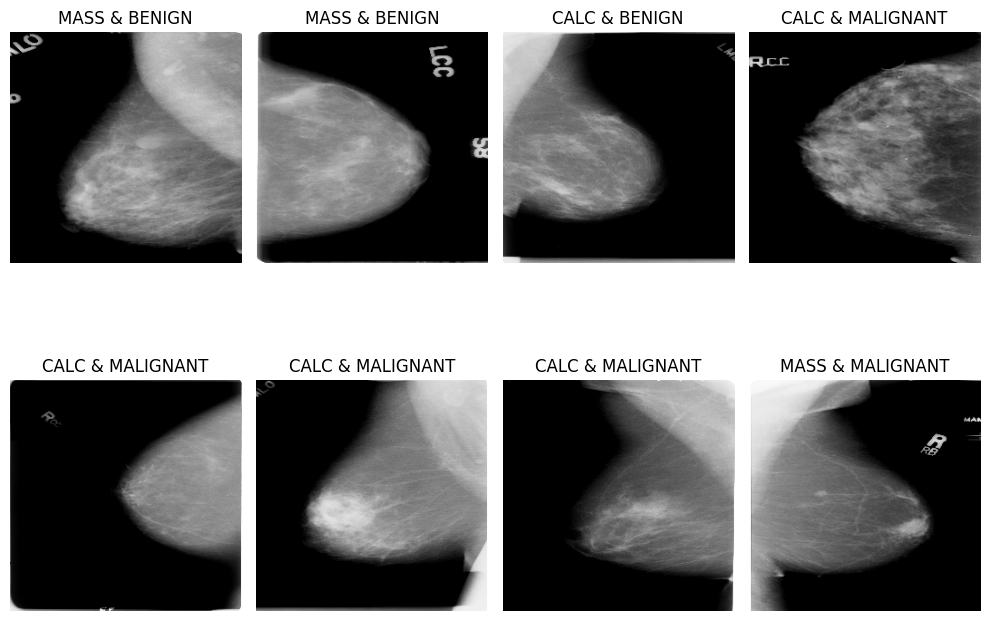

In [129]:
def display_images(images, titles, rows, cols, figsize=(10, 8)):
    """Display a grid of images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select a sample
sample_images = X_train[:8]
sample_labels = y_train[:8]  # Convert one-hot to class index

# Titles
class_names = ['BENIGN_WITHOUT_CALLBACK', 'MASS & MALIGNANT', 'MASS & BENIGN', 'CALC & MALIGNANT', 'CALC & BENIGN']
image_titles = sample_labels

# Display
display_images(sample_images, image_titles, 2, 4)

In [130]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : BENIGN_WITHOUT_CALLBACK
1 : CALC & BENIGN
2 : CALC & MALIGNANT
3 : MASS & BENIGN
4 : MASS & MALIGNANT


In [131]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
#import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [133]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l1_l2

In [148]:
# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.3

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(5, activation='softmax')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [149]:
#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [150]:
# Define a learning rate scheduler (if needed)
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = initial_learning_rate
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

In [151]:
from keras.callbacks import EarlyStopping

In [152]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'path/to/your/checkpoint_directory/model_InceptionV3_Mass&Calc-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [153]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Encode string labels to integers
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

# Step 2: Convert to one-hot encoding
y_train_encoded = to_categorical(y_train_int)
y_test_encoded = to_categorical(y_test_int)

# Optional: Check label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:")
for k, v in label_map.items():
    print(f"{v}: {k}")

Label mapping:
0: BENIGN_WITHOUT_CALLBACK
1: CALC & BENIGN
2: CALC & MALIGNANT
3: MASS & BENIGN
4: MASS & MALIGNANT


In [154]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 20
max_epochs = 50
num_iterations = 100

# Train the model with early stopping
#history = model.fit(X_train, y_train,
 #                   batch_size=batch_size,
  #                  epochs=max_epochs,
   #                 steps_per_epoch=num_iterations,
    #                validation_data=(X_test, y_test), 
     #               callbacks=[LearningRateScheduler(lr_schedule), early_stopping])


# Now, include the callback in your model.fit() call
history = model.fit(X_train, y_train_encoded,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    steps_per_epoch=num_iterations,
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint_callback])


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 44.2887 - accuracy: 0.4087
Epoch 1: val_accuracy improved from -inf to 0.30283, saving model to path/to/your/checkpoint_directory/model_InceptionV3_Mass&Calc-01-0.30.weights.h5
100/100 [==============================] - 46s 326ms/step - loss: 44.2887 - accuracy: 0.4087 - val_loss: 39.7106 - val_accuracy: 0.3028 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 34.6137 - accuracy: 0.6261
Epoch 2: val_accuracy improved from 0.30283 to 0.36439, saving model to path/to/your/checkpoint_directory/model_InceptionV3_Mass&Calc-02-0.36.weights.h5
100/100 [==============================] - 31s 306ms/step - loss: 34.6137 - accuracy: 0.6261 - val_loss: 31.2617 - val_accuracy: 0.3644 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 26.3721 - accuracy: 0.8035
Epoch 3: val_accuracy improved from 0.36439 to 0.40100, saving model to path/to/your/checkpoint_dire

In [155]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [156]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [157]:
# Calculate overall training and validation loss and accuracy
overall_train_loss = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss = np.mean(val_loss)
overall_val_accuracy = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.9448694106605318
Overall Validation Accuracy: 0.4543815727035205


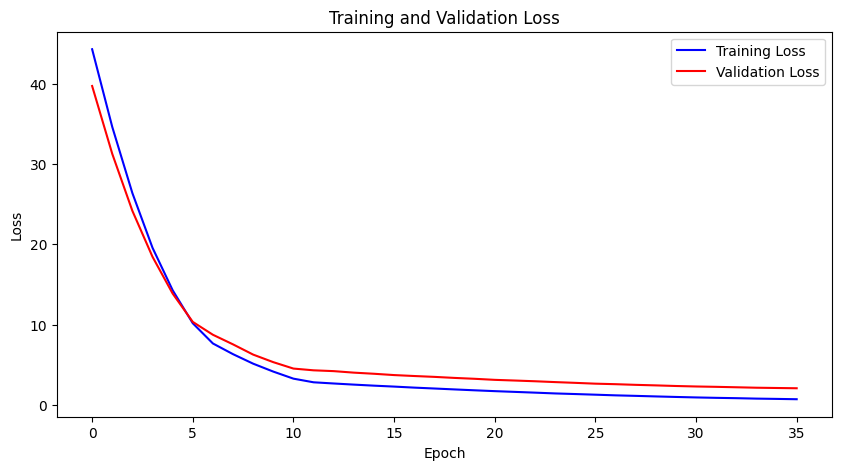

In [159]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

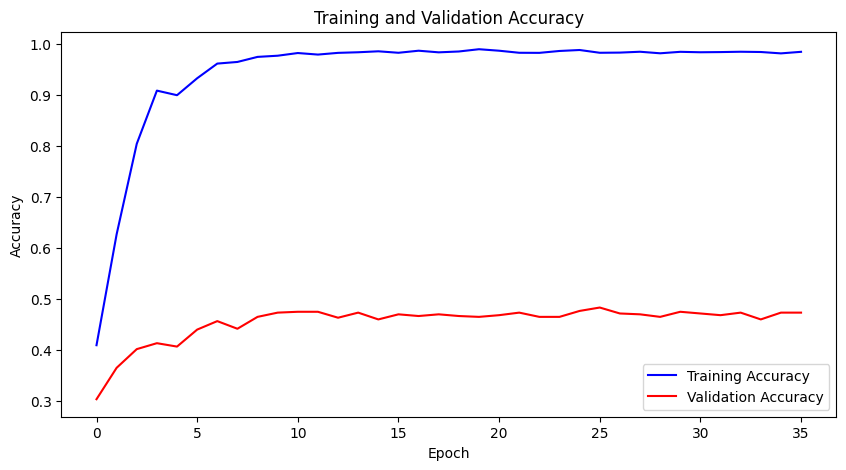

In [160]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [161]:
#'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0 , 
# Define label_to_class mapping
label_to_class = {
    0 : 'BENIGN_WITHOUT_CALLBACK',
    1 : 'CALC & BENIGN',
    2 : 'CALC & MALIGNANT',
    3 : 'MASS & BENIGN',
    4 : 'MASS & MALIGNANT',
    # Add more mappings as needed
}

# Function to decode predictions
def decode_predictions(predictions, threshold=0.5):
    decoded_labels = []
    for pred in predictions:
        decoded_labels.append([label_to_class[i] for i, p in enumerate(pred) if p >= threshold])
    return decoded_labels

1/1 [==============================] - 1s 1s/step
True Class: MASS & MALIGNANT
Predicted Class: [['MASS & MALIGNANT']]


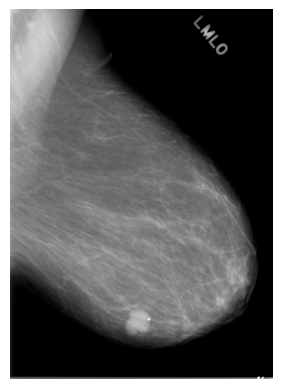

1/1 [==============================] - 0s 40ms/step
True Class: MASS & BENIGN
Predicted Class: [[]]


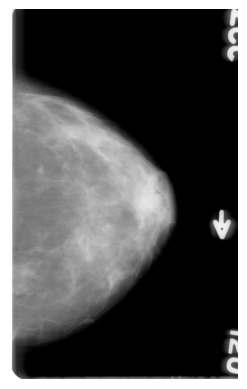

1/1 [==============================] - 0s 39ms/step
True Class: MASS & BENIGN
Predicted Class: [['CALC & MALIGNANT']]


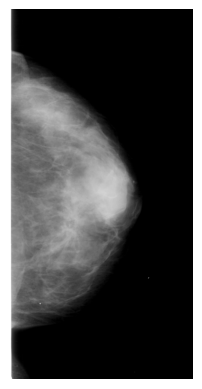

1/1 [==============================] - 0s 38ms/step
True Class: MASS & BENIGN
Predicted Class: [['MASS & BENIGN']]


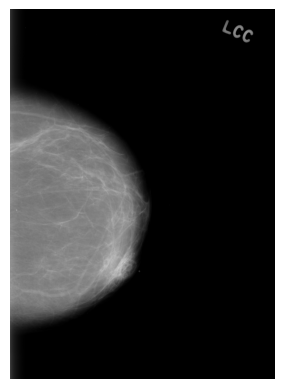

1/1 [==============================] - 0s 40ms/step
True Class: MASS & MALIGNANT
Predicted Class: [['MASS & MALIGNANT']]


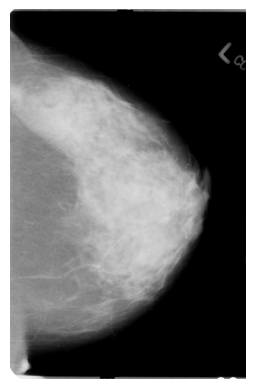

1/1 [==============================] - 0s 40ms/step
True Class: MASS & MALIGNANT
Predicted Class: [['MASS & MALIGNANT']]


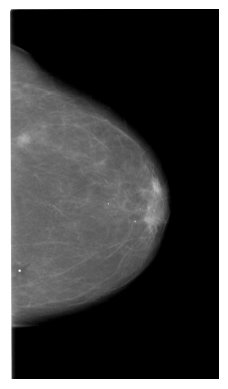

1/1 [==============================] - 0s 40ms/step
True Class: MASS & BENIGN
Predicted Class: [['MASS & BENIGN']]


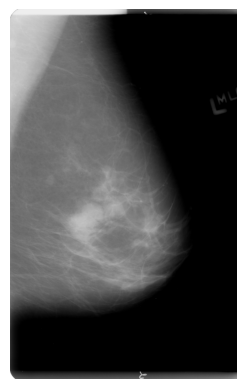

1/1 [==============================] - 0s 38ms/step
True Class: MASS & MALIGNANT
Predicted Class: [['MASS & MALIGNANT']]


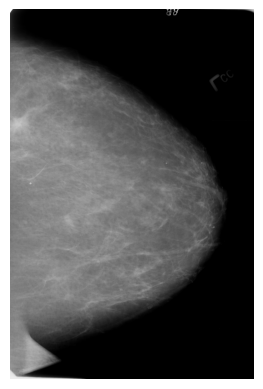

1/1 [==============================] - 0s 38ms/step
True Class: MASS & BENIGN
Predicted Class: [['MASS & BENIGN']]


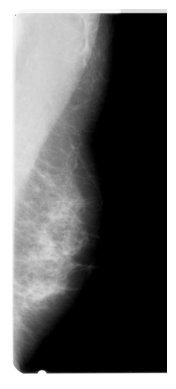

In [166]:
# Function to preprocess and load image
def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to match model's input shape
    img = cv2.resize(img, (224, 224))
    # Normalize pixel values
    img = img.astype(np.float32) / 255.0
    # Convert to RGB color mode
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

# Select the first 5 images from mass_test_combined
test_images = full_sample['image_file_path'].iloc[1:10]
true_classes = full_sample['class'].iloc[1:10]
mapped_true_classes = full_sample.iloc[1:10].apply(map_class, axis=1) 

# Predict classes for each image
for image_path, true_class in zip(test_images, mapped_true_classes):
    # Preprocess image
    img = preprocess_image(image_path)
    # Make prediction
    pred = model.predict(np.array([img]))
    predictions = decode_predictions(pred)
    # Print true and predicted classes
    print("True Class:", true_class)
    print("Predicted Class:", predictions)
    # Load and display the image
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [167]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

In [174]:
datasets = {
    "Training": (X_train, y_train_encoded),
    "Test": (X_test, y_test_encoded)
}


In [175]:
from sklearn.preprocessing import LabelEncoder

# Create and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit using ALL labels

# Transform labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Save class names for later
class_names = label_encoder.classes_


In [176]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, datasets, class_names):
    all_metrics = {}
    all_confusion_matrices = {}

    for dataset_type, (X_data, y_true) in datasets.items():
        y_pred = model.predict(X_data)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        precision = precision_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        confusion_mat = confusion_matrix(y_true, y_pred_labels)

        # Save results
        all_metrics[dataset_type] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1': f1
        }
        all_confusion_matrices[dataset_type] = confusion_mat

        # Print report
        print(f"\n{dataset_type} Classification Report:")
        print(classification_report(y_true, y_pred_labels, target_names=class_names))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"{dataset_type} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    # Calculate overall confusion matrix
    overall_confusion_matrix = sum(all_confusion_matrices.values())
    all_confusion_matrices["Overall"] = overall_confusion_matrix

    # Print and plot overall
    print("\nOverall Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(overall_confusion_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Overall Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Print averaged metrics
    print("\nOverall Performance (Average Across Datasets):")
    for metric in ['accuracy', 'recall', 'precision', 'f1']:
        avg_score = np.mean([m[metric] for m in all_metrics.values()])
        print(f"{metric}: {avg_score:.4f}")

    return all_metrics, all_confusion_matrices


44/44 [==============================] - 4s 99ms/step

Training Classification Report:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.99      1.00      0.99       258
          CALC & BENIGN       0.98      0.99      0.98       223
       CALC & MALIGNANT       0.99      0.96      0.97       226
          MASS & BENIGN       0.98      0.99      0.99       347
       MASS & MALIGNANT       0.99      0.99      0.99       348

               accuracy                           0.99      1402
              macro avg       0.99      0.98      0.98      1402
           weighted avg       0.99      0.99      0.99      1402



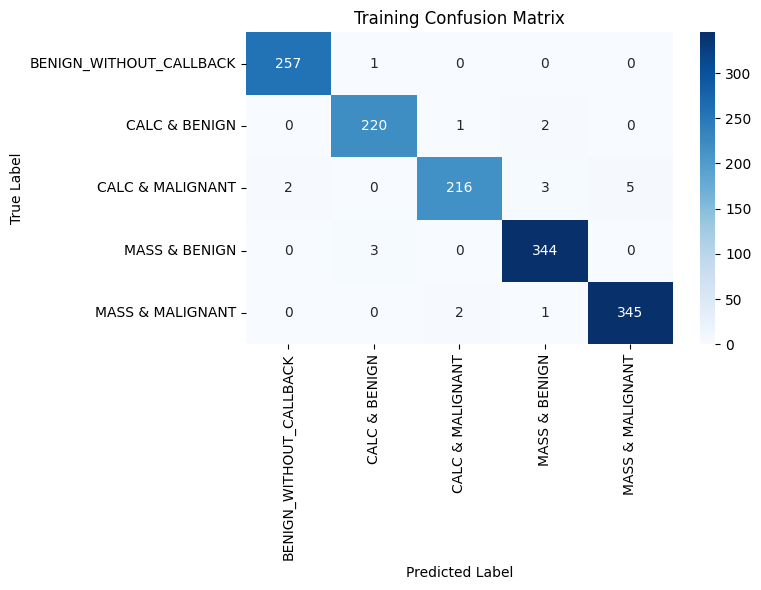

19/19 [==============================] - 2s 101ms/step

Test Classification Report:
                         precision    recall  f1-score   support

BENIGN_WITHOUT_CALLBACK       0.67      0.79      0.73        86
          CALC & BENIGN       0.41      0.36      0.38        97
       CALC & MALIGNANT       0.31      0.24      0.27       102
          MASS & BENIGN       0.46      0.55      0.50       168
       MASS & MALIGNANT       0.47      0.43      0.45       148

               accuracy                           0.47       601
              macro avg       0.47      0.47      0.47       601
           weighted avg       0.46      0.47      0.46       601



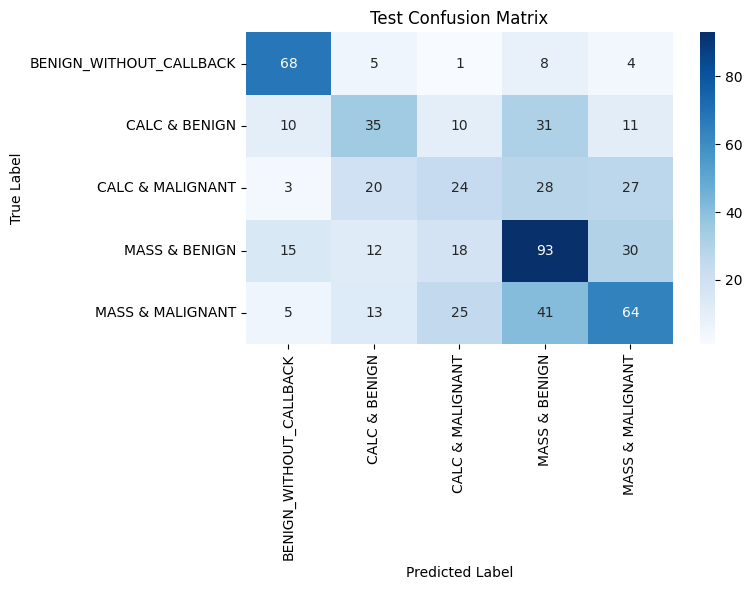


Overall Confusion Matrix:


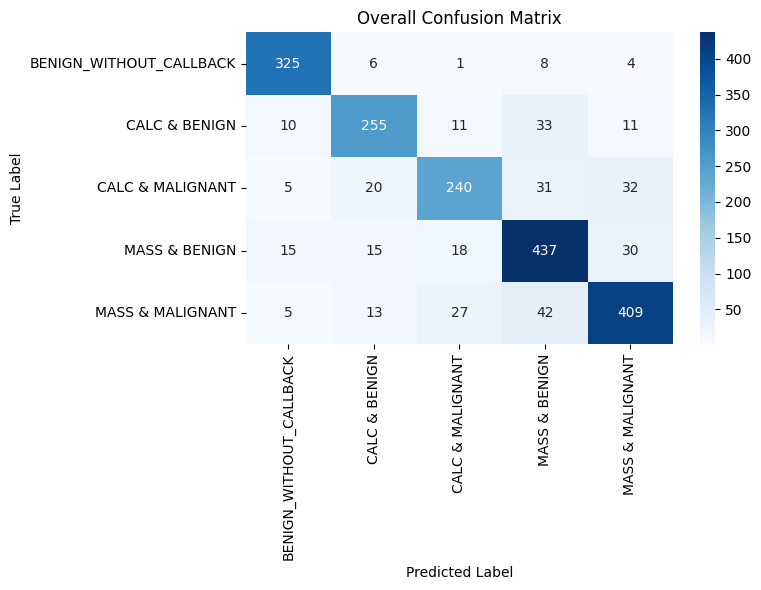


Overall Performance (Average Across Datasets):
accuracy: 0.7291
recall: 0.7291
precision: 0.7230
f1: 0.7245


In [177]:
all_metrics, all_confusion_matrices = evaluate_model(model, datasets, class_names)
